In [1]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import holidays
import gc
import dill
from datetime import date
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

from sklearn.base import clone
import numpy.random as rng
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from functions import *
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

import plotly.express as px
import plotly.graph_objects as go

#Importing MaxNLocator to restrict matplotlib scale to integers
from matplotlib.ticker import MaxNLocator

In [2]:
data_dir = 'data'
orders = pd.read_excel(data_dir+'/Orders.xlsx')
customers = pd.read_excel(data_dir+'/Customers.xlsx')

## 0 Data Analysis

In [3]:
print(orders.shape)
orders.head()

(131706, 8)


id       Date  Customer_ID  Transaction_ID SKU_Category    SKU  Quantity  \
0   1 2021-01-02         2547               1          X52  0EM7L       1.0   
1   2 2021-01-02          822               2          2ML  68BRQ       1.0   
2   3 2021-01-02         3686               3          0H2  CZUZX       1.0   
3   4 2021-01-02         3719               4          0H2  549KK       1.0   
4   5 2021-01-02         9200               5          0H2  K8EHH       1.0   

   Sales_Amount  
0          3.13  
1          5.46  
2          6.35  
3          5.59  
4          6.88

In [4]:
print(customers.shape)
customers.head()

(22625, 4)


Customer_ID GENDER  AGE GEOGRAPHY
0         2547      F   48     Spain
1          822      F   39   Germany
2         3686      F   56    Greece
3         3719      F   49     Spain
4         9200      M   18     Italy

In [5]:
print(orders['SKU'].value_counts())
print(orders['SKU_Category'].value_counts())

UNJKW    2007
COWU2     791
OV1P9     737
M6J9W     698
C6TXL     689
         ... 
DV08L       1
NXHF1       1
4YL6Q       1
T6EUH       1
9E9GV       1
Name: SKU, Length: 5242, dtype: int64
N8U    10913
R6E     5099
LPF     5062
P42     4836
U5F     4570
       ...  
M8H        3
U3N        2
QON        1
2JO        1
OTK        1
Name: SKU_Category, Length: 187, dtype: int64


In [6]:
orders.describe()

id    Customer_ID  Transaction_ID       Quantity  \
count  131706.000000  131706.000000   131706.000000  131706.000000   
mean    65853.500000   12386.450367    32389.604187       1.485318   
std     38020.391614    6086.447552    18709.901238       3.872666   
min         1.000000       1.000000        1.000000       0.010000   
25%     32927.250000    7349.000000    16134.000000       1.000000   
50%     65853.500000   13496.000000    32620.000000       1.000000   
75%     98779.750000   17306.000000    48548.000000       1.000000   
max    131706.000000   22625.000000    64682.000000     400.000000   

        Sales_Amount  
count  131706.000000  
mean       11.981524  
std        19.359699  
min         0.020000  
25%         4.230000  
50%         6.920000  
75%        12.330000  
max       707.730000

In [7]:
orders[orders.Quantity == 0]

Empty DataFrame
Columns: [id, Date, Customer_ID, Transaction_ID, SKU_Category, SKU, Quantity, Sales_Amount]
Index: []

In [8]:
orders = orders.loc[orders.Quantity % 1 == 0]
orders.Quantity = orders.Quantity.apply(lambda x: int(x))
orders.head()

id       Date  Customer_ID  Transaction_ID SKU_Category    SKU  Quantity  \
0   1 2021-01-02         2547               1          X52  0EM7L         1   
1   2 2021-01-02          822               2          2ML  68BRQ         1   
2   3 2021-01-02         3686               3          0H2  CZUZX         1   
3   4 2021-01-02         3719               4          0H2  549KK         1   
4   5 2021-01-02         9200               5          0H2  K8EHH         1   

   Sales_Amount  
0          3.13  
1          5.46  
2          6.35  
3          5.59  
4          6.88

In [9]:
orders[orders.Quantity > 100]

id       Date  Customer_ID  Transaction_ID SKU_Category    SKU  \
17084    17085 2021-02-19         6869            8186          LGI  VWLV9   
64680    64681 2021-06-29        17025           32069          LGI  VWLV9   
77676    77677 2021-09-07        19791           42595          H8O  CKDW0   
94222    94223 2021-10-13        20055           49727          H8O  CKDW0   
112719  112720 2021-11-27         1694           57951          H8O  CKDW0   
113907  113908 2021-11-30        11634           58440          XG4  MAJO7   
118682  118683 2021-12-10        16147           60457          H8O  CKDW0   
121888  121889 2021-12-16        18365           61798          H8O  CKDW0   

        Quantity  Sales_Amount  
17084        176         74.80  
64680        176         74.80  
77676        400         16.37  
94222        200          8.18  
112719       300         12.27  
113907       200         15.00  
118682       200          8.18  
121888       200          8.18

In [10]:
orders[orders.SKU == 'MAJO7']

id       Date  Customer_ID  Transaction_ID SKU_Category    SKU  \
34020    34021 2021-04-08        17951           16671          XG4  MAJO7   
54133    54134 2021-05-30        19996           26889          XG4  MAJO7   
67803    67804 2021-08-09        19996           38278          XG4  MAJO7   
70714    70715 2021-08-17        20576           39484          XG4  MAJO7   
74011    74012 2021-08-25        10712           40935          XG4  MAJO7   
74745    74746 2021-08-28        16783           41258          XG4  MAJO7   
79395    79396 2021-09-11        20173           43325          XG4  MAJO7   
80579    80580 2021-09-14        12524           43806          XG4  MAJO7   
105668  105669 2021-11-10        20537           54829          XG4  MAJO7   
112676  112677 2021-11-27        16916           57924          XG4  MAJO7   
113907  113908 2021-11-30        11634           58440          XG4  MAJO7   
115664  115665 2021-12-03         1665           59195          XG4  MAJO7   
121389  121390 2021-07-06        17602           33188          XG4  MAJO7   
129301  129302 2021-07-28        21691           36646          XG4  MAJO7   

        Quantity  Sales_Amount  
34020         12          0.90  
54133         20          1.75  
67803         20          1.75  
70714          4          0.34  
74011        100          7.50  
74745         12          0.90  
79395          5          0.38  
80579         75          5.62  
105668        90          7.88  
112676       100          7.50  
113907       200         15.00  
115664        20          1.24  
121389         4          0.34  
129301        30          2.62

In [11]:
customers.GEOGRAPHY.value_counts()

Germany        7970
Italy          4480
France         2644
Greece         2269
UK             2264
Spain          1651
Netherlands    1347
Name: GEOGRAPHY, dtype: int64

In [12]:
customers.GENDER.value_counts()

F    11328
M    11297
Name: GENDER, dtype: int64

In [13]:
orders.SKU_Category.value_counts()

N8U    10913
R6E     5099
LPF     5046
P42     4836
U5F     4568
       ...  
M8H        3
U3N        2
QON        1
2JO        1
OTK        1
Name: SKU_Category, Length: 187, dtype: int64

In [14]:
transactions = orders.groupby("Transaction_ID").agg(Customer_ID = ('Customer_ID', 'max'), diff_items = ('SKU', 'nunique'), total_items = ('Quantity', 'sum'),
                                                 order_value = ('Sales_Amount','sum'))
transactions[transactions.index == 32900]

Customer_ID  diff_items  total_items  order_value
Transaction_ID                                                   
32900                 20203           7           11        47.92

### 1 Statistics

In [15]:
transactions = orders.groupby("Transaction_ID").agg(Customer_ID = ('Customer_ID', 'max'), diff_items = ('SKU', 'nunique'), total_items = ('Quantity', 'sum'),
                                                 order_value = ('Sales_Amount','sum'), date = ('Date', 'max'))
customer_transact = transactions.groupby("Customer_ID").agg(num_orders = ('Customer_ID', 'count'), avg_diff_items = ('diff_items', np.mean), items_bought = ('total_items', 'sum'),
                                                   avg_items = ('total_items', np.mean),total_revenue = ('order_value', 'sum'), avg_order_value = ('order_value', np.mean),
                                                   max_value = ('order_value', 'max'), min_value = ('order_value', 'min'), max_item_bought = ('total_items', 'max'),
                                                   min_item_bought = ('total_items', 'min'))
customer_transact

num_orders  avg_diff_items  items_bought  avg_items  \
Customer_ID                                                        
1                     1            2.00             2        2.0   
2                     2            1.00             2        1.0   
3                     1            3.00             4        4.0   
4                     2            2.50             5        2.5   
5                     5            1.00            14        2.8   
...                 ...             ...           ...        ...   
22621                 1            2.00             3        3.0   
22622                 1            1.00             1        1.0   
22623                 1            2.00             3        3.0   
22624                 1            2.00             2        2.0   
22625                 4            2.25            10        2.5   

             total_revenue  avg_order_value  max_value  min_value  \
Customer_ID                                                         
1                    16.29           16.290      16.29      16.29   
2                    22.77           11.385      15.00       7.77   
3                    10.92           10.920      10.92      10.92   
4                    33.29           16.645      26.60       6.69   
5                    78.82           15.764      20.13       7.06   
...                    ...              ...        ...        ...   
22621                 9.69            9.690       9.69       9.69   
22622                 6.07            6.070       6.07       6.07   
22623               128.01          128.010     128.01     128.01   
22624                19.60           19.600      19.60      19.60   
22625                83.62           20.905      59.50       1.11   

             max_item_bought  min_item_bought  
Customer_ID                                    
1                          2                2  
2                          1                1  
3                          4                4  
4                          4                1  
5                          4                1  
...                      ...              ...  
22621                      3                3  
22622                      1                1  
22623                      3                3  
22624                      2                2  
22625                      4                1  

[22586 rows x 10 columns]

In [16]:
item_df = orders.groupby("Customer_ID").agg(first_date=('Date','min'), last_date=('Date','max'),
                                              most_cat = ('SKU_Category', lambda x: x.value_counts().index[0]), most_item_SKU=('SKU', lambda x: x.value_counts().index[0]))
item_df

first_date  last_date most_cat most_item_SKU
Customer_ID                                             
1           2021-01-22 2021-01-22      0H2         6OUVC
2           2021-03-24 2021-06-19      TVL         2SLS0
3           2021-01-02 2021-01-02      TW8         Y1M2E
4           2021-07-11 2021-11-09      69B         APEJQ
5           2021-02-09 2021-07-05      P42         DMJ70
...                ...        ...      ...           ...
22621       2021-12-10 2021-12-10      R6E         UN0SI
22622       2021-12-16 2021-12-16      P42         OV1P9
22623       2021-12-21 2021-12-21      1EO         PTA6G
22624       2021-12-02 2021-12-02      ORW         QVSZ4
22625       2021-12-02 2021-12-31      N8U         61L0Q

[22586 rows x 4 columns]

In [17]:
cust_df = pd.merge(customer_transact, item_df, how='left', left_index=True, right_index=True)
cust_df

num_orders  avg_diff_items  items_bought  avg_items  \
Customer_ID                                                        
1                     1            2.00             2        2.0   
2                     2            1.00             2        1.0   
3                     1            3.00             4        4.0   
4                     2            2.50             5        2.5   
5                     5            1.00            14        2.8   
...                 ...             ...           ...        ...   
22621                 1            2.00             3        3.0   
22622                 1            1.00             1        1.0   
22623                 1            2.00             3        3.0   
22624                 1            2.00             2        2.0   
22625                 4            2.25            10        2.5   

             total_revenue  avg_order_value  max_value  min_value  \
Customer_ID                                                         
1                    16.29           16.290      16.29      16.29   
2                    22.77           11.385      15.00       7.77   
3                    10.92           10.920      10.92      10.92   
4                    33.29           16.645      26.60       6.69   
5                    78.82           15.764      20.13       7.06   
...                    ...              ...        ...        ...   
22621                 9.69            9.690       9.69       9.69   
22622                 6.07            6.070       6.07       6.07   
22623               128.01          128.010     128.01     128.01   
22624                19.60           19.600      19.60      19.60   
22625                83.62           20.905      59.50       1.11   

             max_item_bought  min_item_bought first_date  last_date most_cat  \
Customer_ID                                                                    
1                          2                2 2021-01-22 2021-01-22      0H2   
2                          1                1 2021-03-24 2021-06-19      TVL   
3                          4                4 2021-01-02 2021-01-02      TW8   
4                          4                1 2021-07-11 2021-11-09      69B   
5                          4                1 2021-02-09 2021-07-05      P42   
...                      ...              ...        ...        ...      ...   
22621                      3                3 2021-12-10 2021-12-10      R6E   
22622                      1                1 2021-12-16 2021-12-16      P42   
22623                      3                3 2021-12-21 2021-12-21      1EO   
22624                      2                2 2021-12-02 2021-12-02      ORW   
22625                      4                1 2021-12-02 2021-12-31      N8U   

            most_item_SKU  
Customer_ID                
1                   6OUVC  
2                   2SLS0  
3                   Y1M2E  
4                   APEJQ  
5                   DMJ70  
...                   ...  
22621               UN0SI  
22622               OV1P9  
22623               PTA6G  
22624               QVSZ4  
22625               61L0Q  

[22586 rows x 14 columns]

In [18]:
customers.set_index('Customer_ID', inplace=True)
customers

GENDER  AGE GEOGRAPHY
Customer_ID                      
2547             F   48     Spain
822              F   39   Germany
3686             F   56    Greece
3719             F   49     Spain
9200             M   18     Italy
...            ...  ...       ...
14811            M   32   Germany
3232             F   47     Spain
5751             M   34   Germany
10765            M   29   Germany
11733            F   53    Greece

[22625 rows x 3 columns]

In [19]:
customers_df = pd.merge(customers, cust_df, left_index=True, right_index=True, how='left')
customers_df

GENDER  AGE GEOGRAPHY  num_orders  avg_diff_items  items_bought  \
Customer_ID                                                                   
2547             F   48     Spain         7.0        2.285714          22.0   
822              F   39   Germany         3.0        1.666667           5.0   
3686             F   56    Greece        15.0        3.333333          63.0   
3719             F   49     Spain        10.0        4.700000          70.0   
9200             M   18     Italy         2.0        1.000000           2.0   
...            ...  ...       ...         ...             ...           ...   
14811            M   32   Germany         1.0        1.000000           1.0   
3232             F   47     Spain         1.0        2.000000           2.0   
5751             M   34   Germany         1.0        3.000000           3.0   
10765            M   29   Germany         1.0        1.000000           1.0   
11733            F   53    Greece         1.0        1.000000           1.0   

             avg_items  total_revenue  avg_order_value  max_value  min_value  \
Customer_ID                                                                    
2547          3.142857         121.36        17.337143      39.62       3.13   
822           1.666667          20.40         6.800000       8.59       5.46   
3686          4.200000         405.44        27.029333     138.13       6.35   
3719          7.000000         420.72        42.072000     224.98       1.58   
9200          1.000000          18.01         9.005000      11.13       6.88   
...                ...            ...              ...        ...        ...   
14811         1.000000          26.54        26.540000      26.54      26.54   
3232          2.000000          12.89        12.890000      12.89      12.89   
5751          3.000000          59.59        59.590000      59.59      59.59   
10765         1.000000           1.19         1.190000       1.19       1.19   
11733         1.000000           4.57         4.570000       4.57       4.57   

             max_item_bought  min_item_bought first_date  last_date most_cat  \
Customer_ID                                                                    
2547                     6.0              1.0 2021-01-02 2021-04-16      X52   
822                      3.0              1.0 2021-01-02 2021-02-03      TW8   
3686                    20.0              1.0 2021-01-02 2021-03-08      0H2   
3719                    35.0              1.0 2021-01-02 2021-03-05      0KX   
9200                     1.0              1.0 2021-01-02 2021-04-09      0H2   
...                      ...              ...        ...        ...      ...   
14811                    1.0              1.0 2021-07-04 2021-07-04      LPF   
3232                     2.0              2.0 2021-08-01 2021-08-01      QCG   
5751                     3.0              3.0 2021-07-04 2021-07-04      LSD   
10765                    1.0              1.0 2021-07-04 2021-07-04      Z4O   
11733                    1.0              1.0 2021-07-04 2021-07-04      N8U   

            most_item_SKU  
Customer_ID                
2547                885U7  
822                 68BRQ  
3686                B87MU  
3719                W14J3  
9200                K8EHH  
...                   ...  
14811               UPB37  
3232                M4TM4  
5751                NSGRM  
10765               6IISH  
11733               X5TFY  

[22625 rows x 17 columns]

In [20]:
customers_df["age_bin"] = pd.cut(customers_df["AGE"], bins = [18 , 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80], right = False,
                                 labels=["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70+"])
customers_df.head(5)

GENDER  AGE GEOGRAPHY  num_orders  avg_diff_items  items_bought  \
Customer_ID                                                                   
2547             F   48     Spain         7.0        2.285714          22.0   
822              F   39   Germany         3.0        1.666667           5.0   
3686             F   56    Greece        15.0        3.333333          63.0   
3719             F   49     Spain        10.0        4.700000          70.0   
9200             M   18     Italy         2.0        1.000000           2.0   

             avg_items  total_revenue  avg_order_value  max_value  min_value  \
Customer_ID                                                                    
2547          3.142857         121.36        17.337143      39.62       3.13   
822           1.666667          20.40         6.800000       8.59       5.46   
3686          4.200000         405.44        27.029333     138.13       6.35   
3719          7.000000         420.72        42.072000     224.98       1.58   
9200          1.000000          18.01         9.005000      11.13       6.88   

             max_item_bought  min_item_bought first_date  last_date most_cat  \
Customer_ID                                                                    
2547                     6.0              1.0 2021-01-02 2021-04-16      X52   
822                      3.0              1.0 2021-01-02 2021-02-03      TW8   
3686                    20.0              1.0 2021-01-02 2021-03-08      0H2   
3719                    35.0              1.0 2021-01-02 2021-03-05      0KX   
9200                     1.0              1.0 2021-01-02 2021-04-09      0H2   

            most_item_SKU age_bin  
Customer_ID                        
2547                885U7   45-49  
822                 68BRQ   35-39  
3686                B87MU   55-59  
3719                W14J3   45-49  
9200                K8EHH   18-24

In [21]:
transactions = pd.merge(transactions, customers[["GEOGRAPHY"]], left_on="Customer_ID", right_index=True, how='left')

In [22]:
transactions[pd.isna(transactions.GEOGRAPHY)]

Empty DataFrame
Columns: [Customer_ID, diff_items, total_items, order_value, date, GEOGRAPHY]
Index: []

In [23]:
transactions.GEOGRAPHY.unique()

array(['Spain', 'Germany', 'Greece', 'Italy', 'UK', 'France',
       'Netherlands'], dtype=object)

In [24]:
transactions["month"] = transactions["date"].dt.month
transactions["is_holiday"] = False

def is_holiday(calendar, date) -> bool:
    return date in calendar

def define_holidays(df: pd.DataFrame, country_col: str="GEOGRAPHY") -> None :
    countries = df[country_col].unique()
    for c in countries:
        calendar = holidays.country_holidays(c)
        df.loc[df[country_col] == c, 'is_holiday'] = df.apply(lambda x: is_holiday(calendar, x.date), axis=1)
    return df

transactions = define_holidays(transactions)
transactions.rename(columns={'total_items': 'items_bought', 'order_value': 'order_revenue'}, inplace=True)
transactions[transactions.is_holiday == True]

Customer_ID  diff_items  items_bought  order_revenue  \
Transaction_ID                                                         
575                    4459           3             8          42.43   
576                      17           2             3           9.57   
577                    5867           1             1           6.35   
578                    3322           1             1           1.75   
580                    3336           1             1           7.29   
...                     ...         ...           ...            ...   
64106                 13347           1             1           8.94   
64119                  6493           1             3          21.93   
64120                 17777           2             2          23.75   
64127                 13408           1             1          11.00   
64154                 11027           1            24           6.54   

                     date GEOGRAPHY  month  is_holiday  
Transaction_ID                                          
575            2021-01-06    Greece      1        True  
576            2021-01-06    Greece      1        True  
577            2021-01-06     Italy      1        True  
578            2021-01-06     Italy      1        True  
580            2021-01-06     Spain      1        True  
...                   ...       ...    ...         ...  
64106          2021-12-28        UK     12        True  
64119          2021-12-28        UK     12        True  
64120          2021-12-28        UK     12        True  
64127          2021-12-28        UK     12        True  
64154          2021-12-28        UK     12        True  

[1425 rows x 8 columns]

In [25]:
def generate_categorical_column_stats(df:pd.DataFrame, columns=list[str], summary_cols=list[str]) -> pd.DataFrame:
    results = []

    for c in columns:
        c_cap = str(c).capitalize()
        for val in df[c].unique():
            val_cap = str(val).capitalize()
            for sum_col in summary_cols:
                sum_col_cap = str(sum_col).capitalize()
                subset = df[df[c] == val][sum_col]
                results.append({'column': c_cap, 'subset': val_cap, 'variable': sum_col_cap, 'statistic': 'Average', 'value': round(np.mean(subset),2)})
                results.append({'column': c_cap, 'subset': val_cap, 'variable': sum_col_cap, 'statistic': 'Median', 'value': pd.Series.median(subset)})
                results.append({'column': c_cap, 'subset': val_cap, 'variable': sum_col_cap, 'statistic': 'Max', 'value': max(subset)})
                results.append({'column': c_cap, 'subset': val_cap, 'variable': sum_col_cap, 'statistic': 'Min', 'value': min(subset)})
    return results

In [26]:
sum_cols = [ 'total_revenue','items_bought', 'num_orders']
customer_summary = generate_categorical_column_stats(customers_df, ['age_bin','GEOGRAPHY', 'GENDER'], sum_cols)
geo_sum_cols = ['items_bought', 'order_revenue']
geo_summary = generate_categorical_column_stats(transactions, ['month', 'is_holiday'], geo_sum_cols)
results = pd.DataFrame(customer_summary + geo_summary).sort_values(by=['column', 'subset'])
results.to_csv("data/output_1.csv")

In [27]:
def plot_statistical_data(df: pd.DataFrame, cat_cols: list[str], sum_cols: list[str]) -> None:
    for c in cat_cols:
        for sum_col in sum_cols:
            subset = df[[c,sum_col]]
            cat_name = str(c).replace('_', ' ').capitalize()
            sum_col_name = str(sum_col).replace('_', ' ').capitalize()
            # Sum
            subset.groupby(c).sum().reset_index().plot(x=c, y=sum_col, kind="bar", legend=False)
            plt.title('Sum of {} by {}'.format(sum_col_name, cat_name))
            plt.xlabel(cat_name)
            plt.ylabel(sum_col_name)
            plt.show()

            # Mean
            subset.groupby(c).mean().reset_index().plot(x=c, y=sum_col, kind="area", color='orange', legend=False)
            plt.title('Average {} by {}'.format(sum_col_name, cat_name))
            plt.xlabel(cat_name)
            plt.ylabel(sum_col_name)
            plt.show()

            # Median
            subset.groupby(c).median().reset_index().plot(x=c, y=sum_col, kind="area", color = 'yellow', legend=False)
            plt.title('Median {} by {}'.format(sum_col_name, cat_name))
            plt.xlabel(cat_name)
            plt.ylabel(sum_col_name)
            plt.show()

            # Max
            subset.groupby(c).max().reset_index().plot(x=c, y=sum_col, kind="area", color = 'green', legend=False)
            plt.title('Max {} by {}'.format(sum_col_name, cat_name))
            plt.xlabel(cat_name)
            plt.ylabel(sum_col_name)
            plt.show()

            # Min
            subset.groupby(c).min().reset_index().plot(x=c, y=sum_col, kind="area", color = 'purple', legend=False)
            plt.title('Min {} by {}'.format(sum_col_name, cat_name))
            plt.xlabel(cat_name)
            plt.ylabel(sum_col_name)
            plt.show()

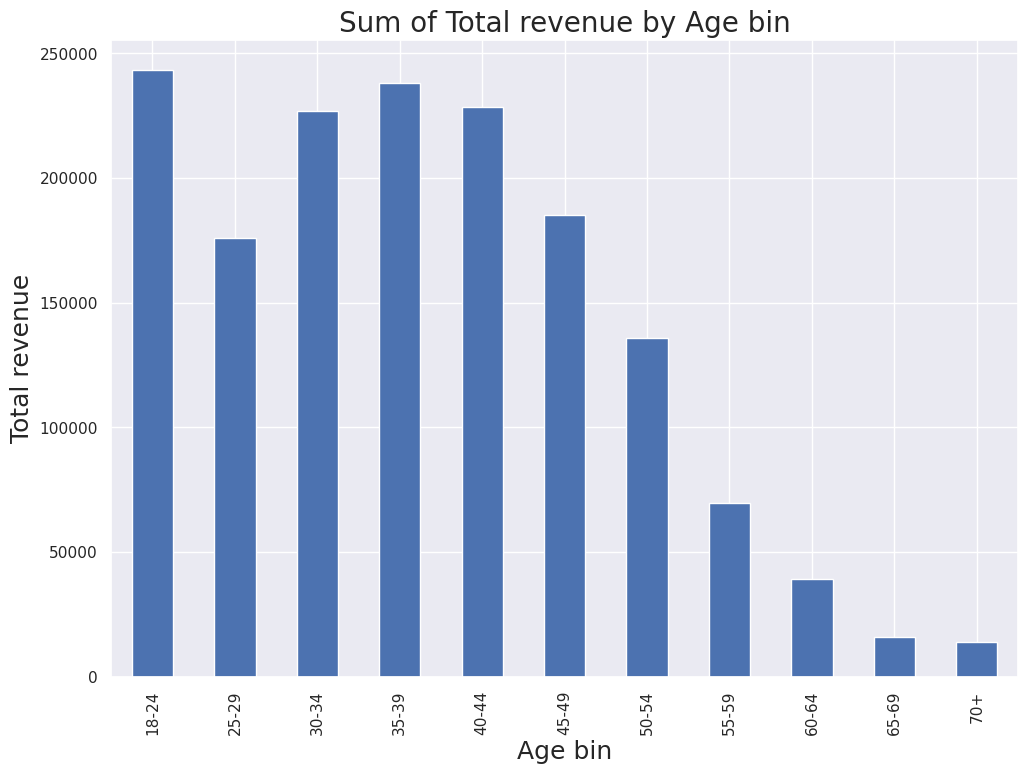

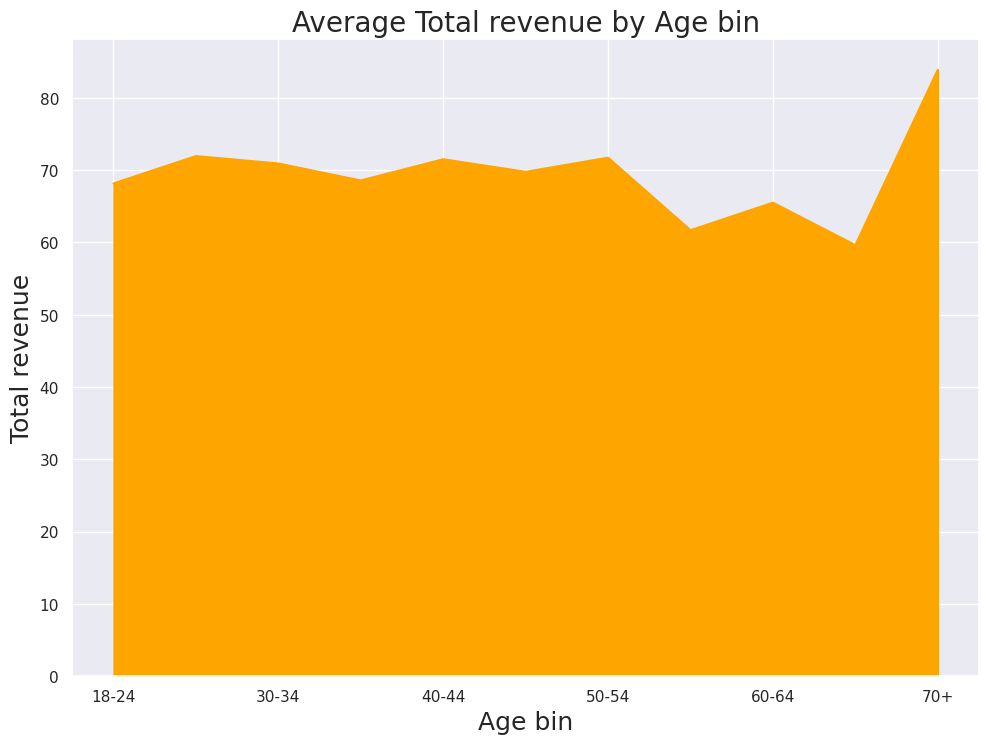

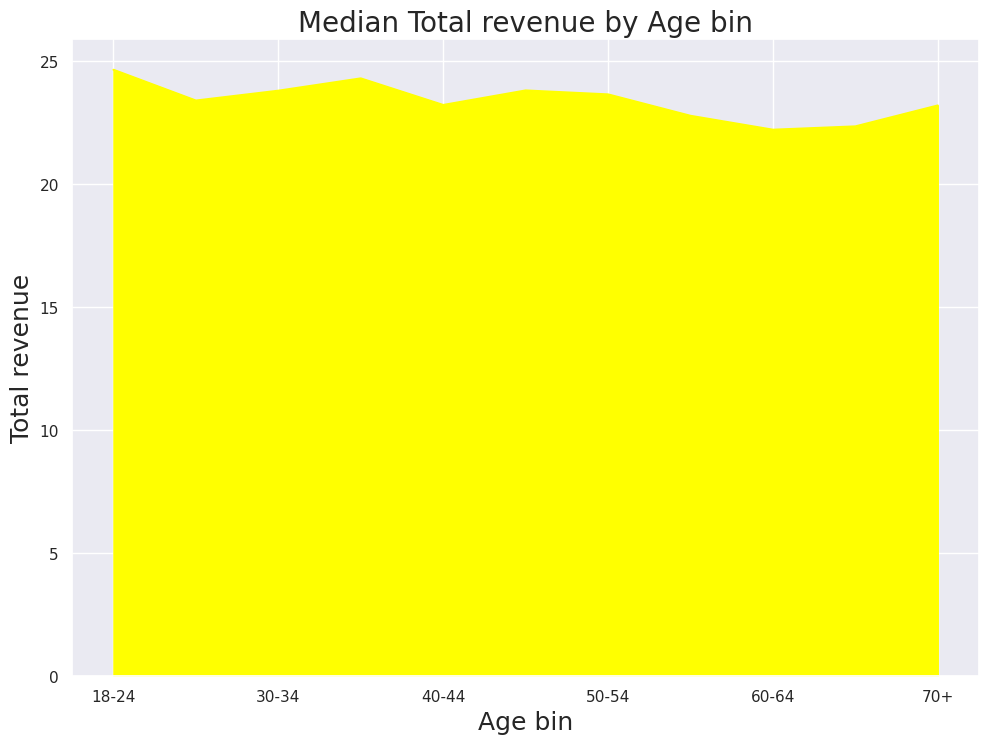

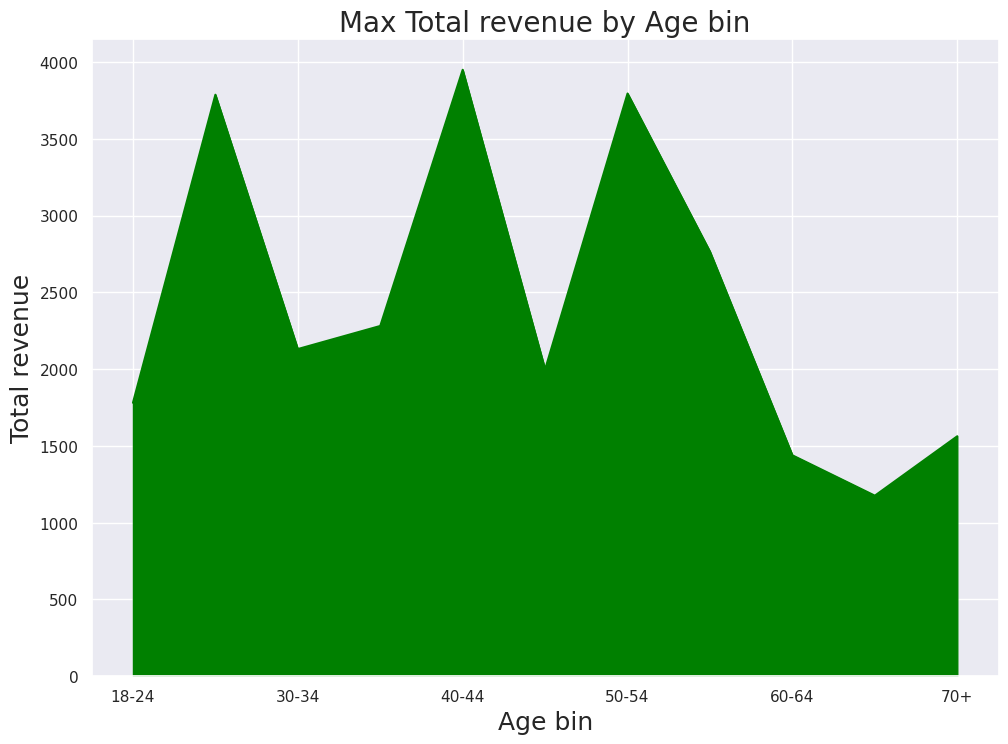

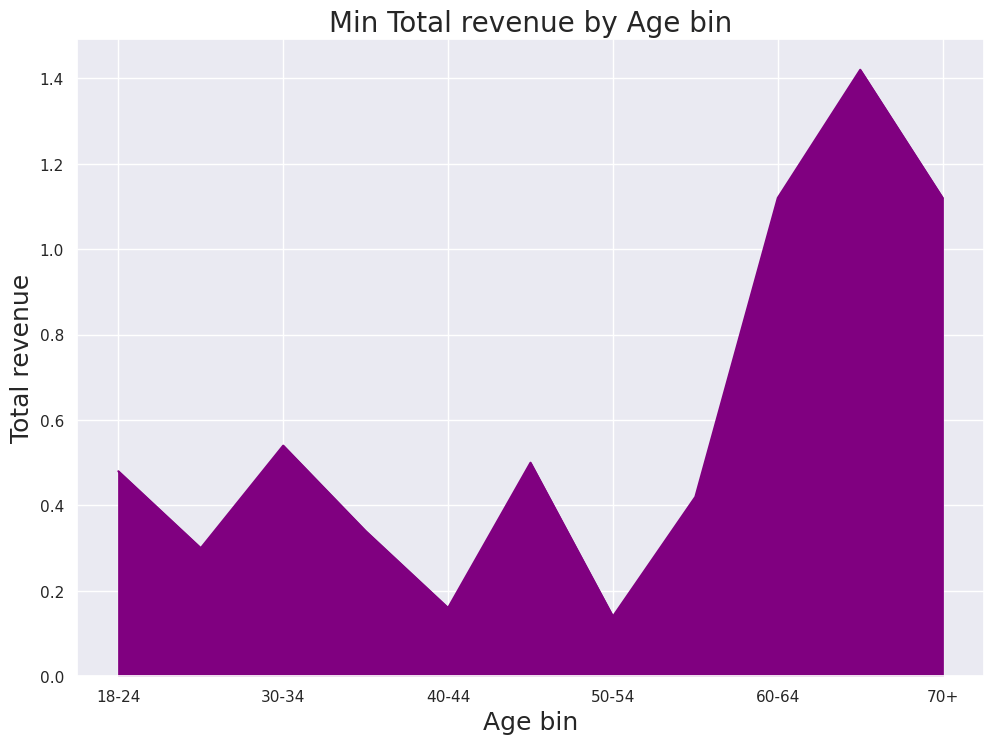

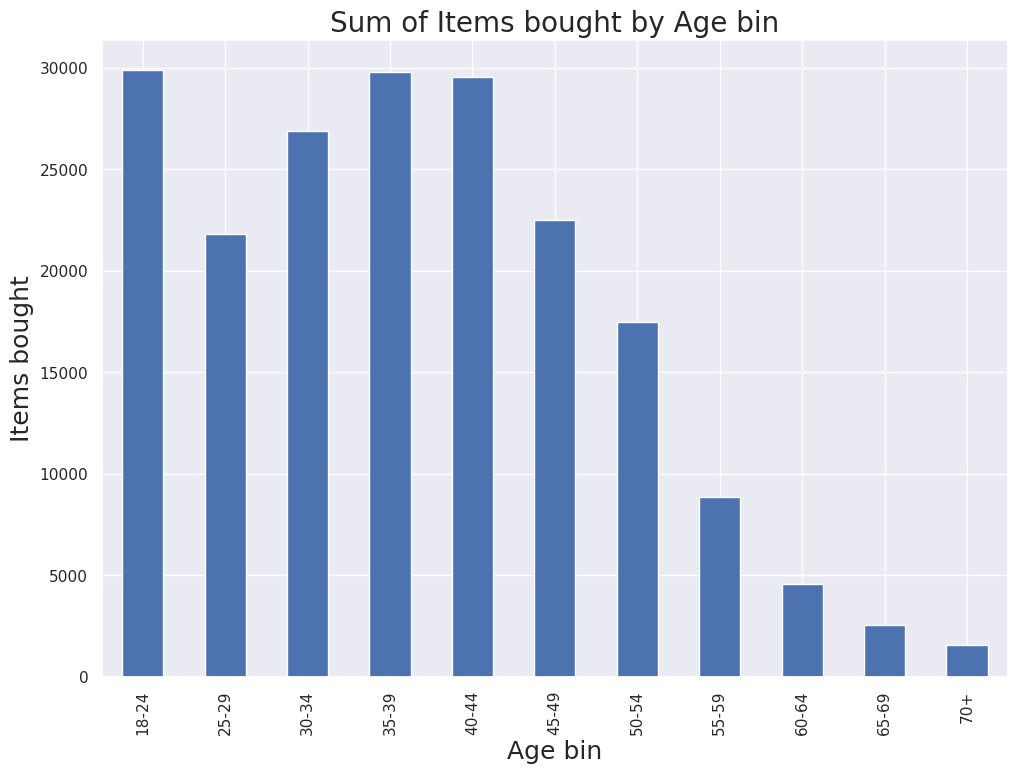

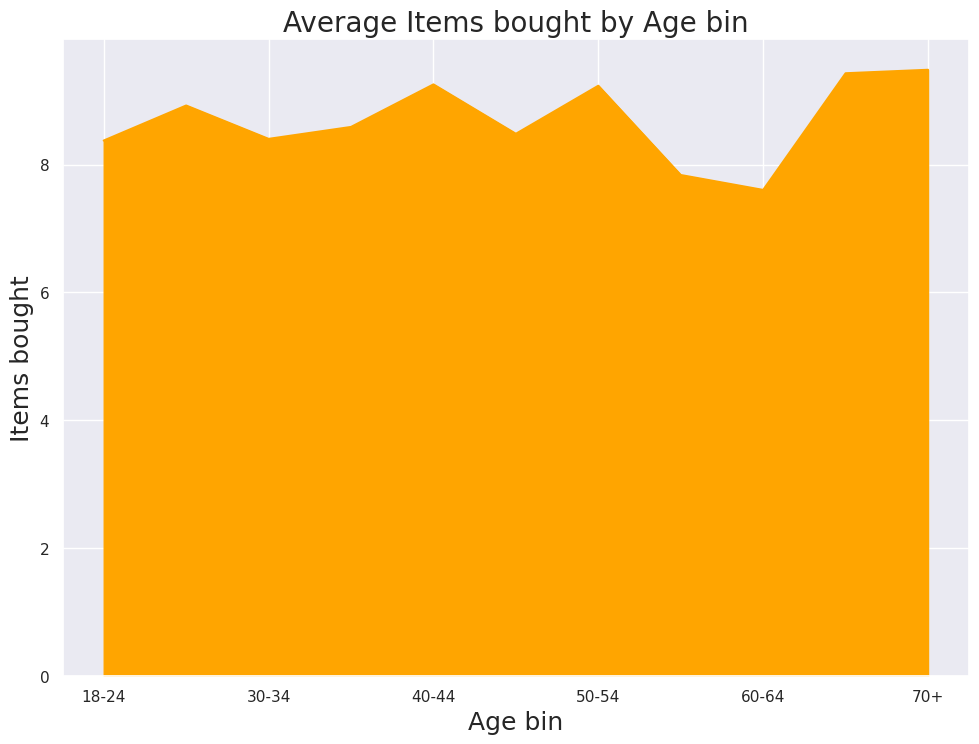

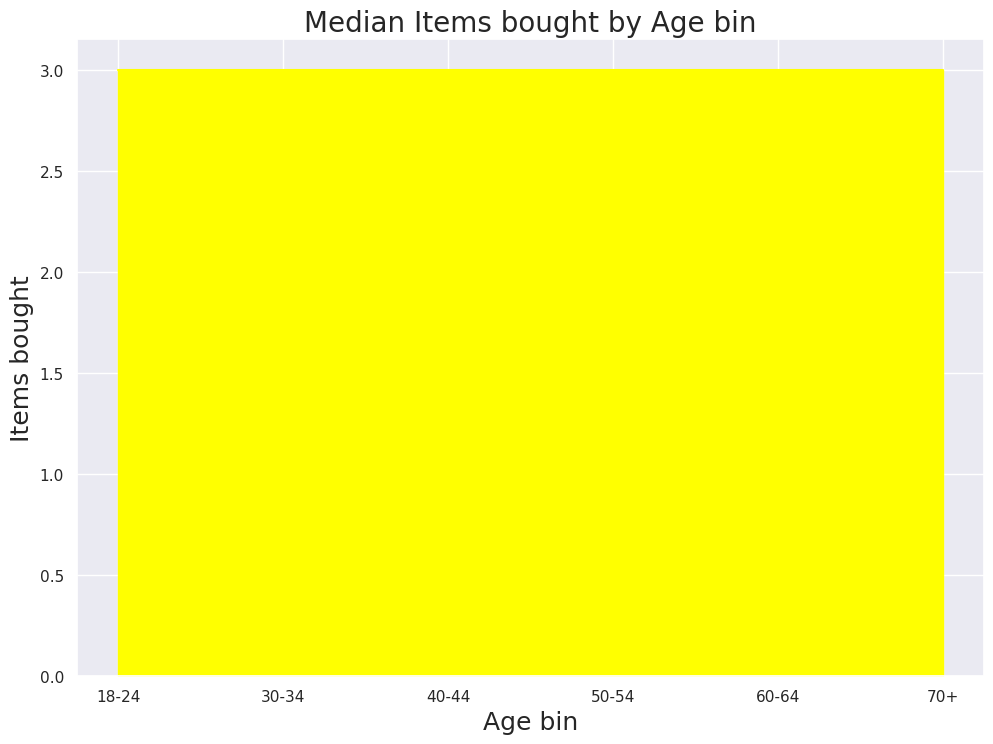

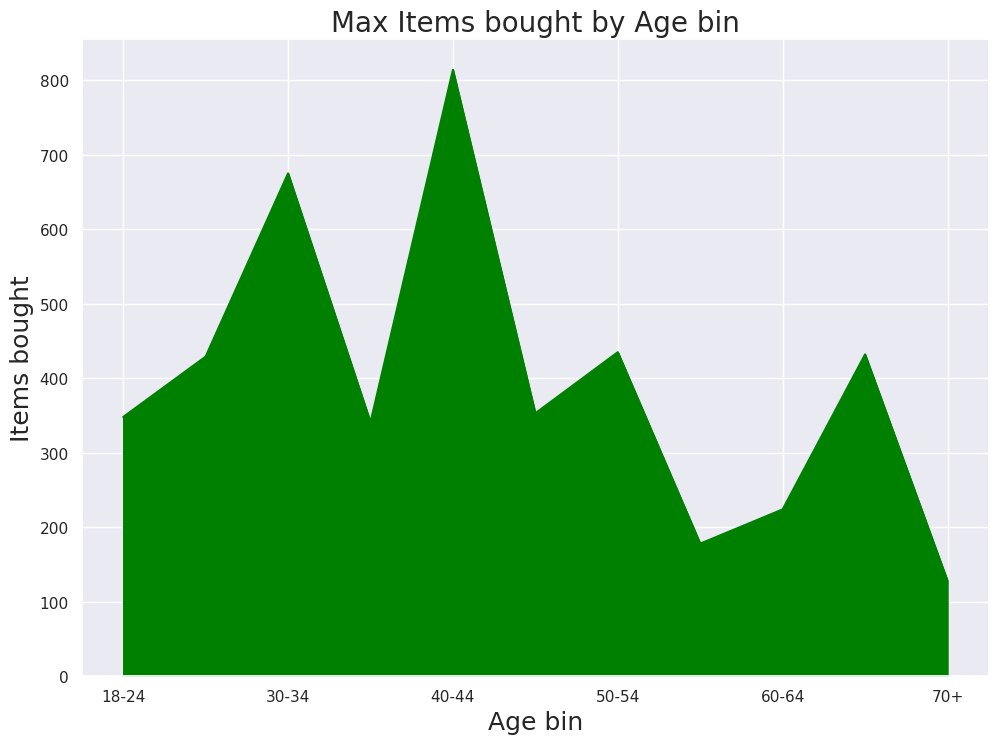

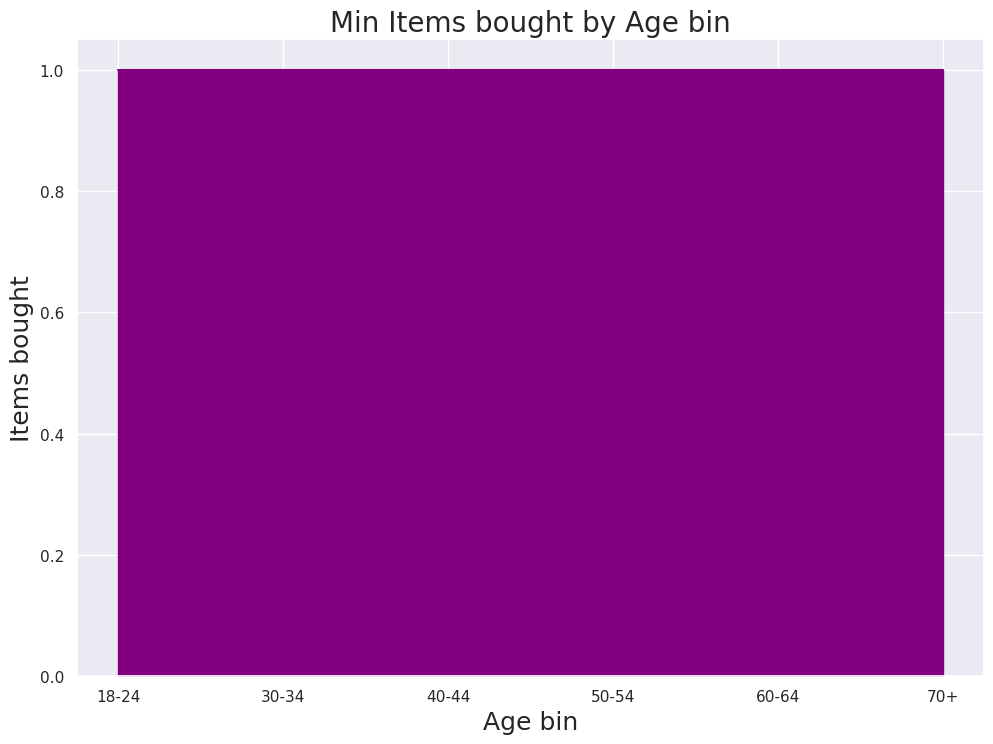

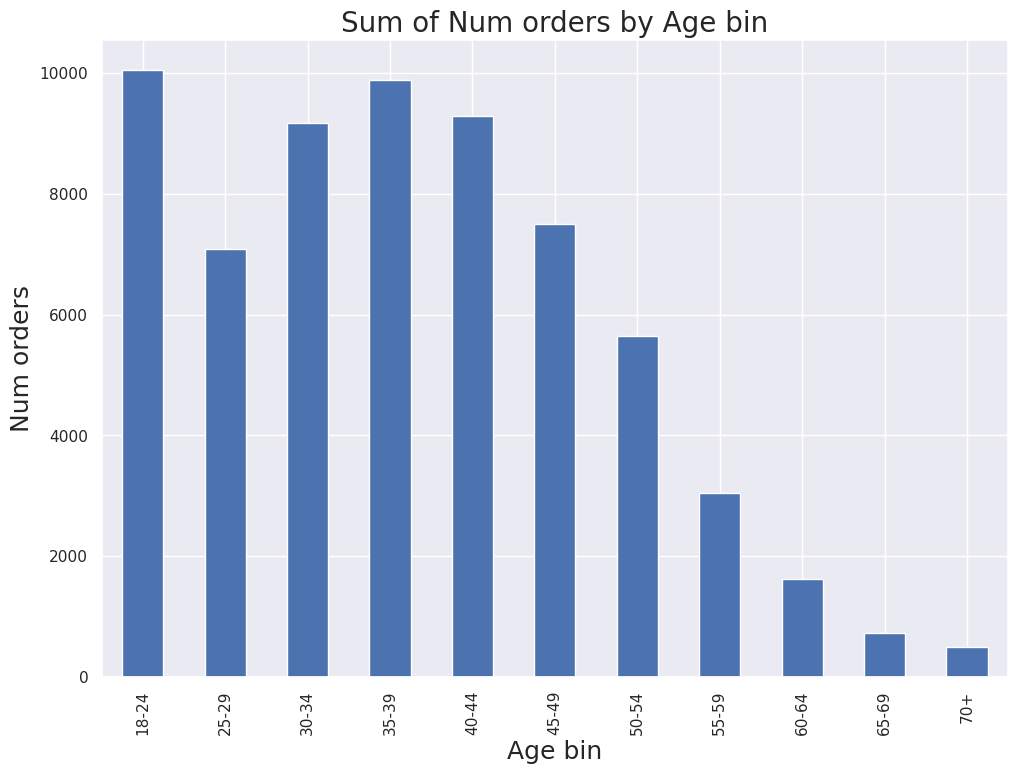

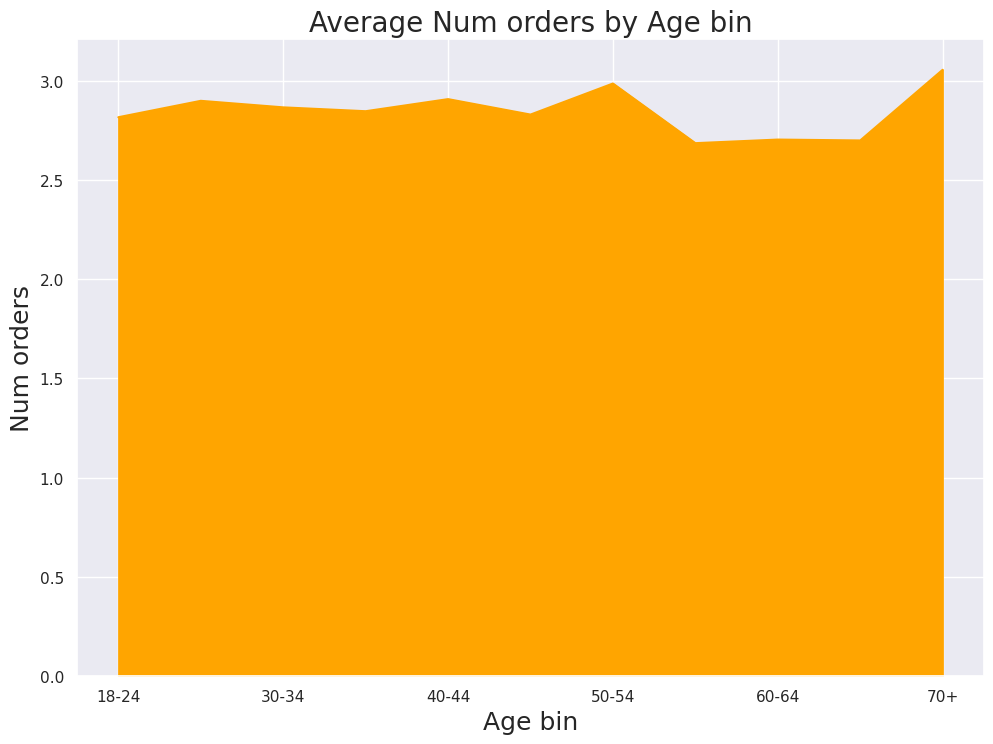

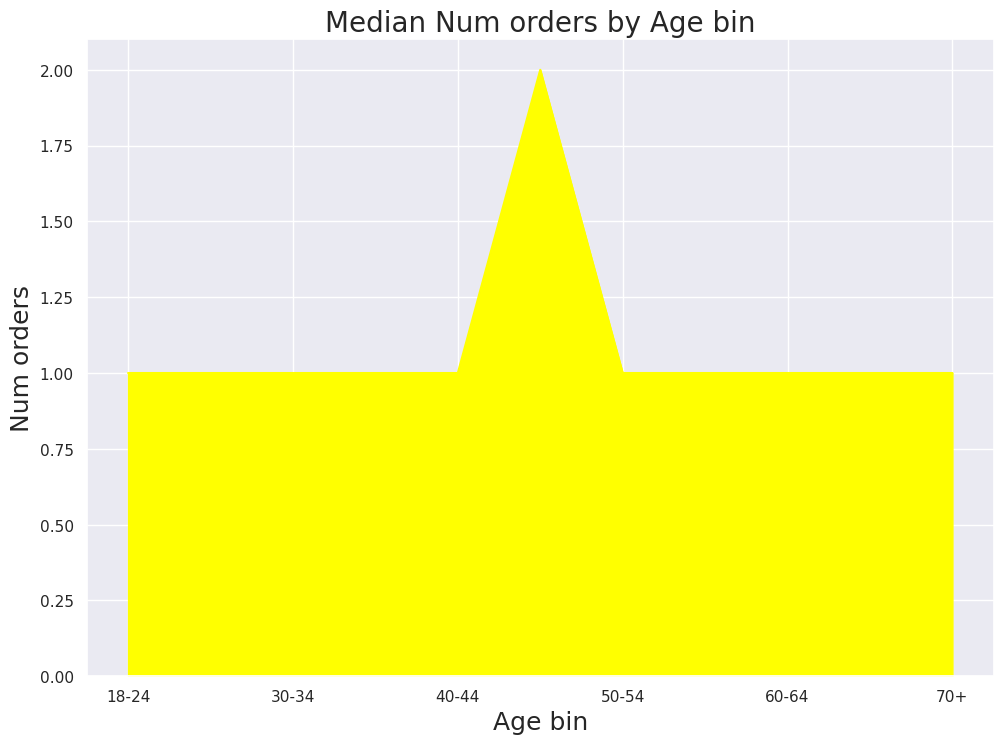

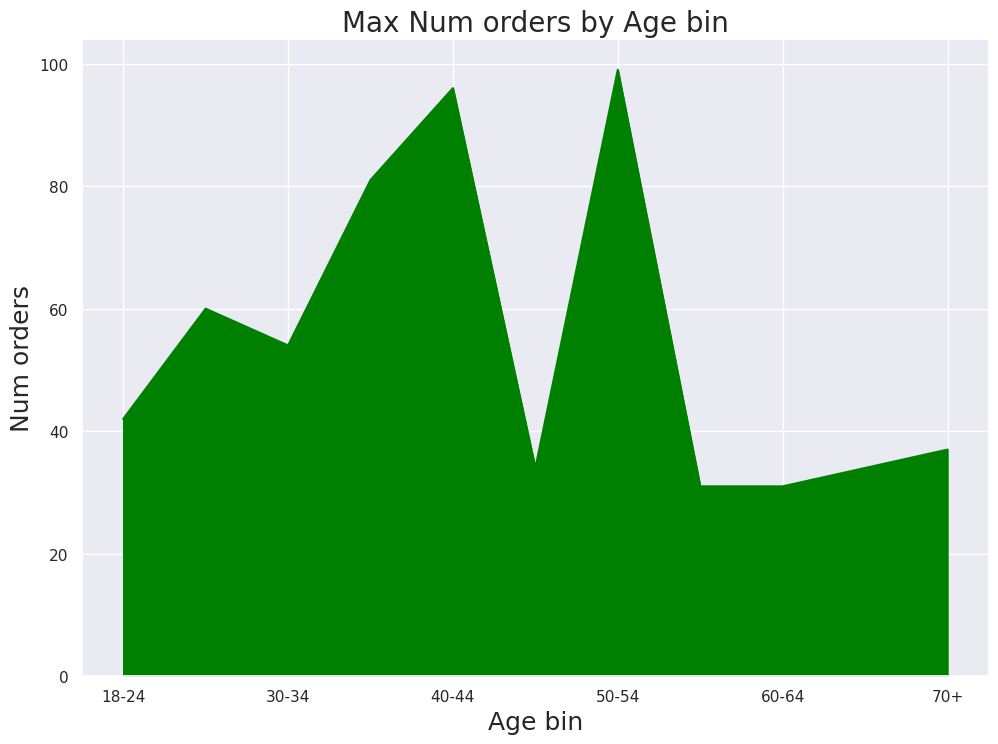

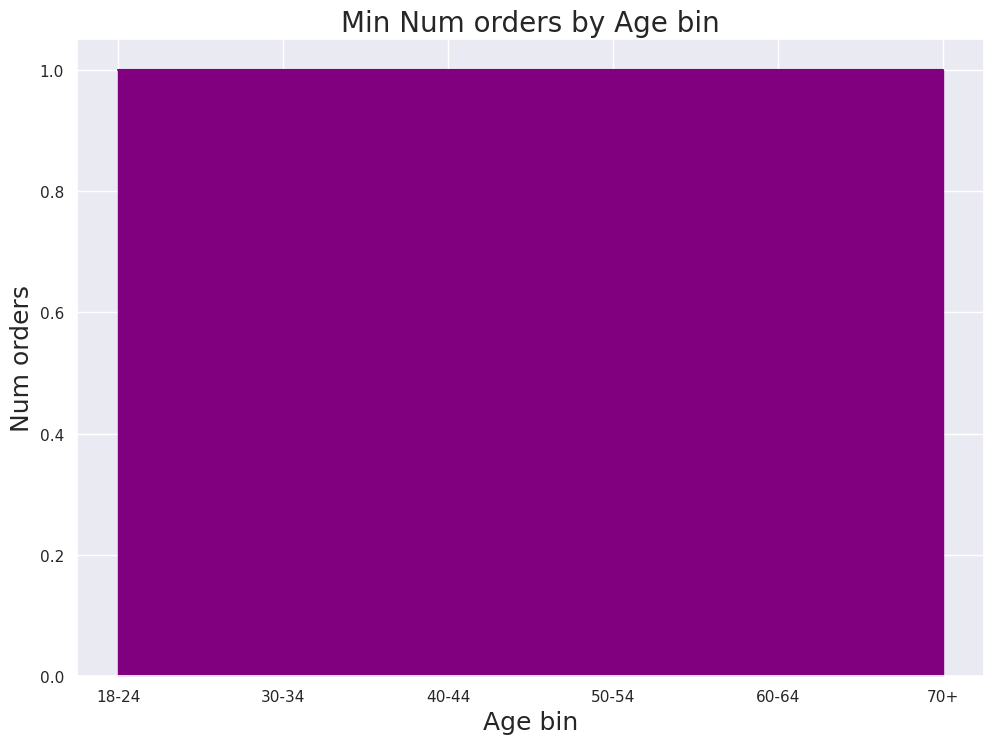

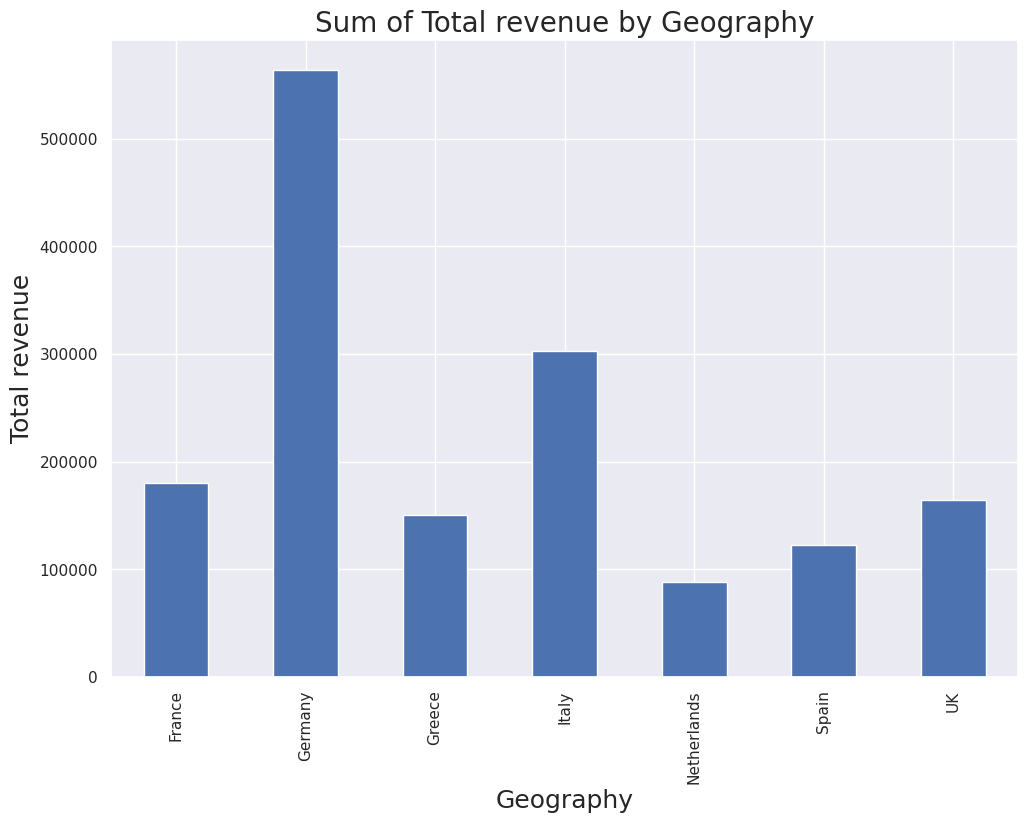

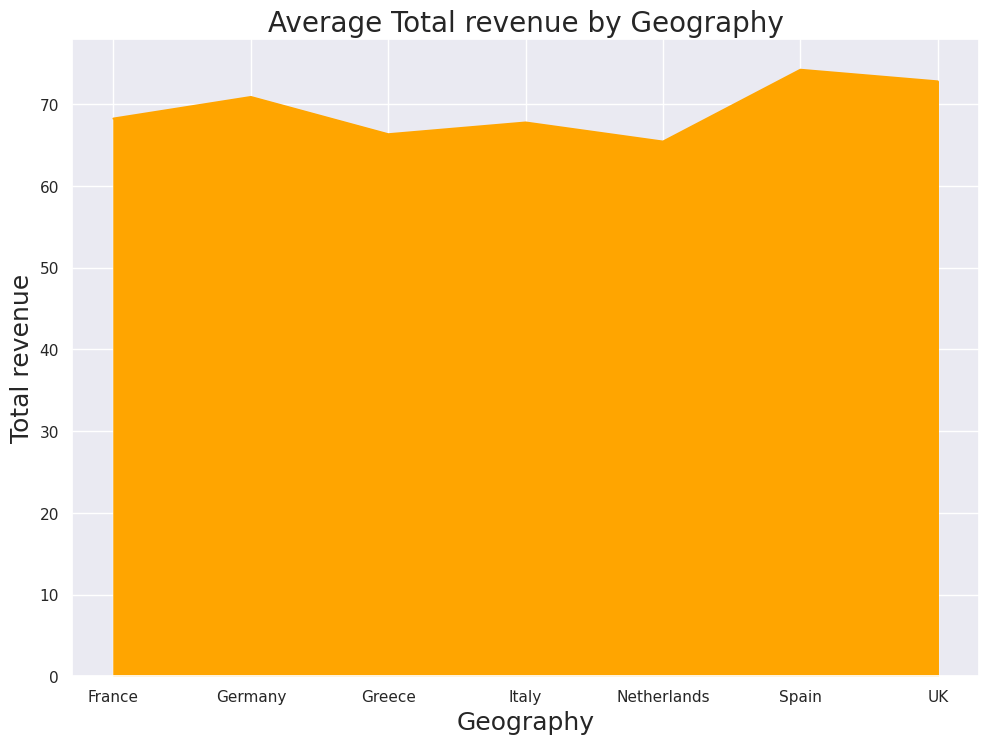

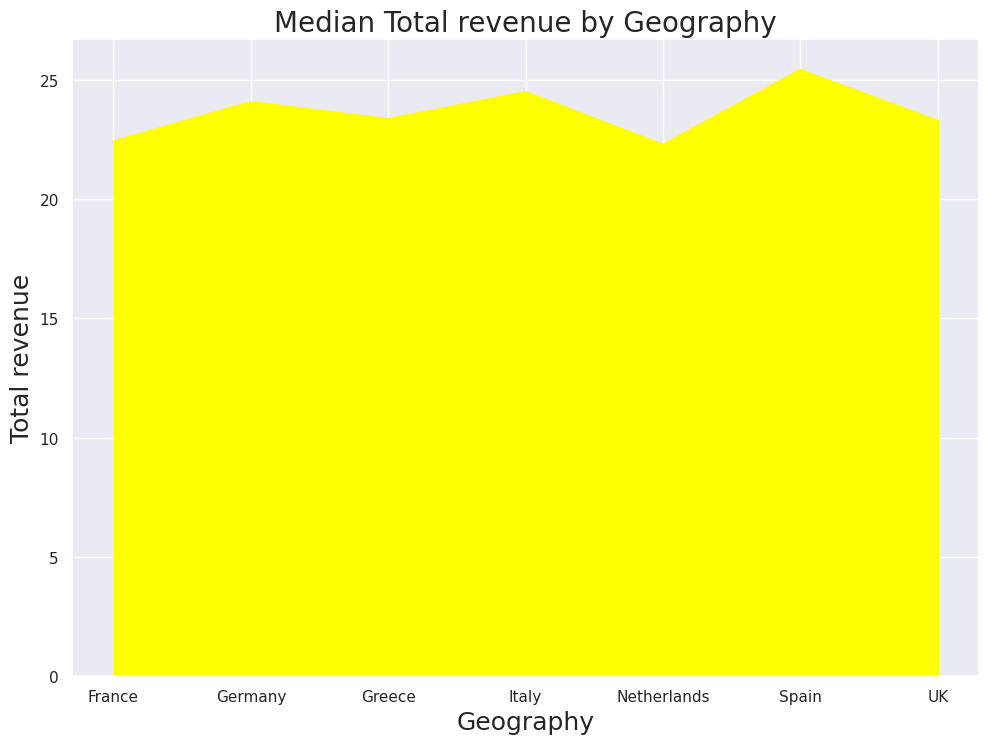

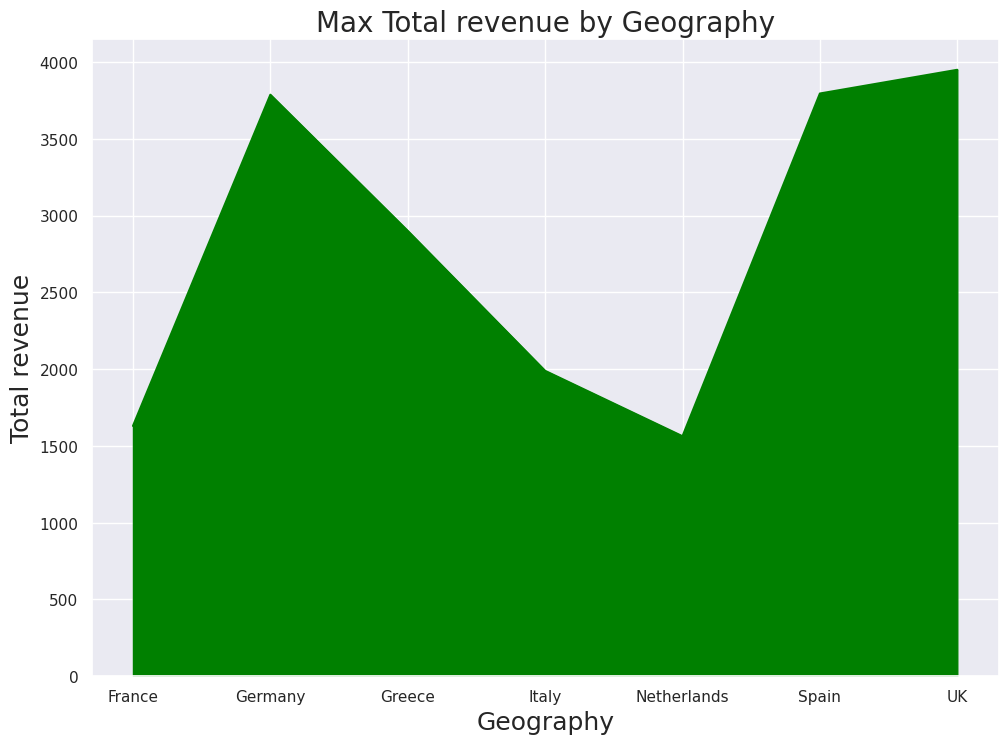

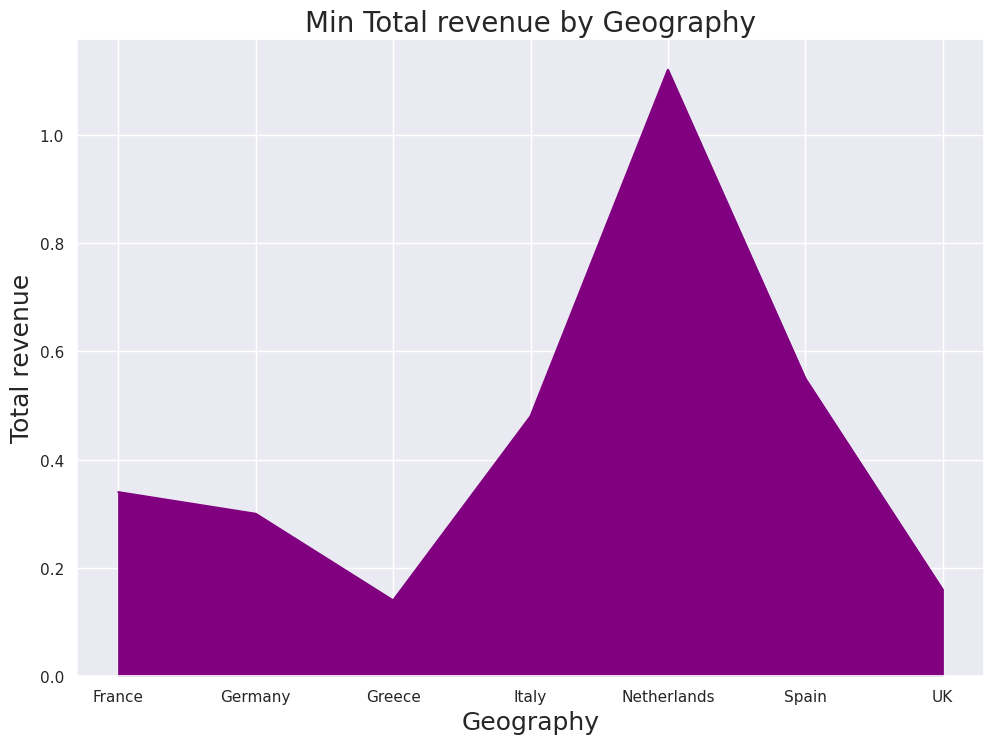

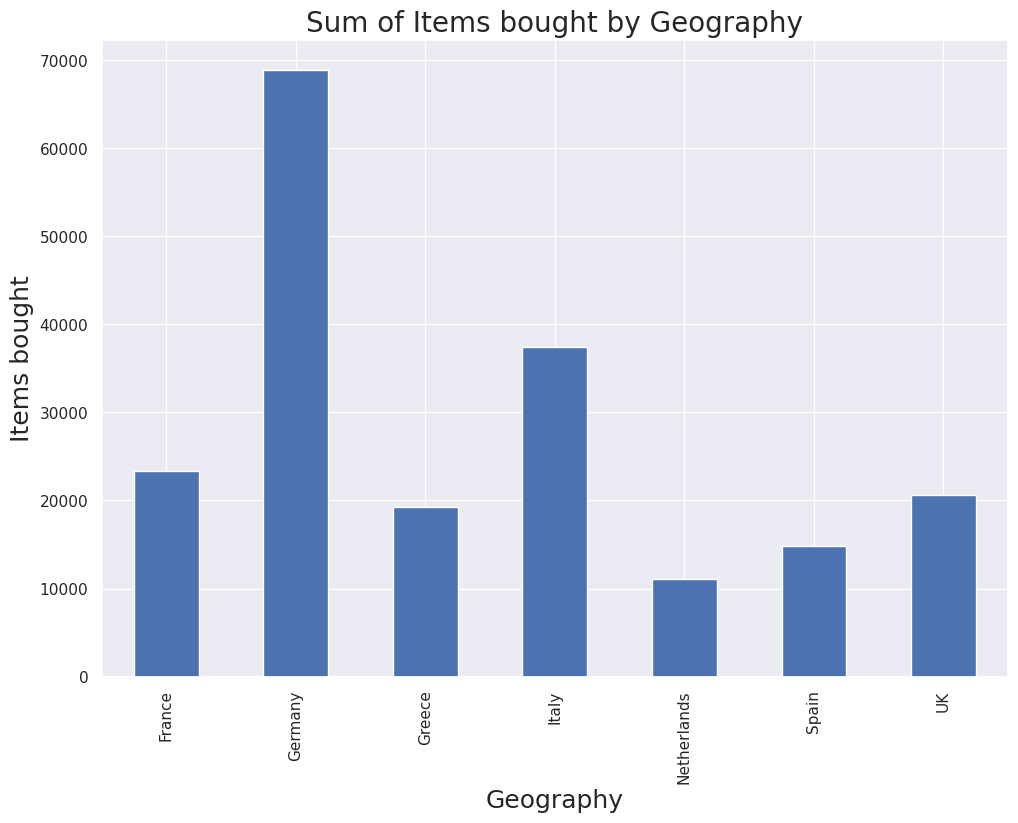

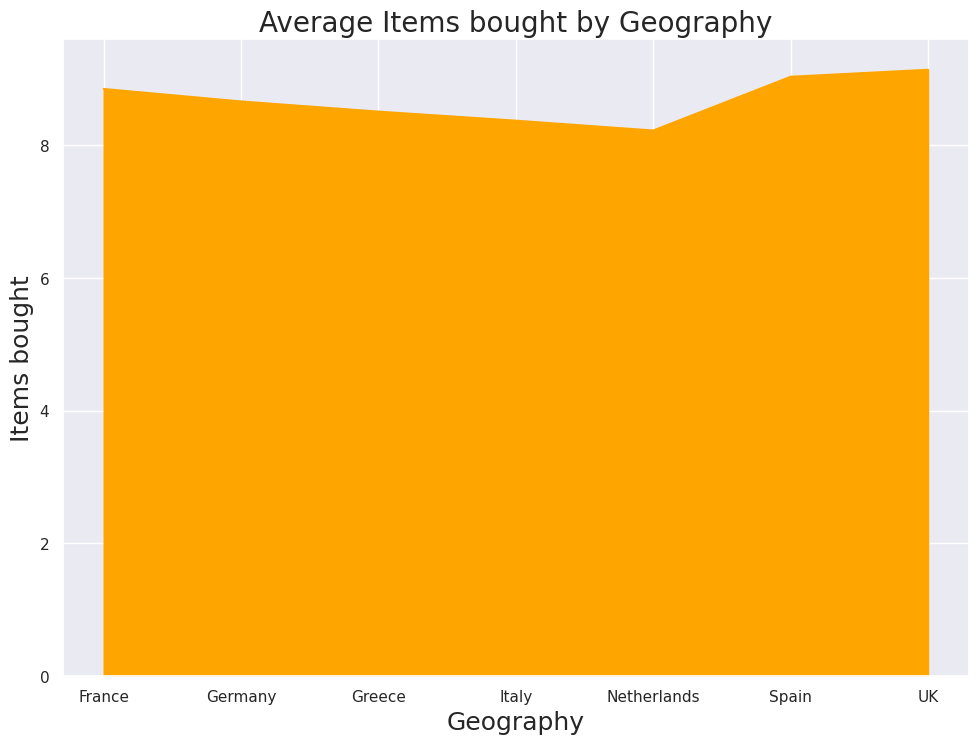

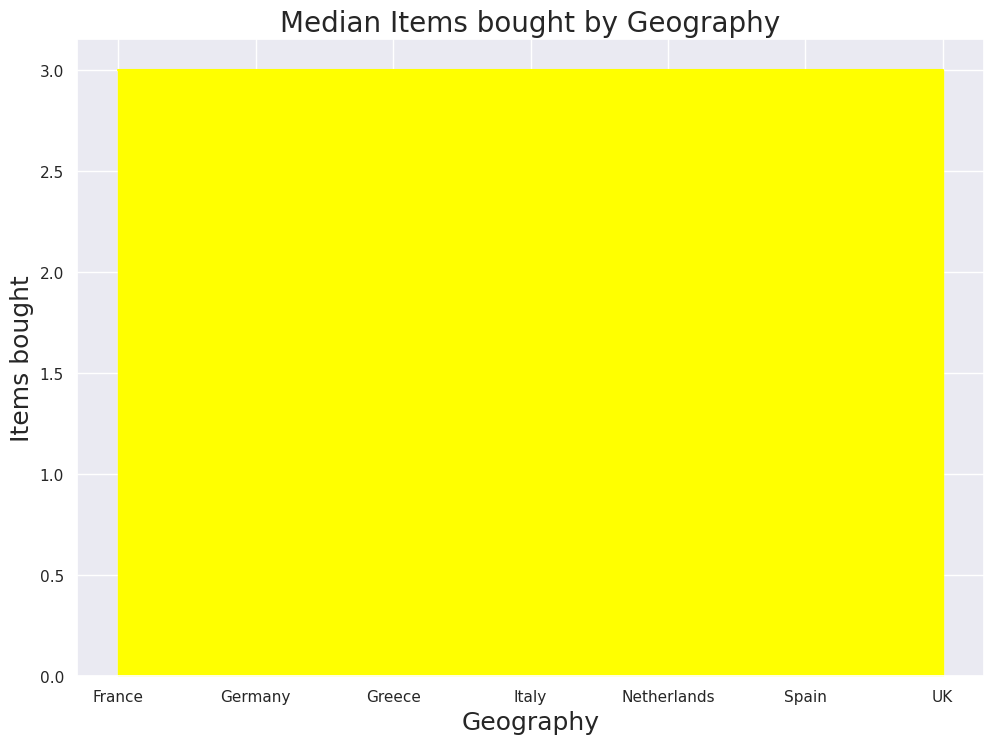

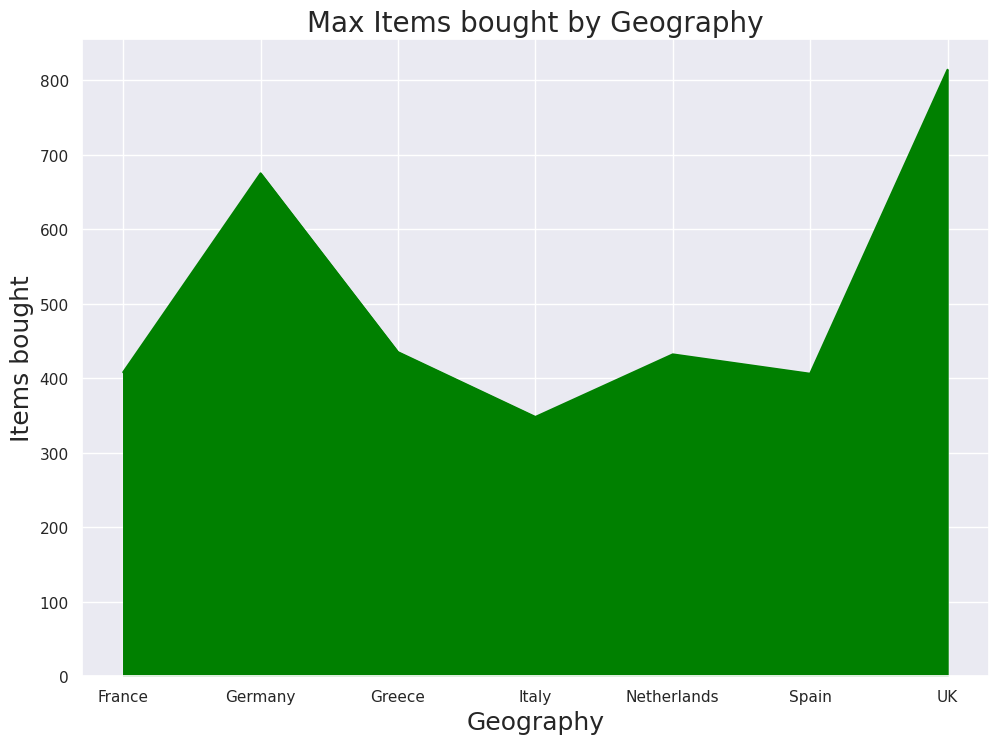

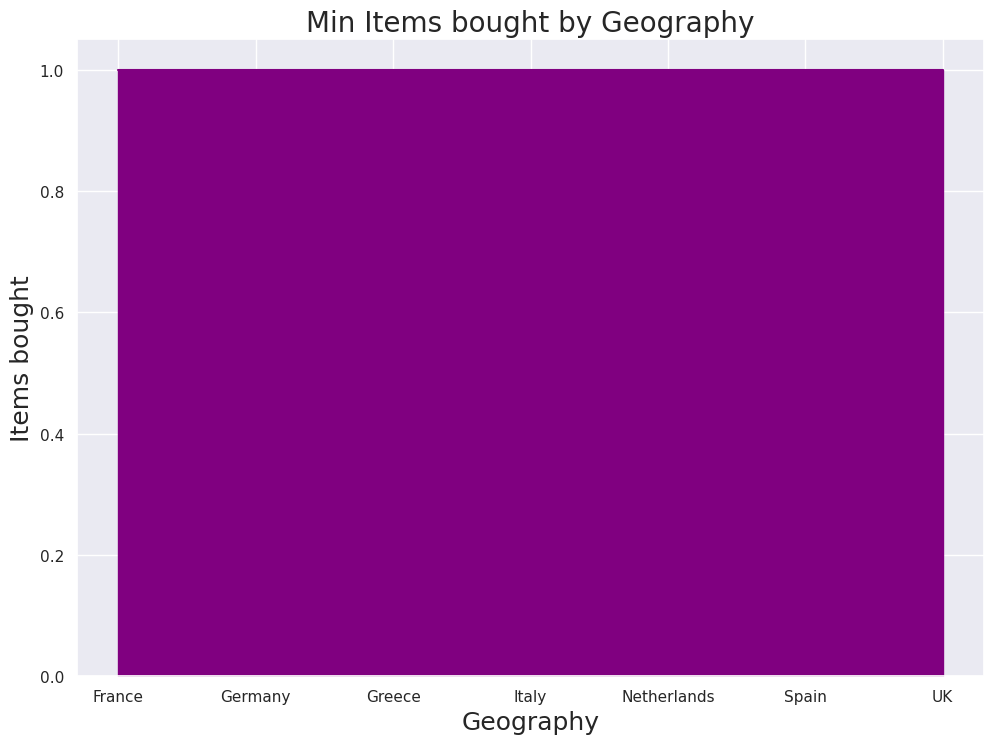

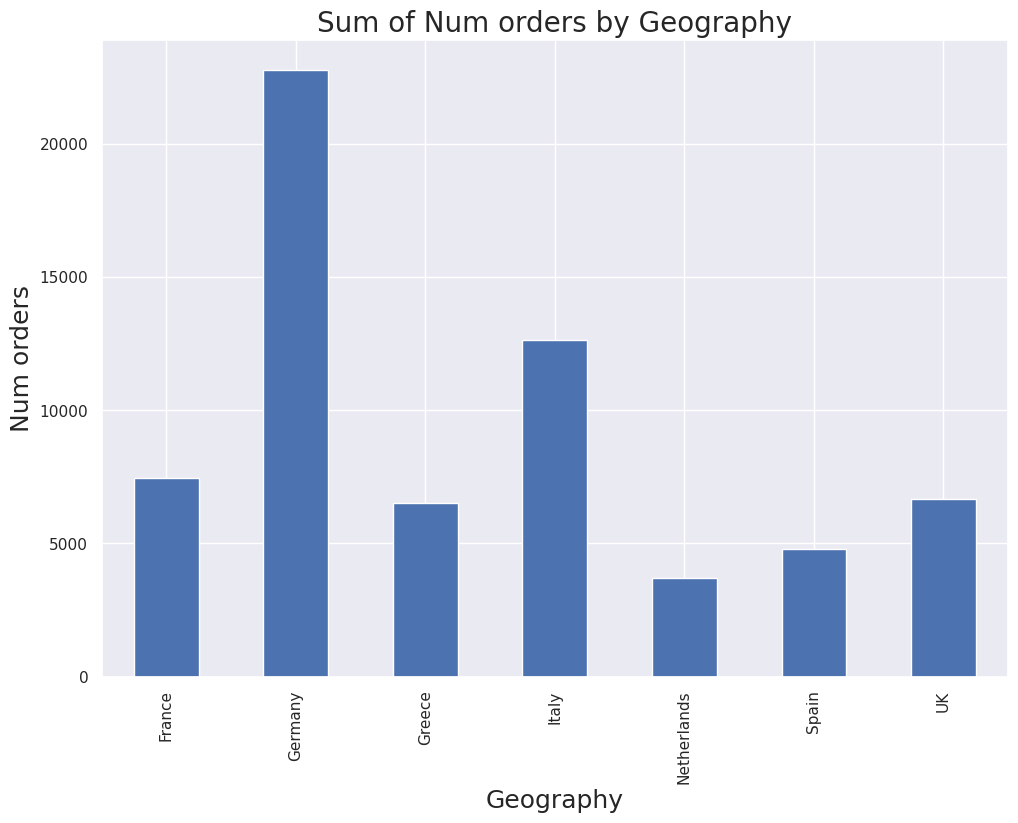

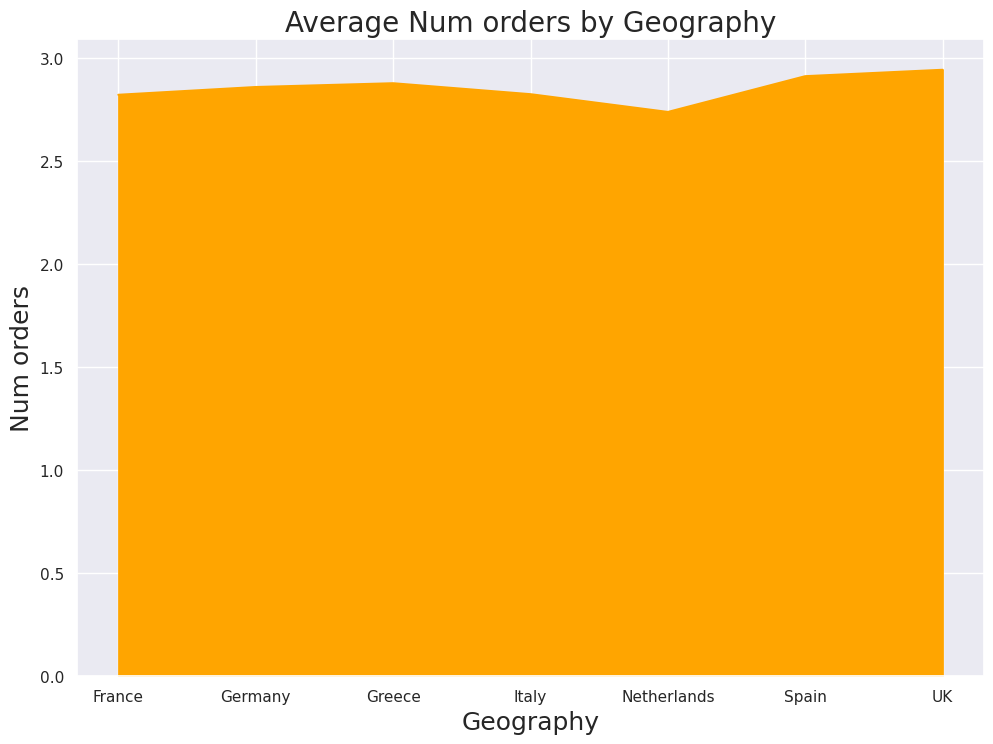

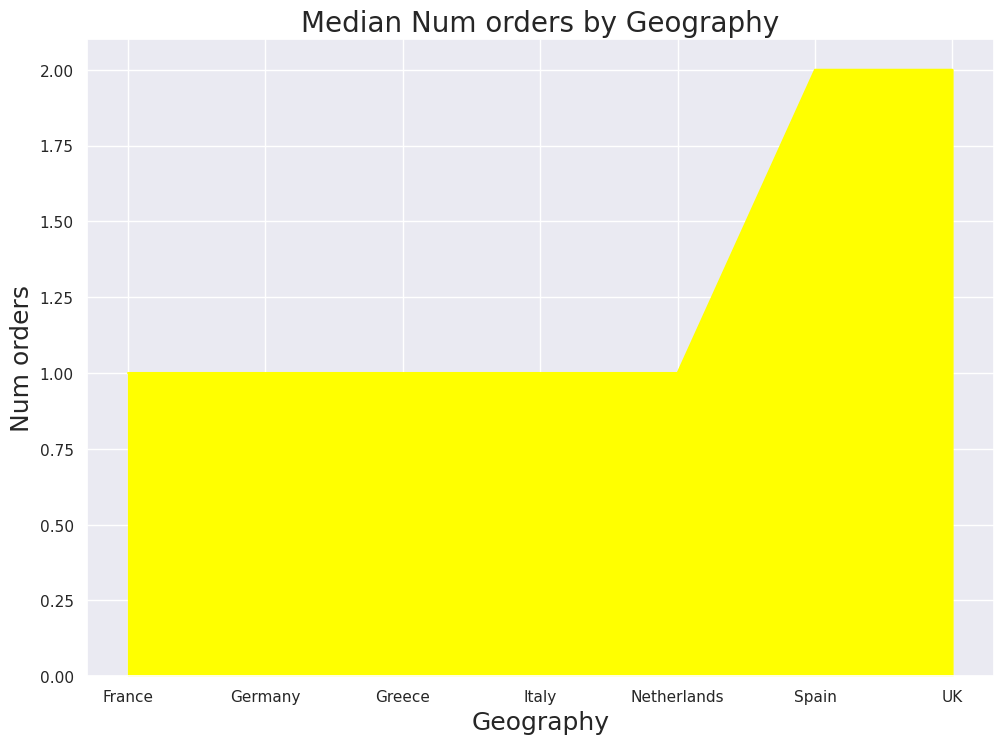

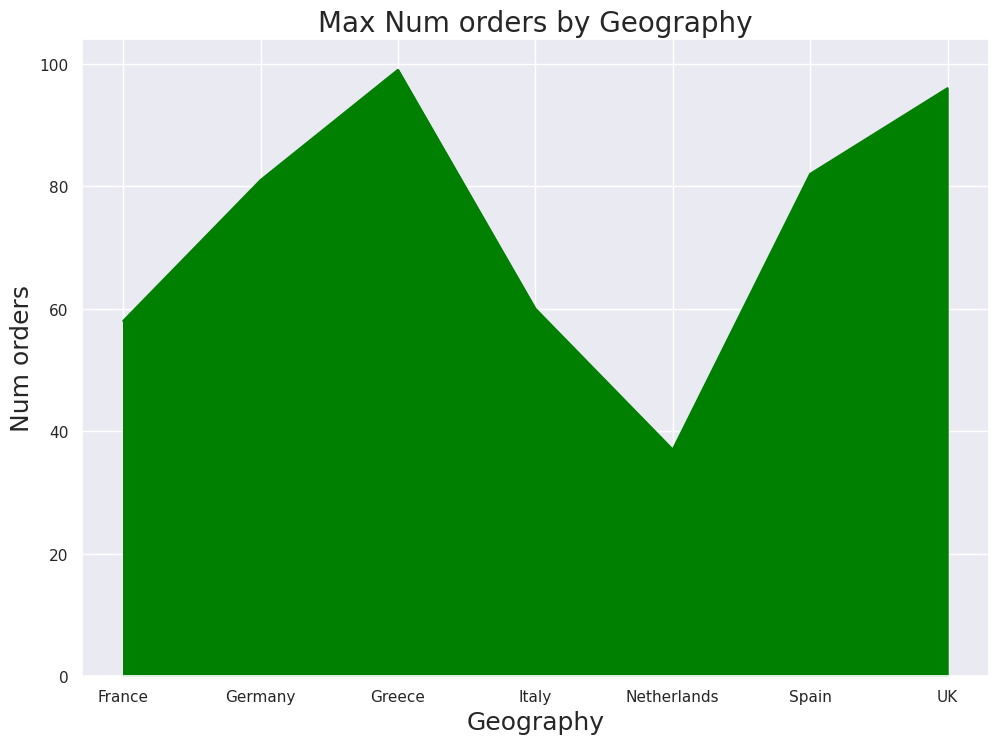

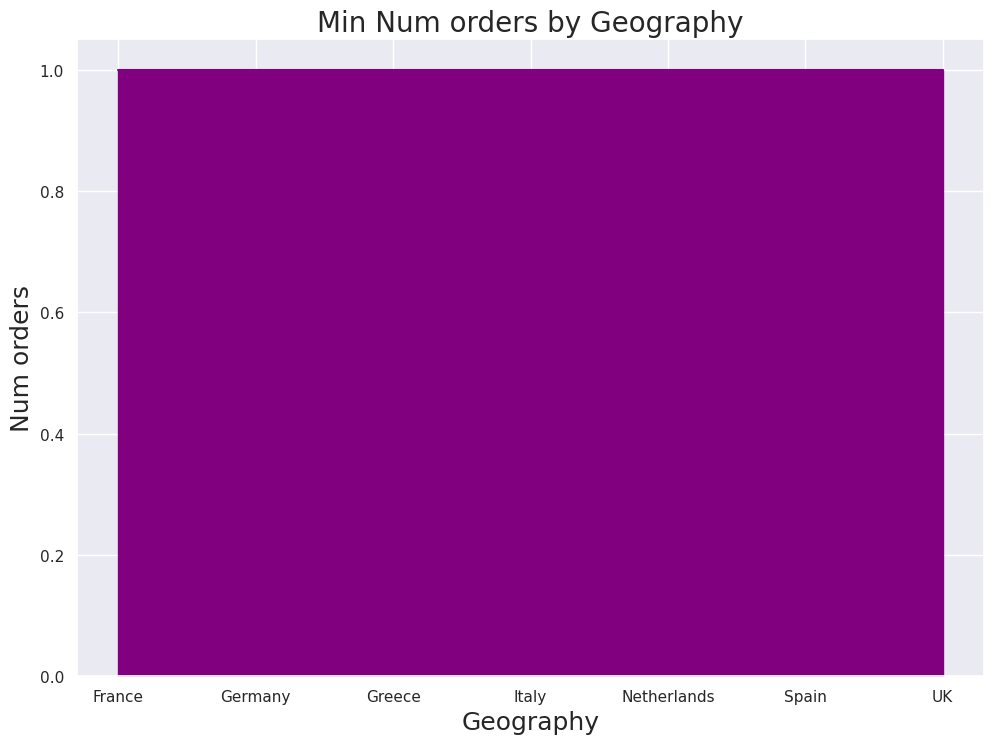

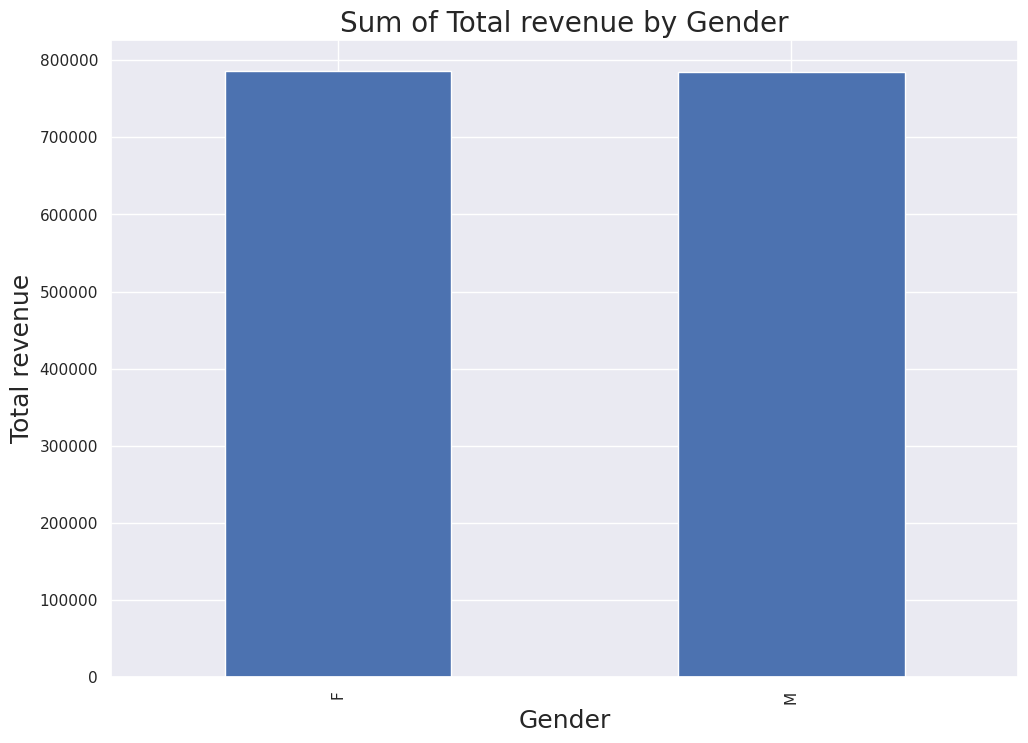

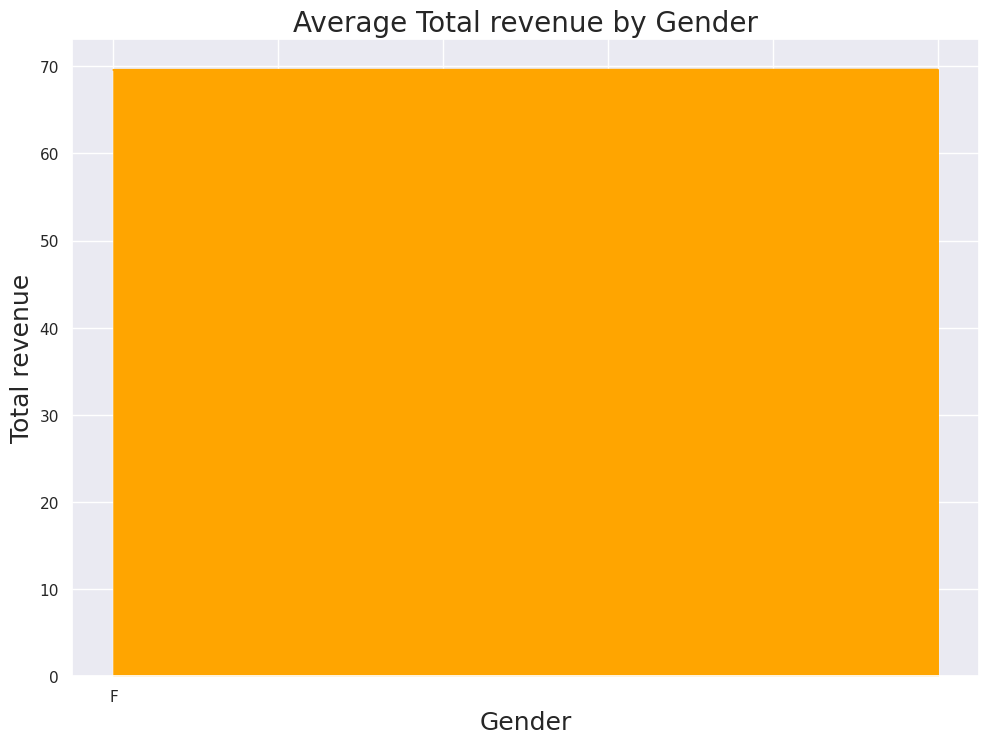

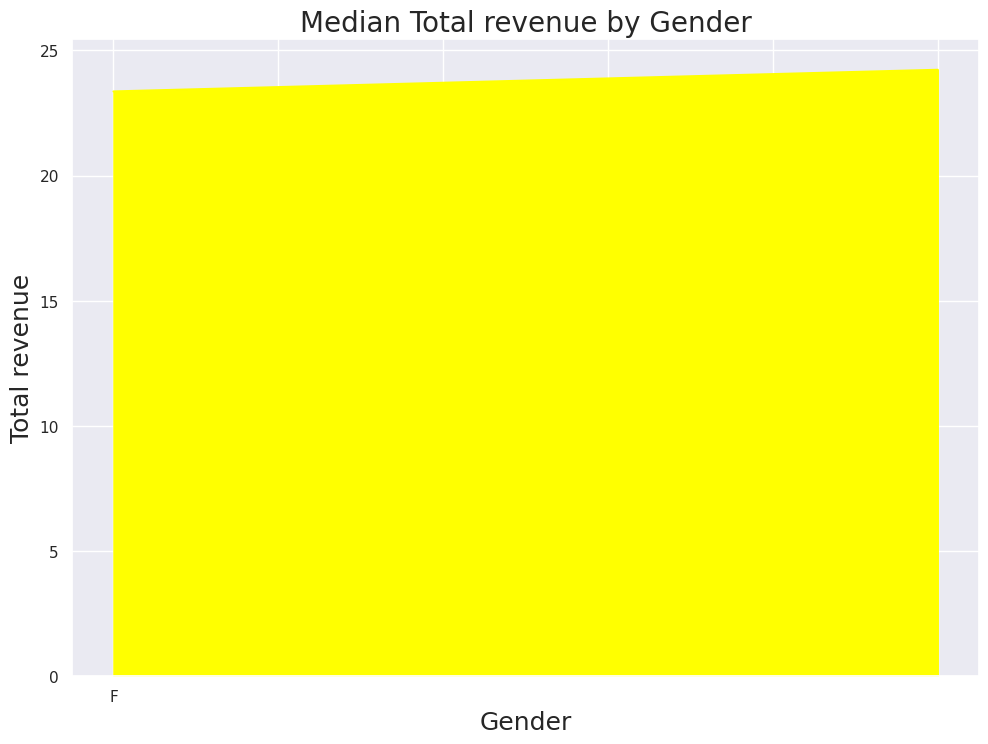

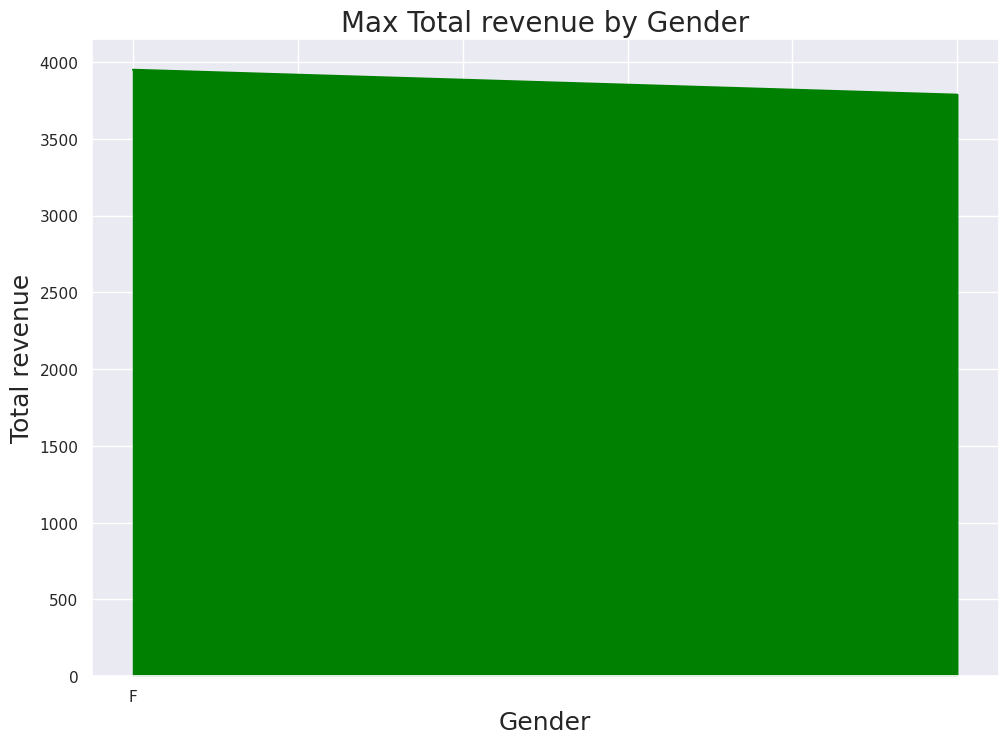

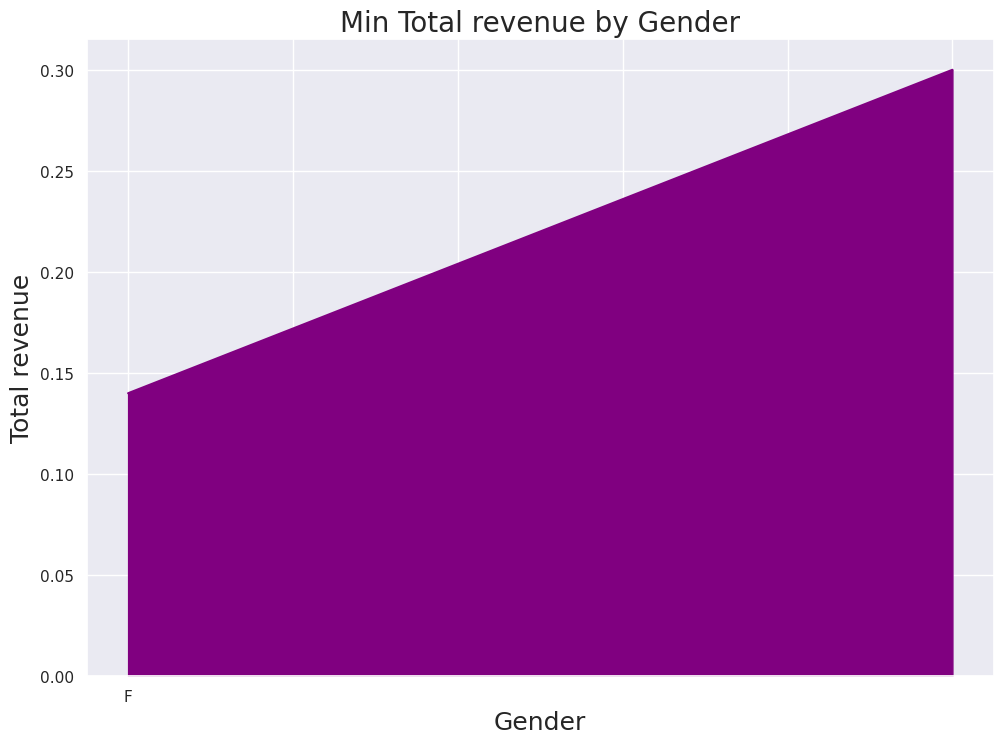

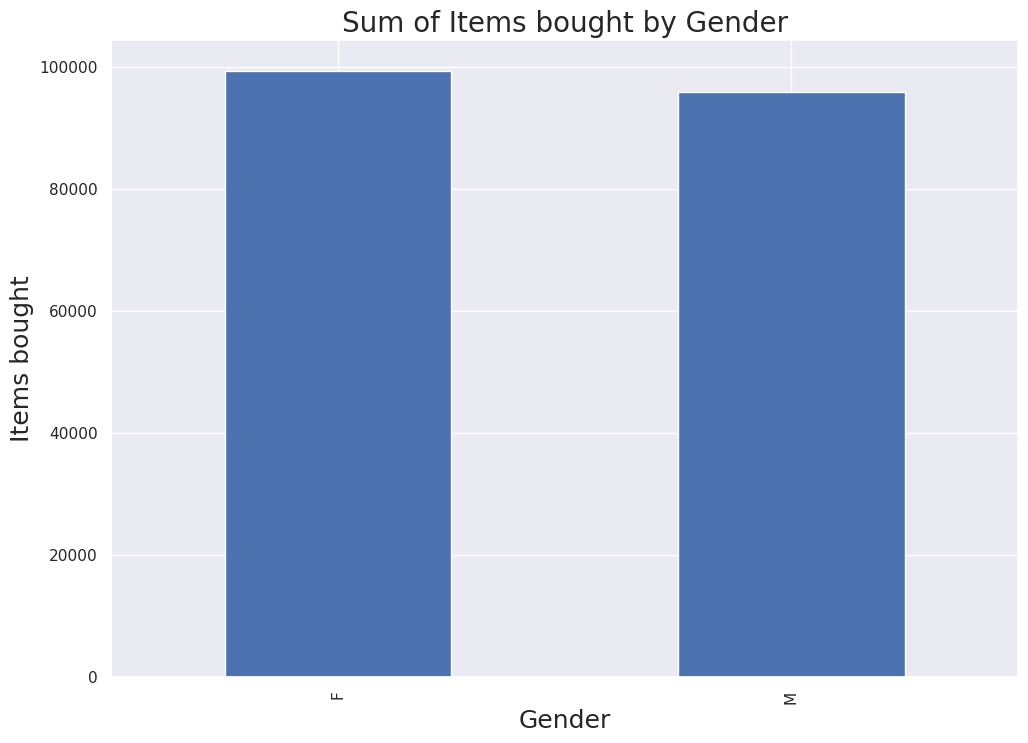

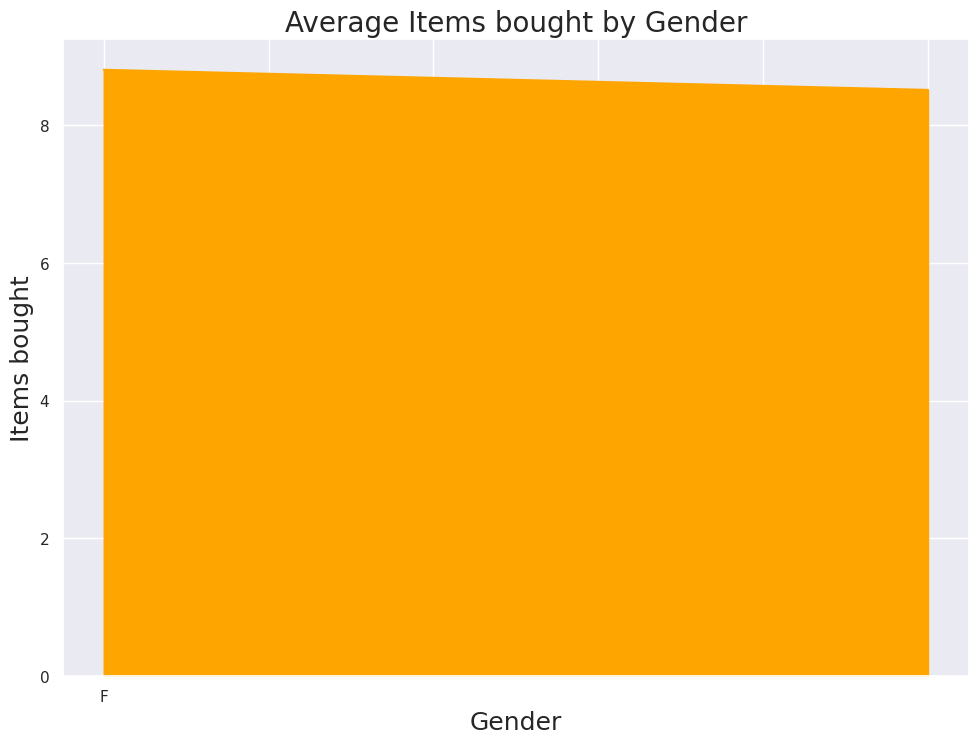

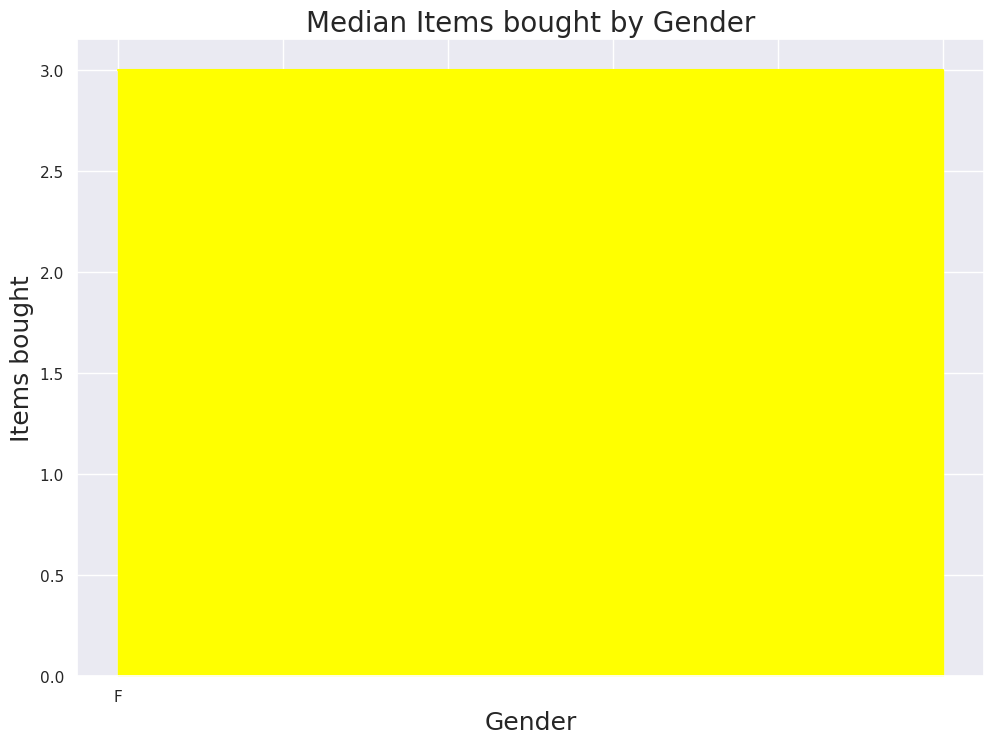

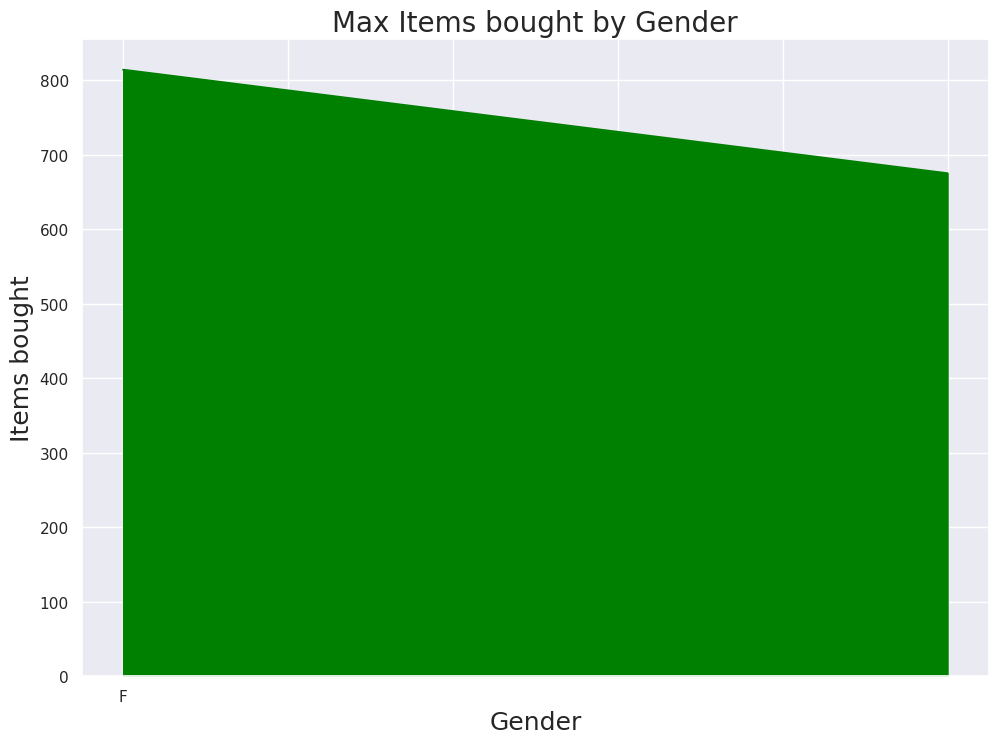

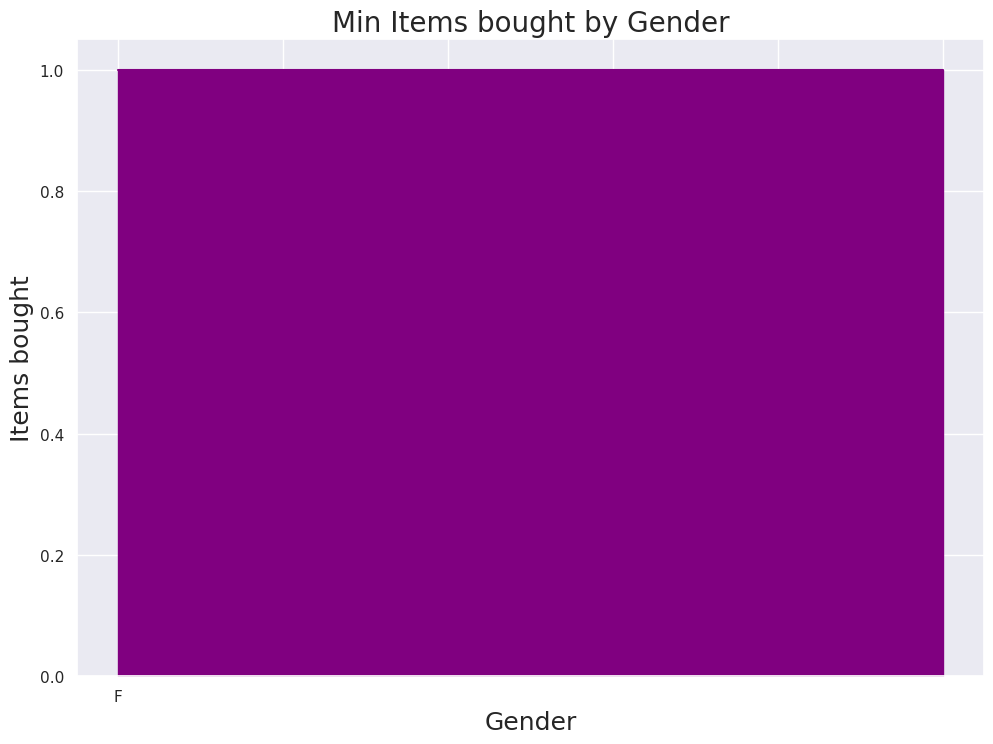

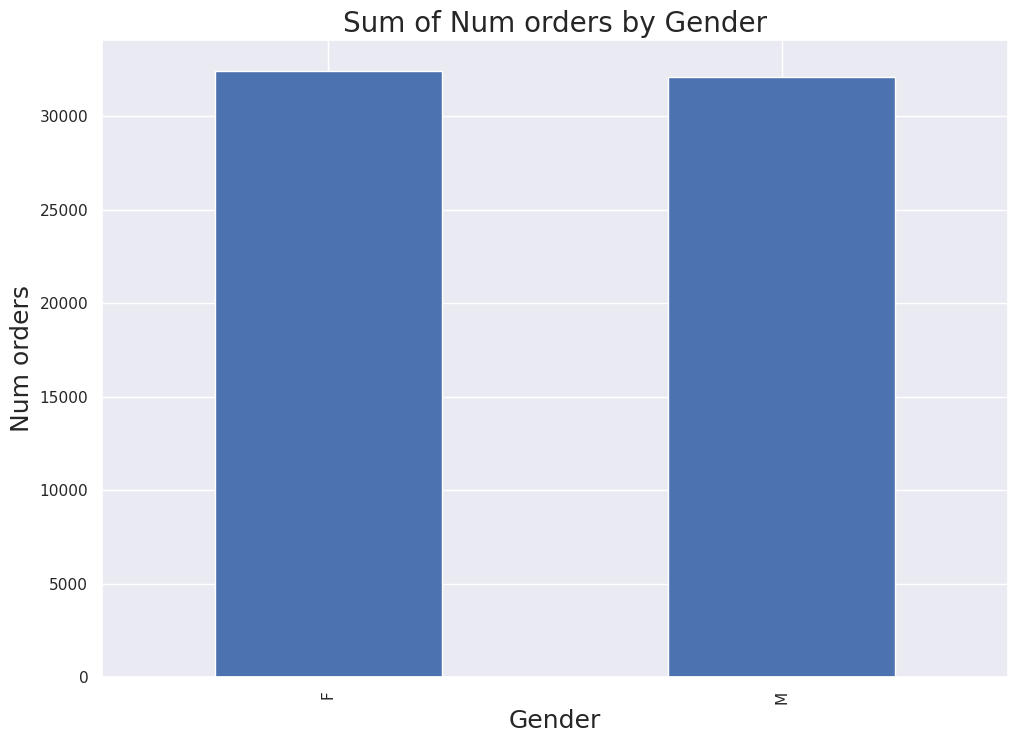

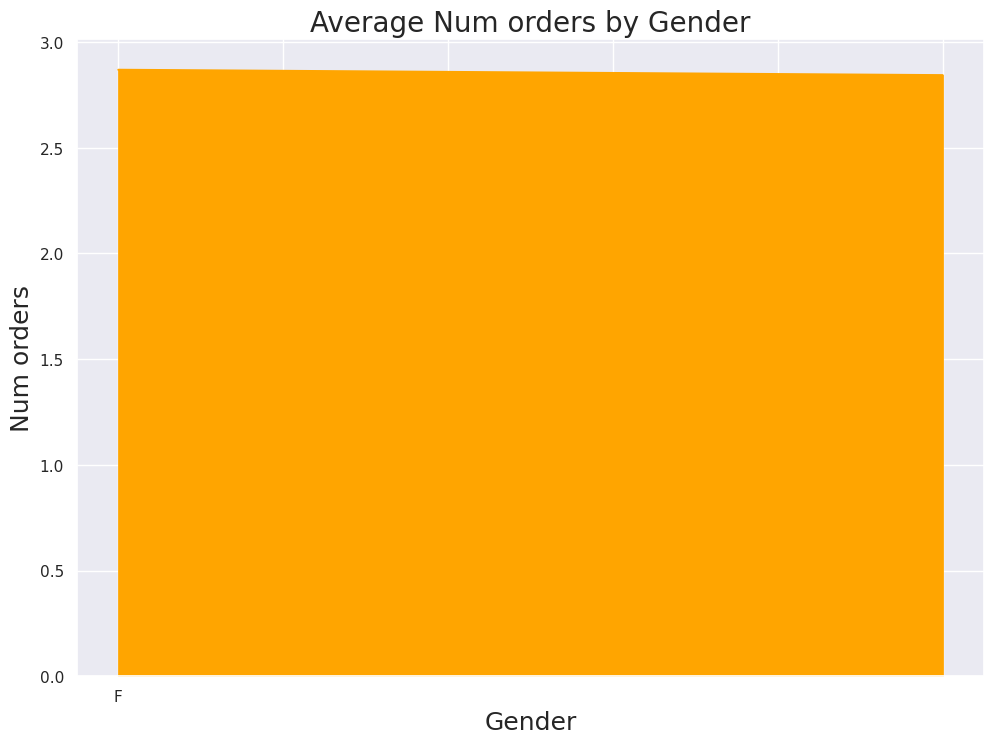

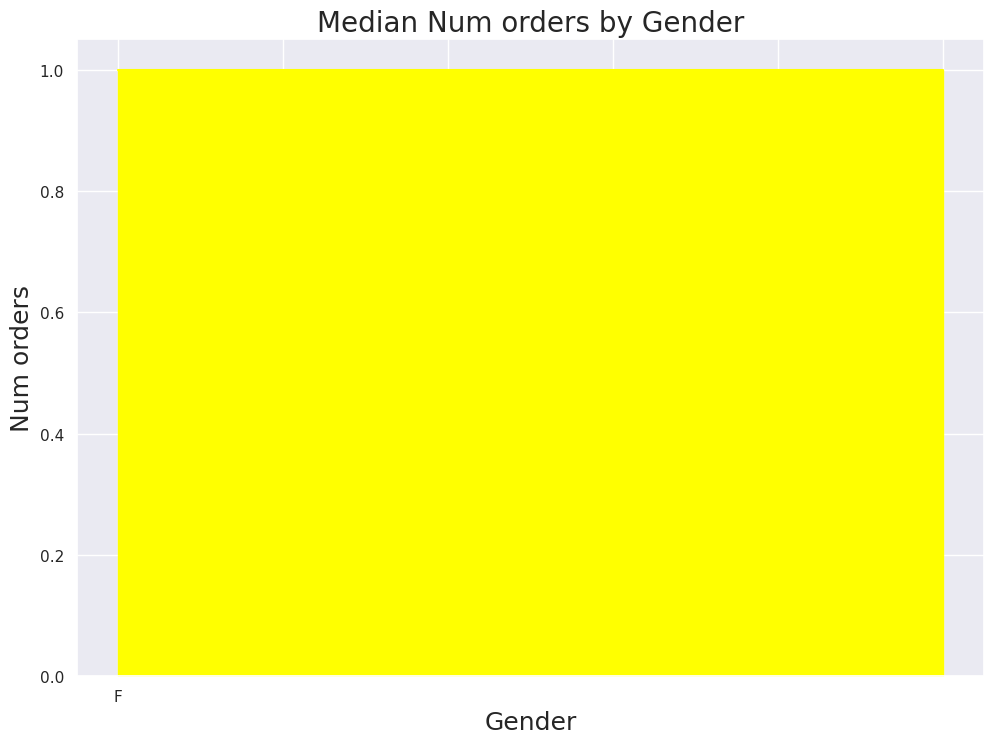

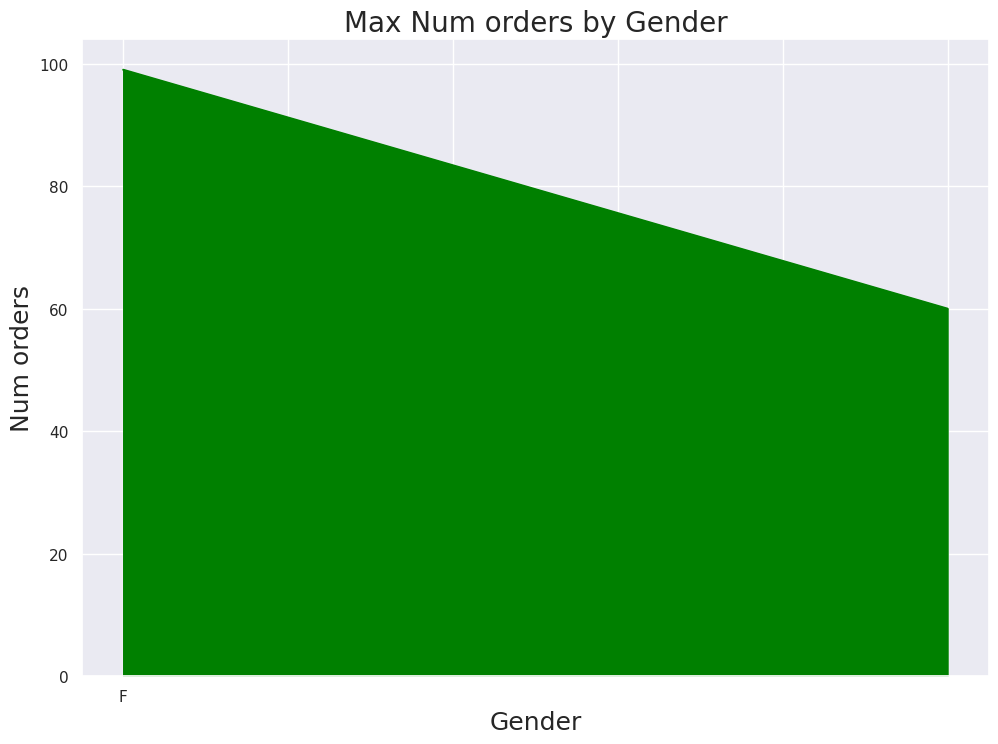

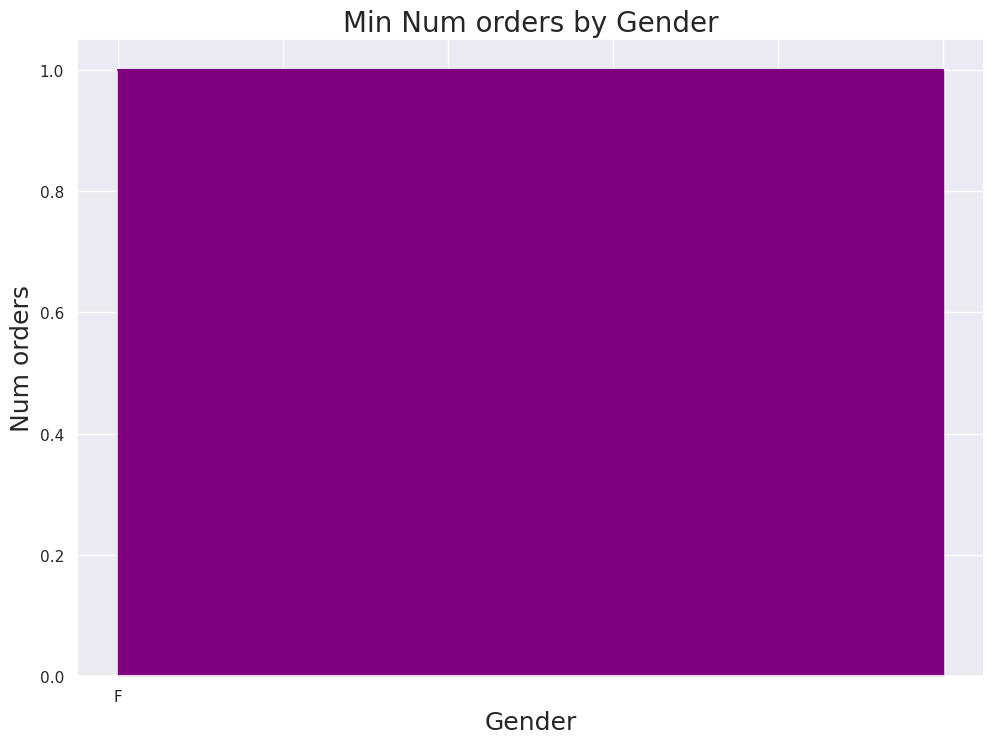

In [96]:
plot_statistical_data(customers_df, ['age_bin','GEOGRAPHY', 'GENDER'], sum_cols)

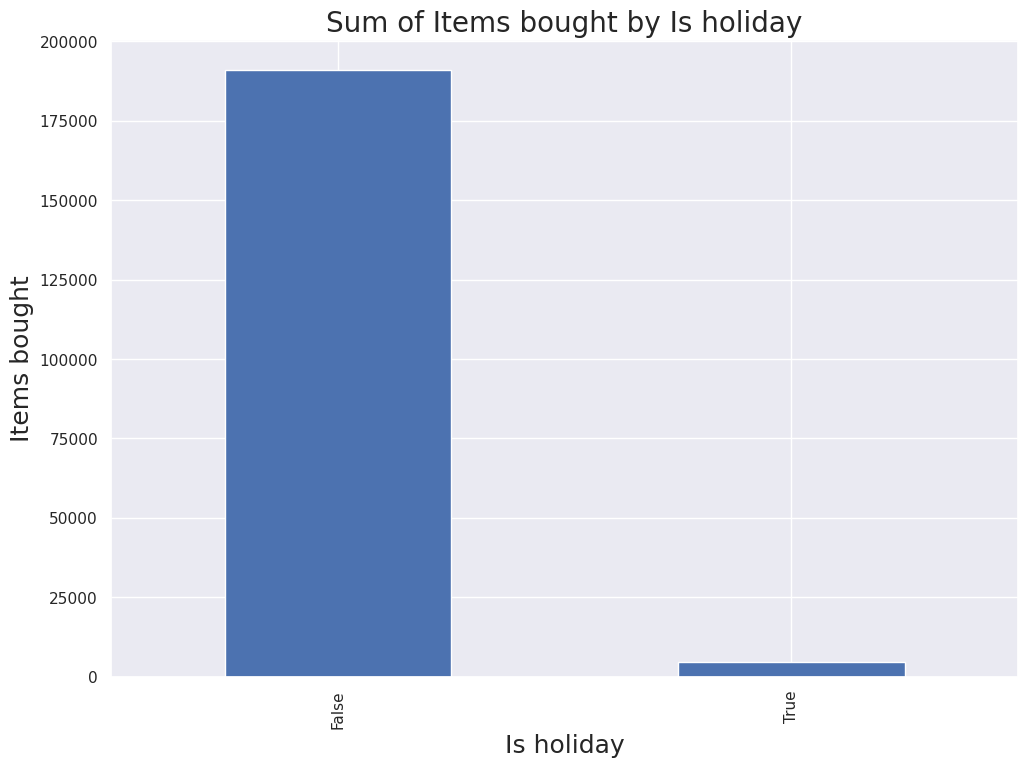

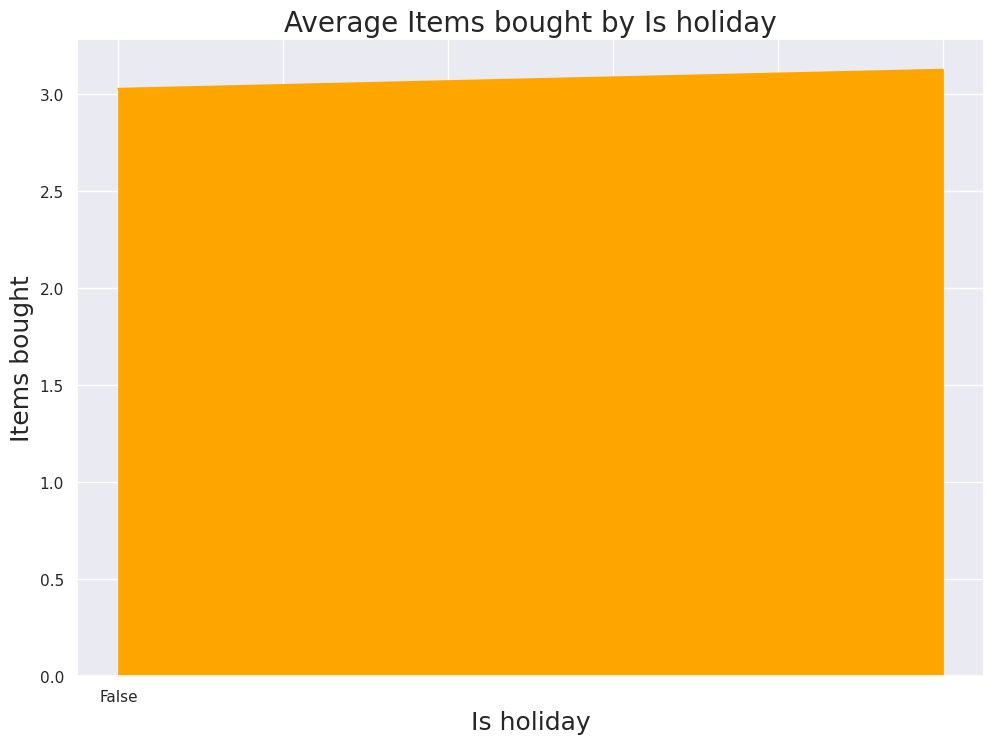

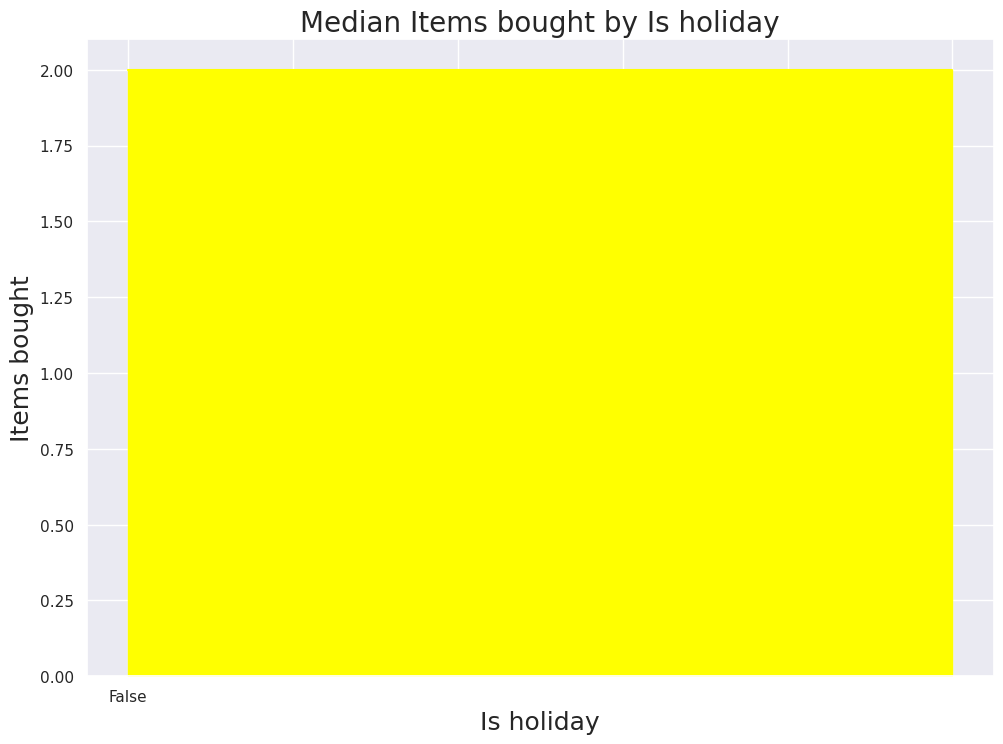

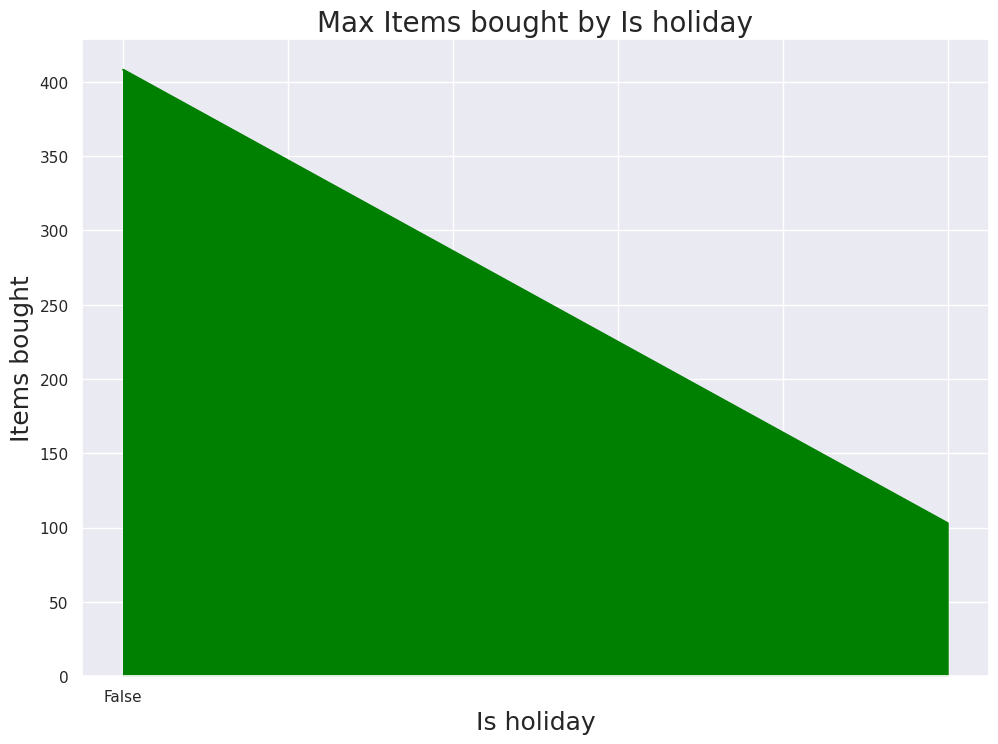

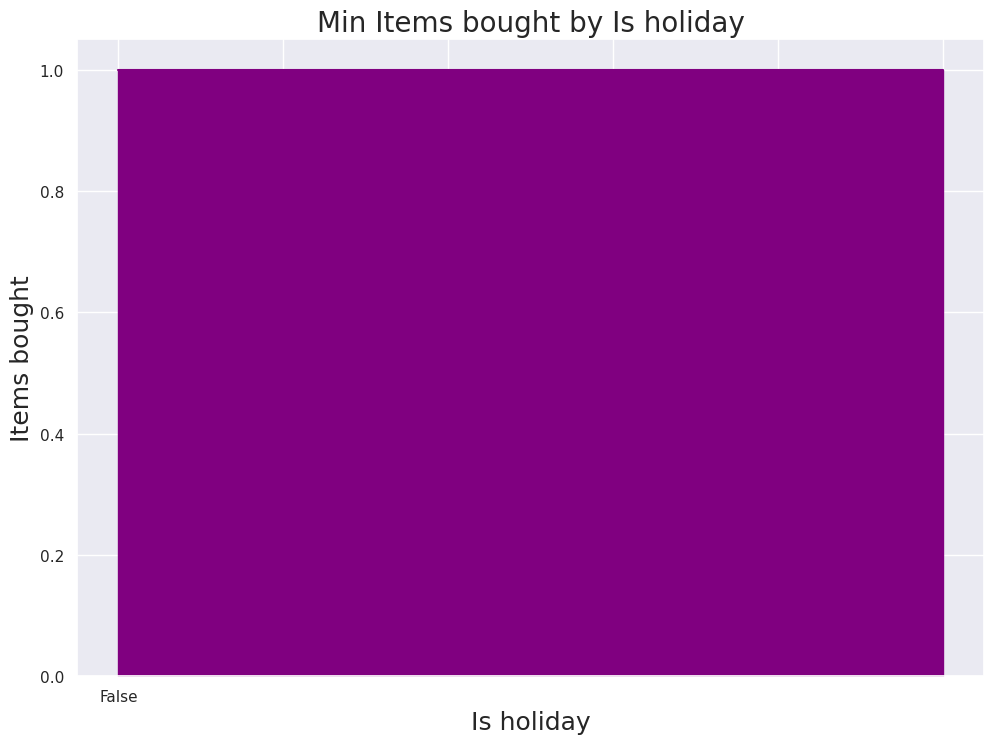

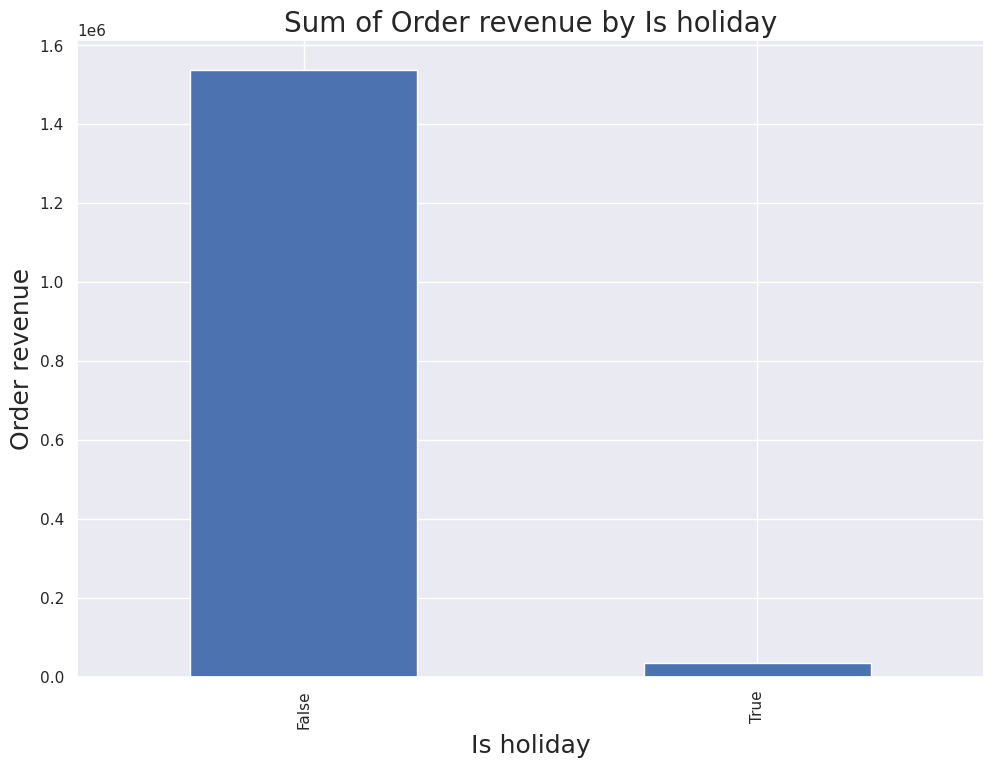

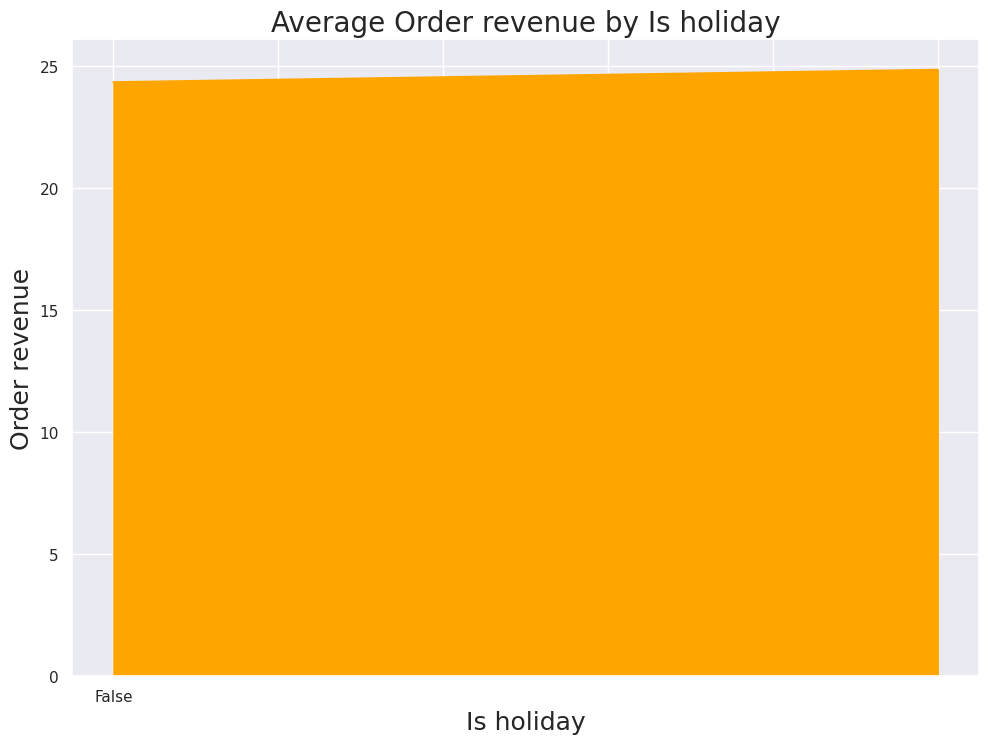

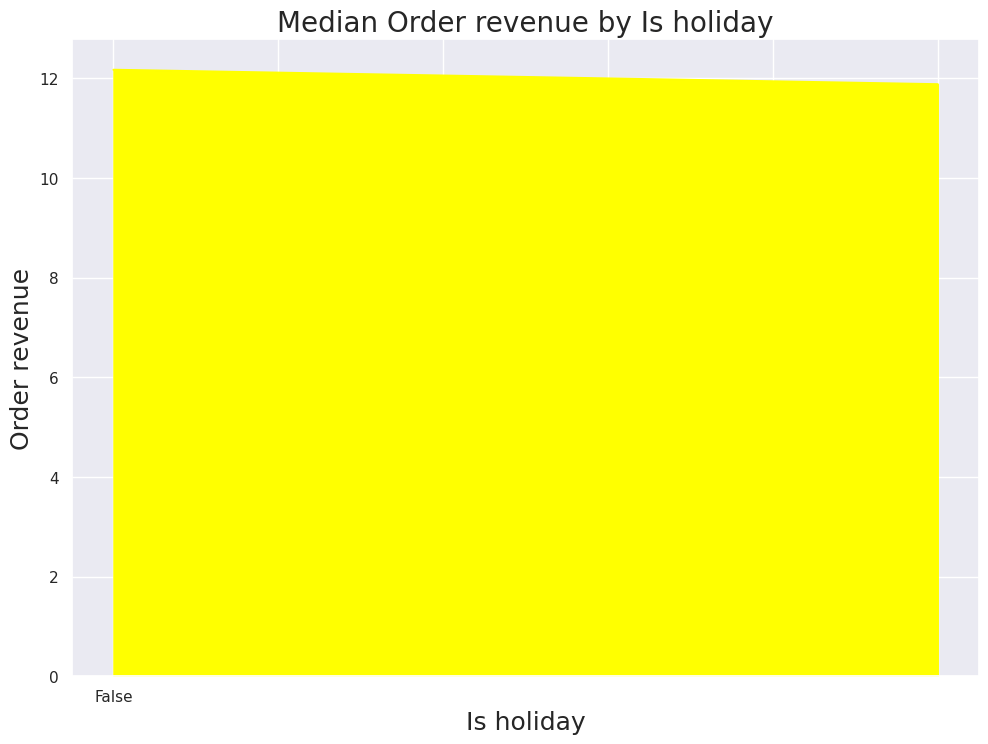

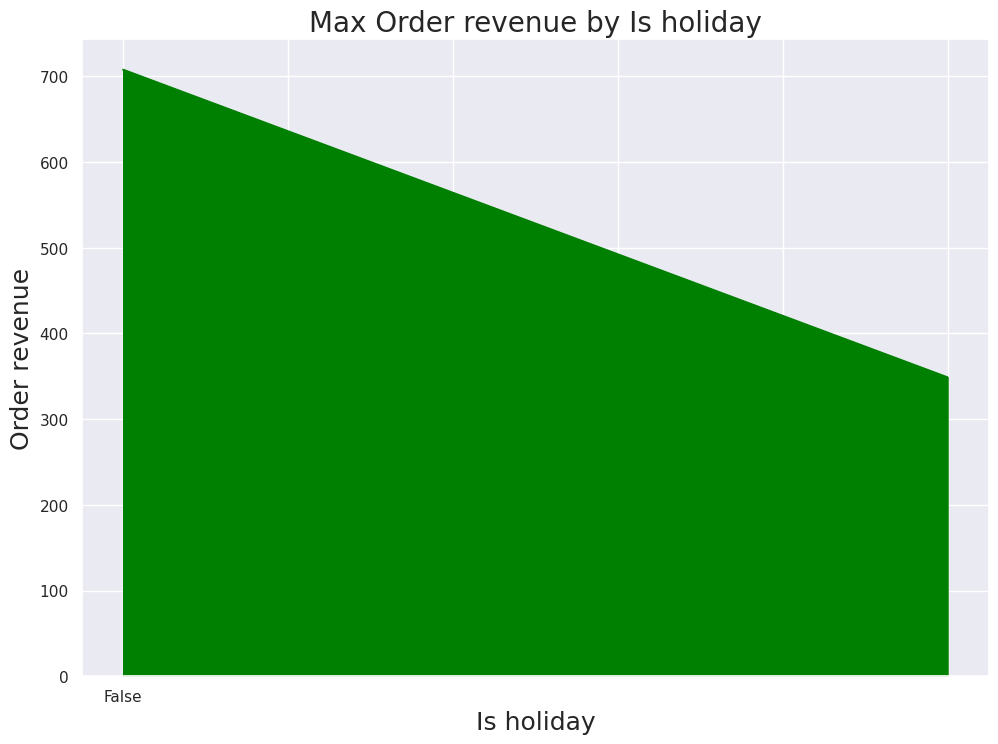

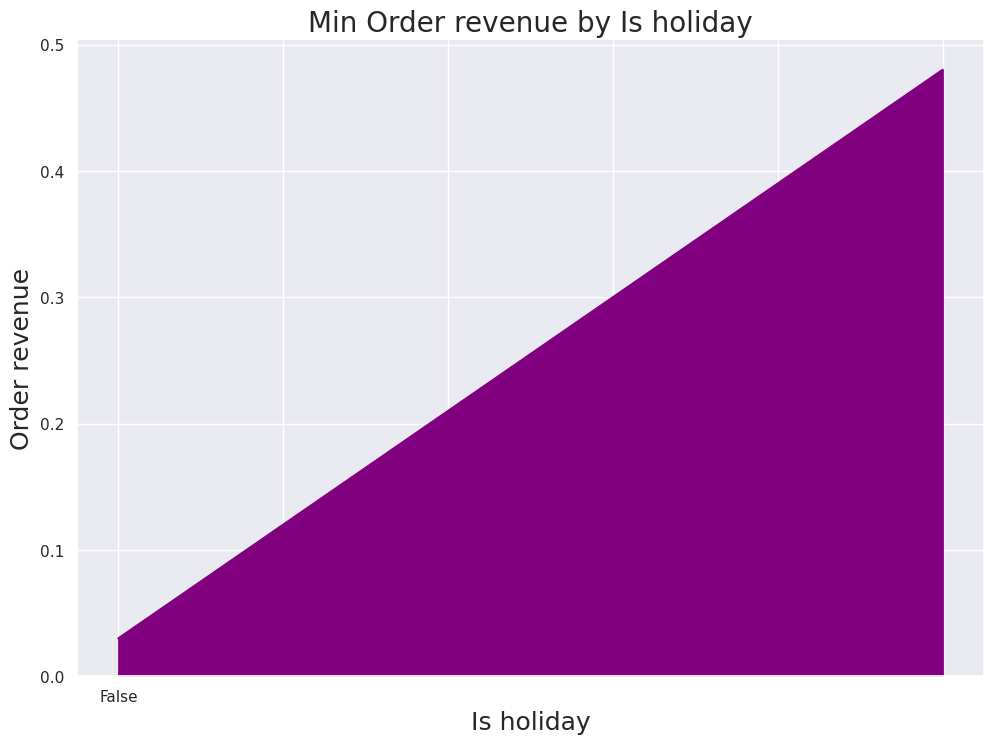

In [98]:
plot_statistical_data(transactions, ['is_holiday'], geo_sum_cols)

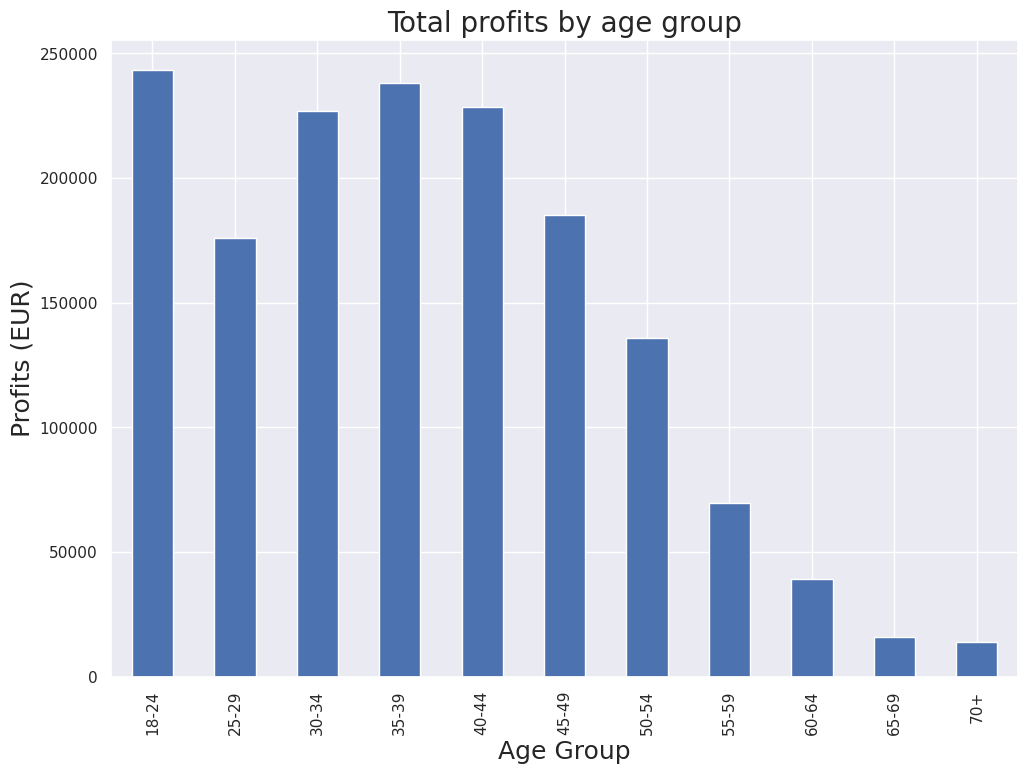

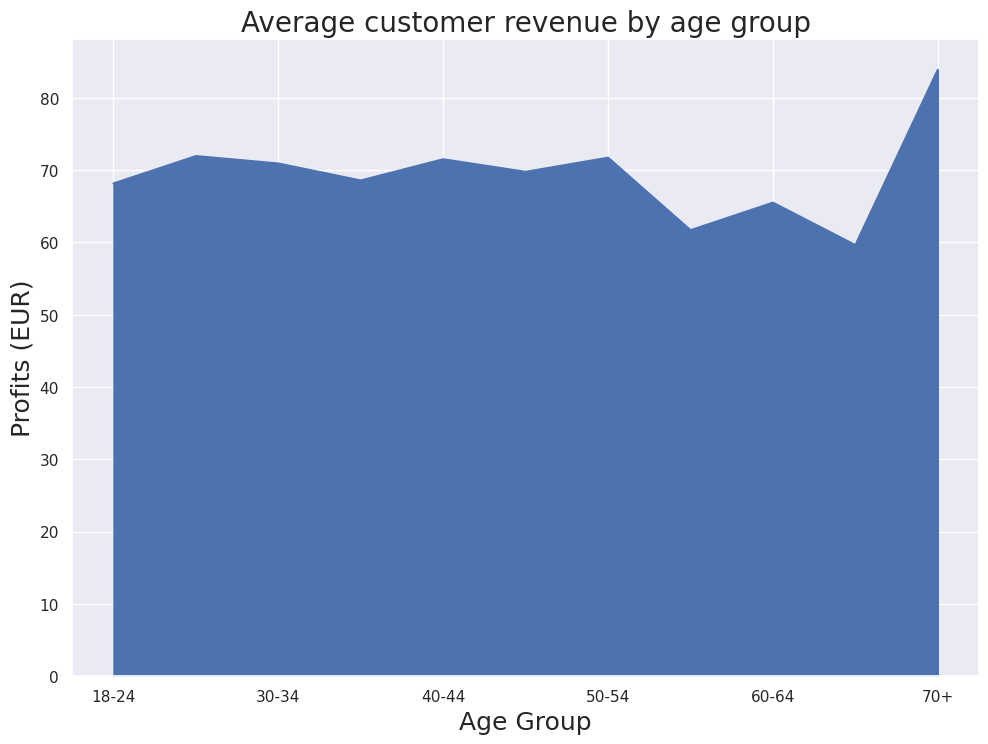

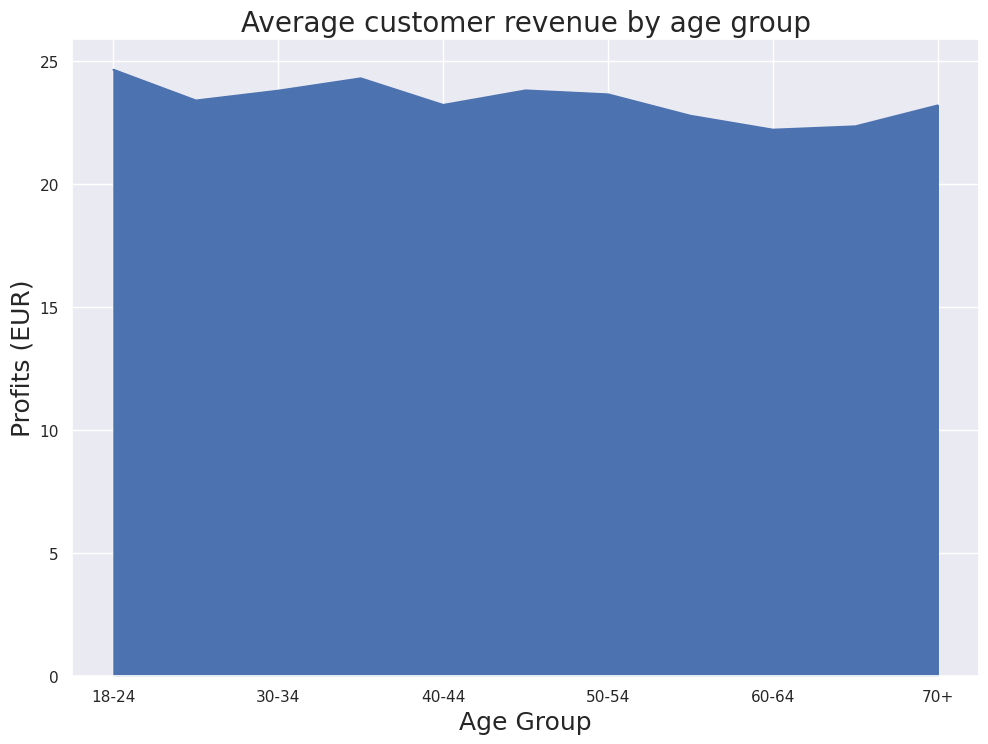

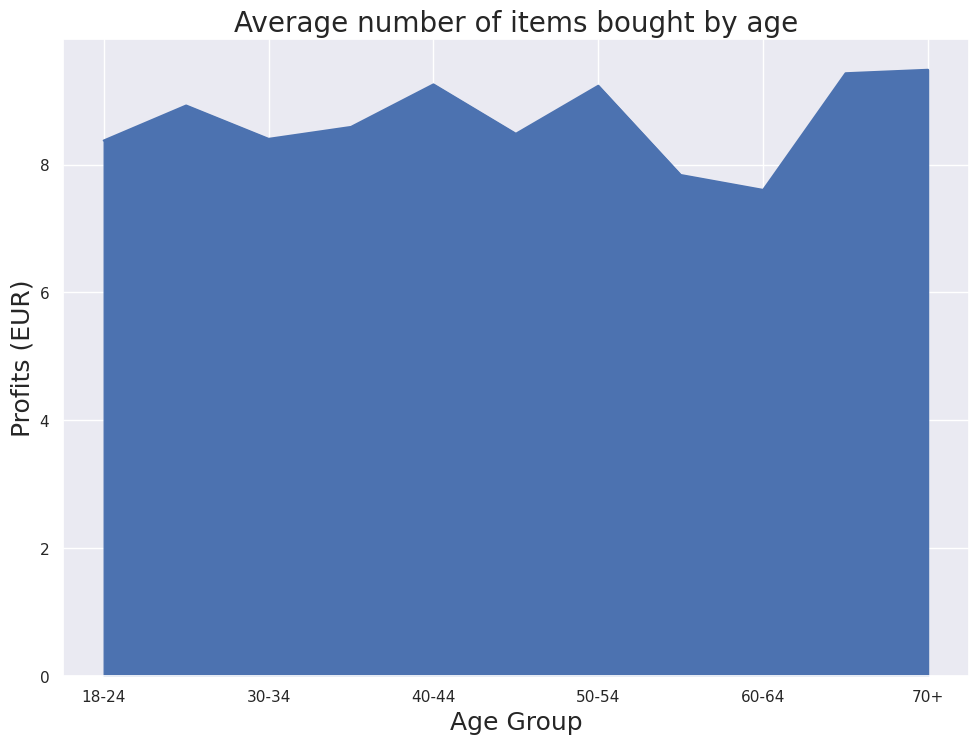

In [19]:
#Plotting the profits per age group
customers_df[["age_bin","total_revenue"]].groupby("age_bin").sum().reset_index().plot(x="age_bin", y="total_revenue",kind="bar",legend=False)
plt.title('Total profits by age group')
plt.ylabel('Profits (EUR)')
plt.xlabel('Age Group')
plt.show()

customers_df[["age_bin","total_revenue"]].groupby("age_bin").mean().reset_index().plot(x="age_bin", y="total_revenue",kind="area",legend=False)
plt.title('Average customer revenue by age group')
plt.ylabel('Profits (EUR)')
plt.xlabel('Age Group')
plt.show()

customers_df[["age_bin","total_revenue"]].groupby("age_bin").median().reset_index().plot(x="age_bin", y="total_revenue",kind="area",legend=False)
plt.title('Average customer revenue by age group')
plt.ylabel('Profits (EUR)')
plt.xlabel('Age Group')
plt.show()

customers_df[["age_bin","items_bought"]].groupby("age_bin").mean().reset_index().plot(x="age_bin", y="items_bought",kind="area",legend=False)
plt.title('Average number of items bought by age')
plt.ylabel('Profits (EUR)')
plt.xlabel('Age Group')
plt.show()

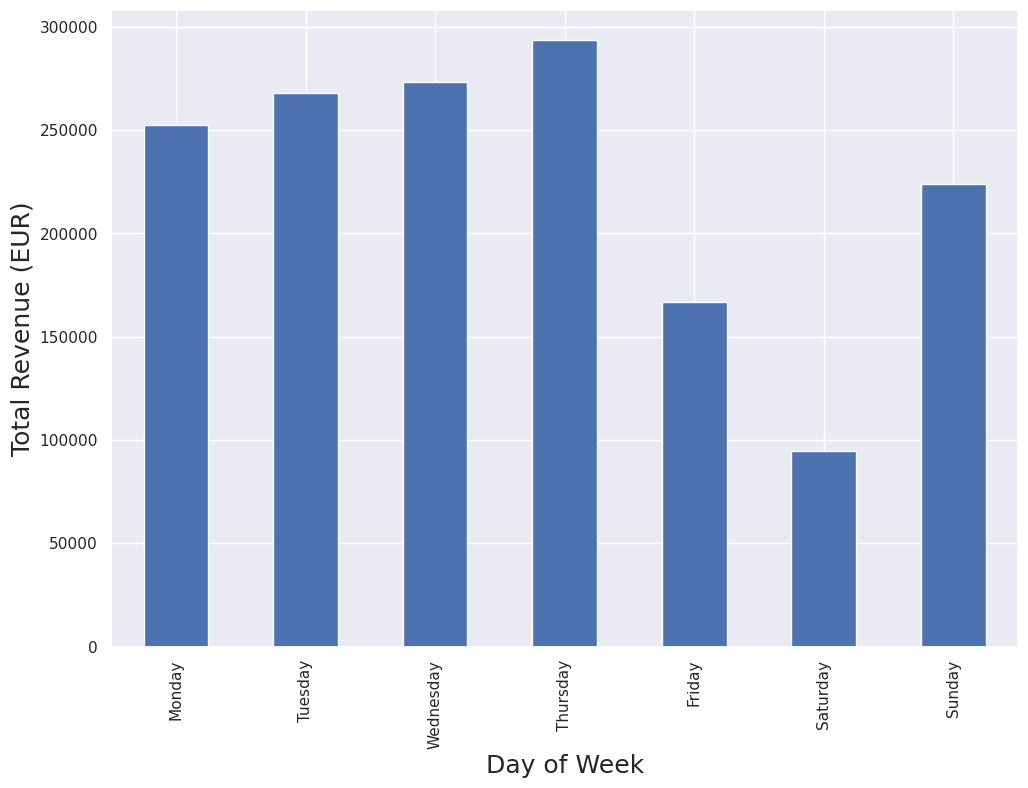

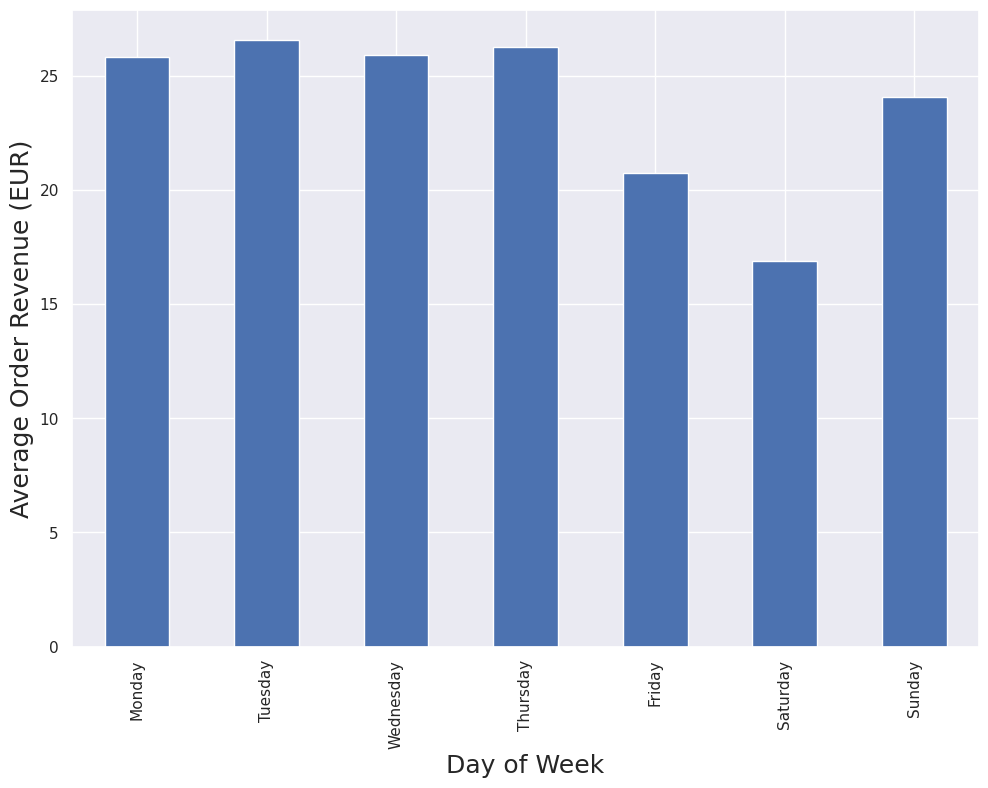

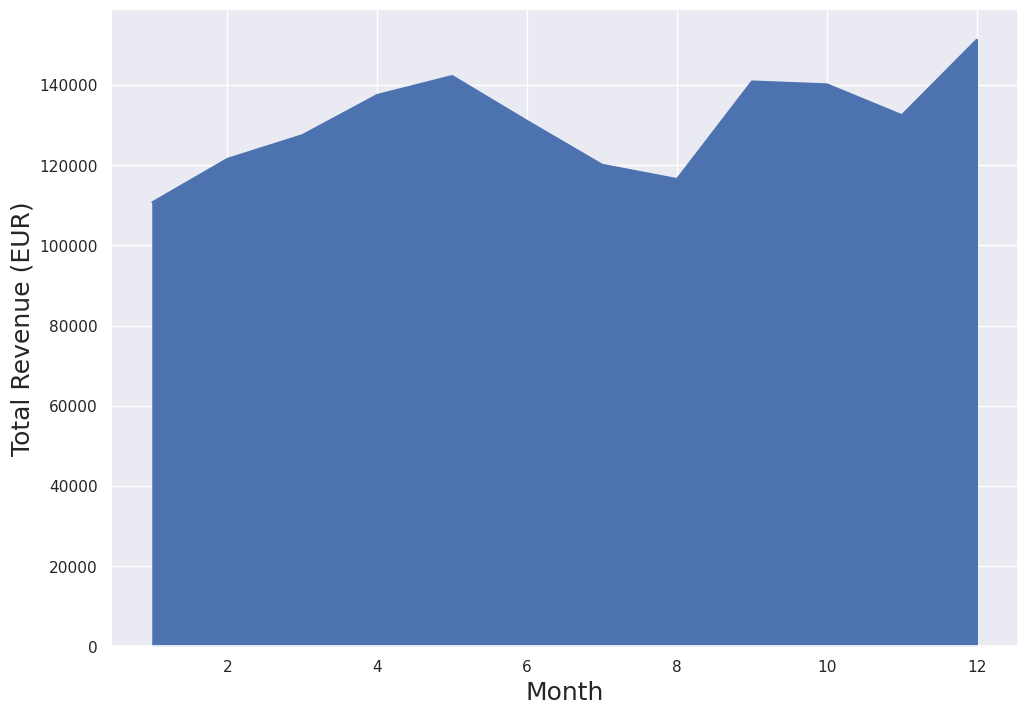

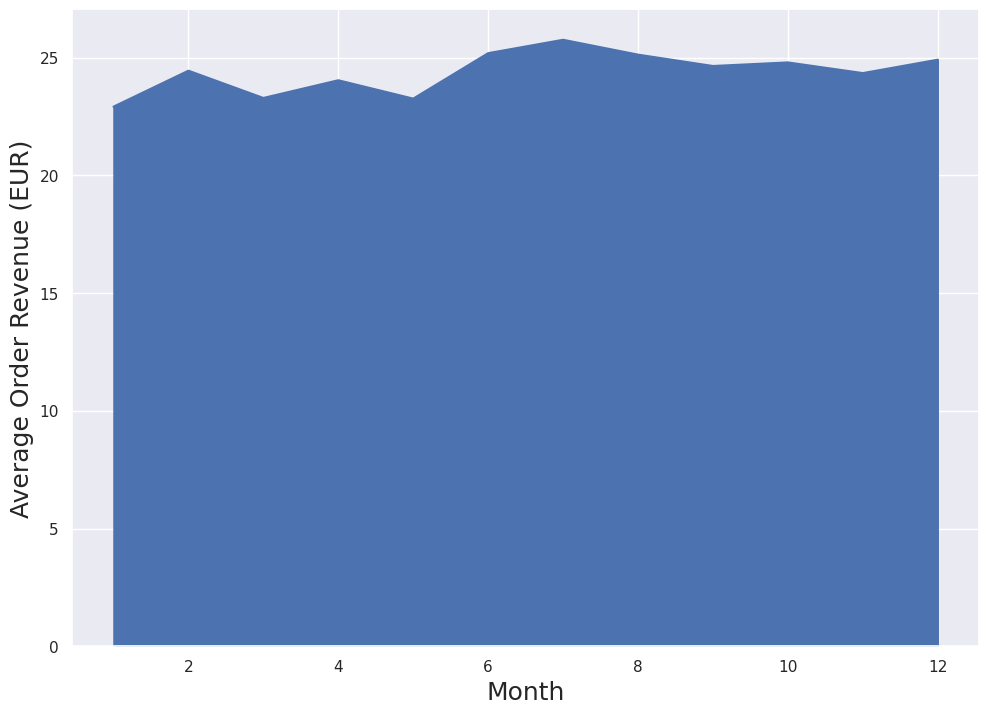

In [137]:
transactions['weekday'] = transactions.date.dt.day_name()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
transactions['weekday'] = pd.Categorical(transactions['weekday'], categories=cats, ordered=True)
transactions.groupby('weekday').sum(numeric_only=True).reset_index().plot(x='weekday', y='order_revenue', kind='bar', legend=False)
plt.xlabel('Day of Week')
plt.ylabel('Total Revenue (EUR)')
plt.show()
transactions.groupby('weekday').mean(numeric_only=True).reset_index().plot(x='weekday', y='order_revenue', kind='bar', legend=False)
plt.xlabel('Day of Week')
plt.ylabel('Average Order Revenue (EUR)')
plt.show()
transactions.groupby('month').sum(numeric_only=True).reset_index().plot(x='month', y='order_revenue', kind='area', legend=False)
plt.xlabel('Month')
plt.ylabel('Total Revenue (EUR)')
plt.show()
transactions.groupby('month').mean(numeric_only=True).reset_index().plot(x='month', y='order_revenue', kind='area', legend=False)
plt.xlabel('Month')
plt.ylabel('Average Order Revenue (EUR)')
plt.show()

## 2 RFM

In [28]:
# Monetary value has already been calculated, it is in the total revenue column of our dataframe
customers_df.head(2)

GENDER  AGE GEOGRAPHY  num_orders  avg_diff_items  items_bought  \
Customer_ID                                                                   
2547             F   48     Spain         7.0        2.285714          22.0   
822              F   39   Germany         3.0        1.666667           5.0   

             avg_items  total_revenue  avg_order_value  max_value  min_value  \
Customer_ID                                                                    
2547          3.142857         121.36        17.337143      39.62       3.13   
822           1.666667          20.40         6.800000       8.59       5.46   

             max_item_bought  min_item_bought first_date  last_date most_cat  \
Customer_ID                                                                    
2547                     6.0              1.0 2021-01-02 2021-04-16      X52   
822                      3.0              1.0 2021-01-02 2021-02-03      TW8   

            most_item_SKU age_bin  
Customer_ID                        
2547                885U7   45-49  
822                 68BRQ   35-39

In [29]:
# Recency
last_purchase_date = max(customers_df['last_date'])
print(last_purchase_date)
customers_df["recency"] = customers_df['last_date'].apply(lambda x: (last_purchase_date - x).days)
customers_df.head(1)

2021-12-31 00:00:00


GENDER  AGE GEOGRAPHY  num_orders  avg_diff_items  items_bought  \
Customer_ID                                                                   
2547             F   48     Spain         7.0        2.285714          22.0   

             avg_items  total_revenue  avg_order_value  max_value  min_value  \
Customer_ID                                                                    
2547          3.142857         121.36        17.337143      39.62       3.13   

             max_item_bought  min_item_bought first_date  last_date most_cat  \
Customer_ID                                                                    
2547                     6.0              1.0 2021-01-02 2021-04-16      X52   

            most_item_SKU age_bin  recency  
Customer_ID                                 
2547                885U7   45-49    259.0

In [30]:
# Frequency
freq_df = transactions[["Customer_ID", "date"]].groupby("Customer_ID").agg(frequency = ('date', 'count'))
freq_df.sort_values(by="frequency", ascending=False).head(5)

frequency
Customer_ID           
1660                99
1665                96
1710                94
1685                82
2186                81

In [31]:
customers_df = pd.merge(customers_df, freq_df, left_index=True, right_index=True, how="left")
customers_df.head(1)

GENDER  AGE GEOGRAPHY  num_orders  avg_diff_items  items_bought  \
Customer_ID                                                                   
2547             F   48     Spain         7.0        2.285714          22.0   

             avg_items  total_revenue  avg_order_value  max_value  min_value  \
Customer_ID                                                                    
2547          3.142857         121.36        17.337143      39.62       3.13   

             max_item_bought  min_item_bought first_date  last_date most_cat  \
Customer_ID                                                                    
2547                     6.0              1.0 2021-01-02 2021-04-16      X52   

            most_item_SKU age_bin  recency  frequency  
Customer_ID                                            
2547                885U7   45-49    259.0        7.0

In [32]:
# Calculating Recency (R), Frequency (F) and Monetary value (M) ranks
customers_df['R_rank'] = customers_df['recency'].rank(ascending=False)
customers_df['F_rank'] = customers_df['frequency'].rank(ascending=False)
customers_df['M_rank'] = customers_df['total_revenue'].rank(ascending=False)

customers_df['R_rank_norm'] = 100*customers_df['R_rank']/customers_df['R_rank'].max()
customers_df['F_rank_norm'] = 100*customers_df['F_rank']/customers_df['F_rank'].max()
customers_df['M_rank_norm'] = 100*customers_df['M_rank']/customers_df['M_rank'].max()

customers_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

customers_df.head(2)

GENDER  AGE GEOGRAPHY  num_orders  avg_diff_items  items_bought  \
Customer_ID                                                                   
2547             F   48     Spain         7.0        2.285714          22.0   
822              F   39   Germany         3.0        1.666667           5.0   

             avg_items  total_revenue  avg_order_value  max_value  ...  \
Customer_ID                                                        ...   
2547          3.142857         121.36        17.337143      39.62  ...   
822           1.666667          20.40         6.800000       8.59  ...   

             first_date  last_date  most_cat most_item_SKU age_bin recency  \
Customer_ID                                                                  
2547         2021-01-02 2021-04-16       X52         885U7   45-49   259.0   
822          2021-01-02 2021-02-03       TW8         68BRQ   35-39   331.0   

            frequency R_rank_norm  F_rank_norm  M_rank_norm  
Customer_ID                                                  
2547              7.0   28.656372    11.033847    13.565926  
822               3.0    6.687078    34.655731    54.389888  

[2 rows x 23 columns]

In [33]:
# Computing RFM
customers_df['RFM_score'] = 0.15*customers_df['R_rank_norm'] + 0.28*customers_df['F_rank_norm'] + 0.57*customers_df['M_rank_norm']
customers_df['RFM_score'] = customers_df['RFM_score'].apply(lambda x: round(x,2)*0.05)
customers_df.head(2)

GENDER  AGE GEOGRAPHY  num_orders  avg_diff_items  items_bought  \
Customer_ID                                                                   
2547             F   48     Spain         7.0        2.285714          22.0   
822              F   39   Germany         3.0        1.666667           5.0   

             avg_items  total_revenue  avg_order_value  max_value  ...  \
Customer_ID                                                        ...   
2547          3.142857         121.36        17.337143      39.62  ...   
822           1.666667          20.40         6.800000       8.59  ...   

             last_date  most_cat  most_item_SKU age_bin recency frequency  \
Customer_ID                                                                 
2547        2021-04-16       X52          885U7   45-49   259.0       7.0   
822         2021-02-03       TW8          68BRQ   35-39   331.0       3.0   

            R_rank_norm F_rank_norm  M_rank_norm  RFM_score  
Customer_ID                                                  
2547          28.656372   11.033847    13.565926     0.7560  
822            6.687078   34.655731    54.389888     2.0855  

[2 rows x 24 columns]

In [34]:

customers_df["customer_segment"] = None
customers_df.loc[(pd.isna(customers_df['customer_segment'])) & (customers_df['RFM_score'] > 4.5), 'customer_segment'] = 'Top Customer'
customers_df.loc[(pd.isna(customers_df['customer_segment'])) & (customers_df['RFM_score'] > 4), 'customer_segment'] = 'High Value Customers'
customers_df.loc[(pd.isna(customers_df['customer_segment'])) & (customers_df['RFM_score'] > 3), 'customer_segment'] = 'Medium Value Customer'
customers_df.loc[(pd.isna(customers_df['customer_segment'])) & (customers_df['RFM_score'] > 1.6), 'customer_segment'] = 'Low Value Customer'
customers_df.loc[(pd.isna(customers_df['customer_segment'])) & (customers_df['RFM_score'] <= 1.6), 'customer_segment'] = 'Lost Customer'

customers_df.head(5)

GENDER  AGE GEOGRAPHY  num_orders  avg_diff_items  items_bought  \
Customer_ID                                                                   
2547             F   48     Spain         7.0        2.285714          22.0   
822              F   39   Germany         3.0        1.666667           5.0   
3686             F   56    Greece        15.0        3.333333          63.0   
3719             F   49     Spain        10.0        4.700000          70.0   
9200             M   18     Italy         2.0        1.000000           2.0   

             avg_items  total_revenue  avg_order_value  max_value  ...  \
Customer_ID                                                        ...   
2547          3.142857         121.36        17.337143      39.62  ...   
822           1.666667          20.40         6.800000       8.59  ...   
3686          4.200000         405.44        27.029333     138.13  ...   
3719          7.000000         420.72        42.072000     224.98  ...   
9200          1.000000          18.01         9.005000      11.13  ...   

             most_cat  most_item_SKU  age_bin recency frequency R_rank_norm  \
Customer_ID                                                                   
2547              X52          885U7    45-49   259.0       7.0   28.656372   
822               TW8          68BRQ    35-39   331.0       3.0    6.687078   
3686              0H2          B87MU    55-59   298.0      15.0   16.755414   
3719              0KX          W14J3    45-49   301.0      10.0   15.794728   
9200              0H2          K8EHH    18-24   266.0       2.0   26.644036   

            F_rank_norm M_rank_norm  RFM_score    customer_segment  
Customer_ID                                                         
2547          11.033847   13.565926     0.7560       Lost Customer  
822           34.655731   54.389888     2.0855  Low Value Customer  
3686           2.618050    2.948729     0.2465       Lost Customer  
3719           5.949303    2.758346     0.2805       Lost Customer  
9200          53.314909   58.120074     2.6025  Low Value Customer  

[5 rows x 25 columns]

## 3 Clustering

### 3.1 Test Train Split

In [66]:
# First we need to select only relevant features
# X = pd.get_dummies(customers_df, columns=['GENDER','GEOGRAPHY'])

# We exclude geography as this influences too much our clustering algorithms
X = pd.get_dummies(customers_df, columns=['GENDER'])
X = X.select_dtypes(include=np.number)
X = X.dropna(axis=0)
print(X.shape)
X.head(2)

(22586, 19)


AGE  num_orders  avg_diff_items  items_bought  avg_items  \
Customer_ID                                                             
2547          48         7.0        2.285714          22.0   3.142857   
822           39         3.0        1.666667           5.0   1.666667   

             total_revenue  avg_order_value  max_value  min_value  \
Customer_ID                                                         
2547                121.36        17.337143      39.62       3.13   
822                  20.40         6.800000       8.59       5.46   

             max_item_bought  min_item_bought  recency  frequency  \
Customer_ID                                                         
2547                     6.0              1.0    259.0        7.0   
822                      3.0              1.0    331.0        3.0   

             R_rank_norm  F_rank_norm  M_rank_norm  RFM_score  GENDER_F  \
Customer_ID                                                               
2547           28.656372    11.033847    13.565926     0.7560         1   
822             6.687078    34.655731    54.389888     2.0855         1   

             GENDER_M  
Customer_ID            
2547                0  
822                 0

In [67]:
from sklearn.model_selection import train_test_split
#Creating train test split to be able to test stability
X_train, X_test = train_test_split(X, test_size=0.1, random_state=45658, shuffle=True)

X_train.head()

AGE  num_orders  avg_diff_items  items_bought  avg_items  \
Customer_ID                                                             
13765         50         1.0             1.0           1.0        1.0   
7085          43         1.0             1.0           1.0        1.0   
1634          45         1.0             3.0           7.0        7.0   
20599         48         5.0             2.0          13.0        2.6   
541           60         1.0             3.0           3.0        3.0   

             total_revenue  avg_order_value  max_value  min_value  \
Customer_ID                                                         
13765                 3.68            3.680       3.68       3.68   
7085                 11.19           11.190      11.19      11.19   
1634                 49.72           49.720      49.72      49.72   
20599                65.79           13.158      24.75       6.96   
541                  45.13           45.130      45.13      45.13   

             max_item_bought  min_item_bought  recency  frequency  \
Customer_ID                                                         
13765                    1.0              1.0    163.0        1.0   
7085                     1.0              1.0    308.0        1.0   
1634                     7.0              7.0    273.0        1.0   
20599                    6.0              1.0      2.0        5.0   
541                      3.0              3.0     39.0        1.0   

             R_rank_norm  F_rank_norm  M_rank_norm  RFM_score  GENDER_F  \
Customer_ID                                                               
13765          48.209531   100.000000    95.344461     4.4790         1   
7085           13.267661   100.000000    72.292571     3.5600         1   
1634           24.649450   100.000000    30.257682     2.4470         1   
20599          98.493521    18.388755    24.074648     1.6825         1   
541            78.352414   100.000000    32.358541     2.9100         1   

             GENDER_M  
Customer_ID            
13765               0  
7085                0  
1634                0  
20599               0  
541                 0

### 3.2 Preprocessing Pipeline

In [68]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer

#Define a function to remove highly correlated features
def correlated_features(dataset, threshold=0.8):
    correlated_columns = set()
    df = pd.DataFrame(dataset)
    correlations = df.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns

class CorrSelector(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.correlated_cols = None

    def fit(self, X, y=None):
        self.correlated_cols = correlated_features(X, threshold=self.threshold)
        self.correlated_indexes = [pd.DataFrame(X).columns.get_loc(c) for c in self.correlated_cols]
        return self

    def transform(self, X, y=None, **kwargs):
        self.X = X
        X_df = pd.DataFrame(X)
        return X_df.drop(X_df.columns[list(self.correlated_cols)], axis=1)

    def get_params(self, deep=False):
        return {"threshold": self.threshold}

    def get_feature_names_out(self, features_out):
        feature_list = list(features_out)
        for i in self.correlated_indexes:
            feature_list.pop(i)
        return feature_list


In [69]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
#Preprocessing pipeline with scaling and feature selection

preprocess_pipe = Pipeline([
    ('var', VarianceThreshold(threshold=0.04)),
    ('corr', CorrSelector()),
    ('scaler', MinMaxScaler())

])

X_train_tr = preprocess_pipe.fit_transform(X_train)
X_test_tr = preprocess_pipe.transform(X_test)

X_train_tr.shape

(20327, 10)

### 3.3 K Means Clustering

We will perform KMeans clustering to classify our customers into different segments

In [62]:
def cluster_stability(X, est, n_iter=10, random_state=None):
    labels = []
    indices = []
    for i in range(n_iter):
        # draw bootstrap samples, store indices
        sample_indices = rng.randint(0, X.shape[0], X.shape[0])
        indices.append(sample_indices)
        est = clone(est)
        if hasattr(est, "random_state"):
            # rando*mize estimator if possible
            est.random_state = rng.randint(1e5)
        X_bootstrap = X[sample_indices]
        est.fit(X_bootstrap)
        # store clustering outcome using original indices
        relabel = -np.ones(X.shape[0], dtype=np.int32)
        relabel[sample_indices] = est.labels_
        labels.append(relabel)
    scores = []
    for l, i in zip(labels, indices):
        for k, j in zip(labels, indices):
            # we also compute the diagonal which is a bit silly
            in_both = np.intersect1d(i, j)
            scores.append(adjusted_rand_score(l[in_both], k[in_both]))
    return np.mean(scores)

In [63]:
kf = KFold(n_splits=5)
scores = []

for k in range (2,11):  #Higher values of K have been tested before full implementation and have lower performance
    labels = []
    indices = []
    scores_stab = []
    SSD = []
    SIL = []
    for train_index, test_index in kf.split(X_train_tr):
        X_train = X_train_tr[train_index]
        X_test = X_train_tr[test_index]

        km_tr = KMeans(n_clusters=k, random_state=10, n_init = 10).fit(X_train)
        cluster_labels = km_tr.labels_
        ssd = km_tr.inertia_
        sil = silhouette_score(X_train, cluster_labels)
        SSD.append(ssd)
        SIL.append(sil)

        print("K: {}, Silhouette: {}".format(k, sil))

        #Calculating stability on the train set
        indices.append(train_index)
        relabel = -np.ones(X_train_tr.shape[0], dtype=np.int32)
        relabel[train_index] = cluster_labels
        labels.append(relabel)

        gc.enable()
        del X_train, X_test
        gc.collect()

    for l, i in zip(labels, indices):
        for m, j in zip(labels, indices):
        # we also compute the diagonal
            in_both = np.intersect1d(i, j)
            scores_stab.append(adjusted_rand_score(l[in_both], m[in_both]))


    print("K: {}, SSD: {}, Silhouette: {}, Stability: {}".format(k, np.mean(SSD), np.mean(SIL), np.mean(scores_stab)))
    scores.append({'K': k, 'SSD': np.mean(SSD), 'Silhouette': np.mean(SIL), 'Stability': np.mean(scores_stab)})




scores_df = pd.DataFrame(scores)

K: 2, Silhouette: 0.2555767316708261
K: 2, Silhouette: 0.2550382832566076
K: 2, Silhouette: 0.2560458931845127
K: 2, Silhouette: 0.25648619094633374
K: 2, Silhouette: 0.2564479234402243
K: 2, SSD: 14492.350150436632, Silhouette: 0.2559190044997009, Stability: 1.0
K: 3, Silhouette: 0.35658701264157255
K: 3, Silhouette: 0.3558233627852188
K: 3, Silhouette: 0.35660894783070207
K: 3, Silhouette: 0.3566324128572991
K: 3, Silhouette: 0.3575987723553512
K: 3, SSD: 11252.14974416263, Silhouette: 0.3566501016940288, Stability: 1.0
K: 4, Silhouette: 0.4130863204368559
K: 4, Silhouette: 0.4117588303003368
K: 4, Silhouette: 0.41279671804328755
K: 4, Silhouette: 0.41269648046225643
K: 4, Silhouette: 0.413396711213954
K: 4, SSD: 9415.06339692455, Silhouette: 0.41274701209133813, Stability: 1.0
K: 5, Silhouette: 0.46403987742465835
K: 5, Silhouette: 0.4634980077848103
K: 5, Silhouette: 0.46384911127477724
K: 5, Silhouette: 0.46396000025364686
K: 5, Silhouette: 0.4648052379290772
K: 5, SSD: 7841.03978

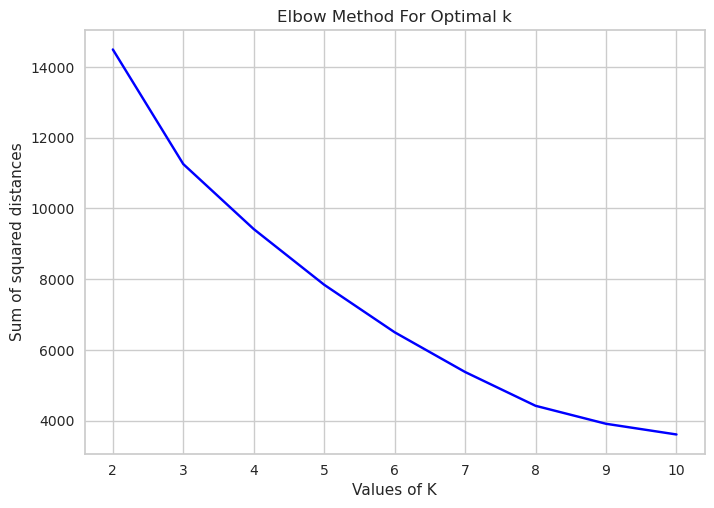

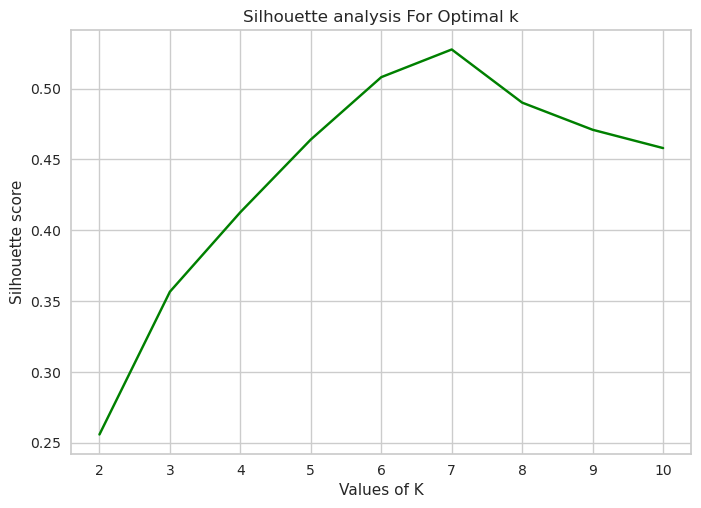

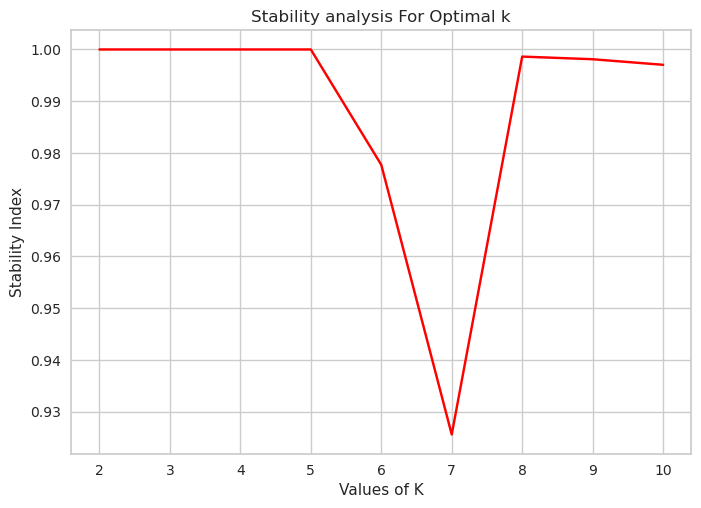

In [64]:
#Plotting our Elbow Score
ax = plt.figure().gca()
plt.plot(scores_df.K, scores_df.SSD,'x-', color="blue", label = "SSD")
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#Displaying the Silhouette score
ax = plt.figure().gca()
plt.plot(scores_df.K,scores_df.Silhouette,'x-', color="green", label="Silhouette score" )
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#Displaying our Stability Index
ax = plt.figure().gca()
plt.plot(scores_df.K,scores_df.Stability,'x-', color="red", label="Stability Index" )
plt.xlabel('Values of K') 
plt.ylabel('Stability Index') 
plt.title('Stability analysis For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


In [65]:
%%capture --no-display
from clusteval import clusteval

ce = clusteval(cluster='kmeans')

results = ce.fit(X_train_tr)

print(results['labx'])

ce.plot()
ce.scatter(X_train_tr)

KeyboardInterrupt: 

In [56]:
#Selecting 7 as our best amount of clusters
km = KMeans(n_clusters=7)
clusters= km.fit_predict(X_train_tr)

/home/faskill/miniconda3/envs/rbs/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


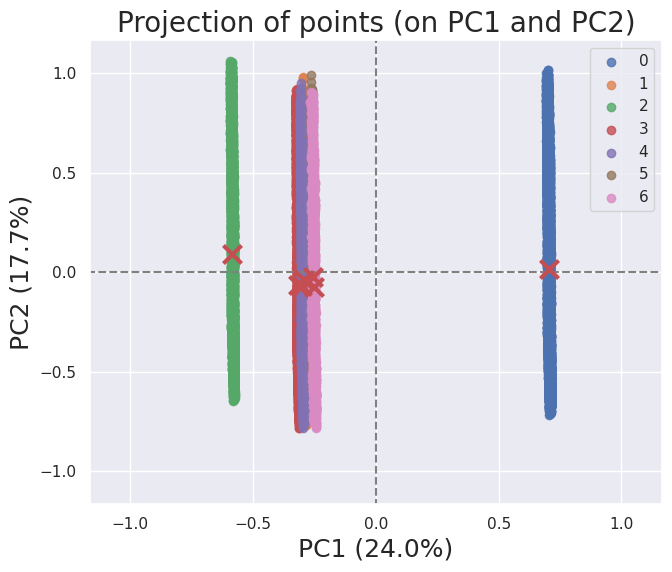

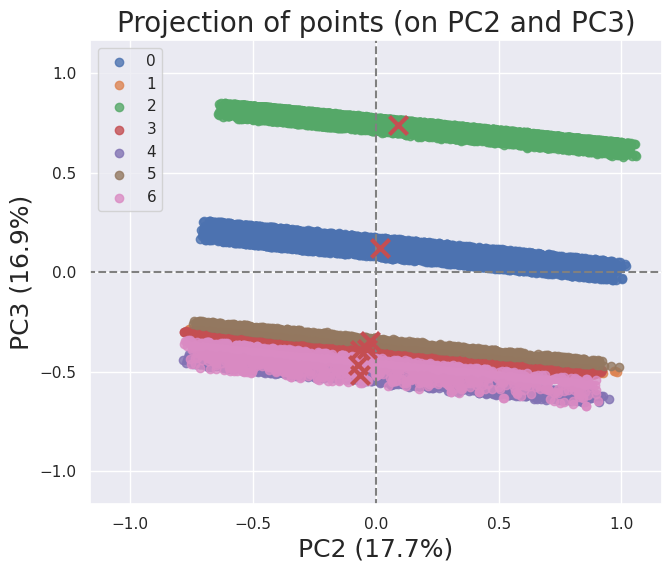

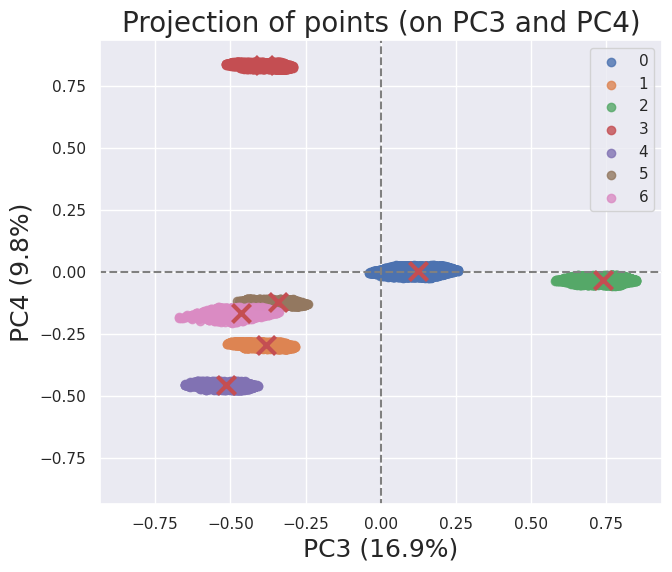

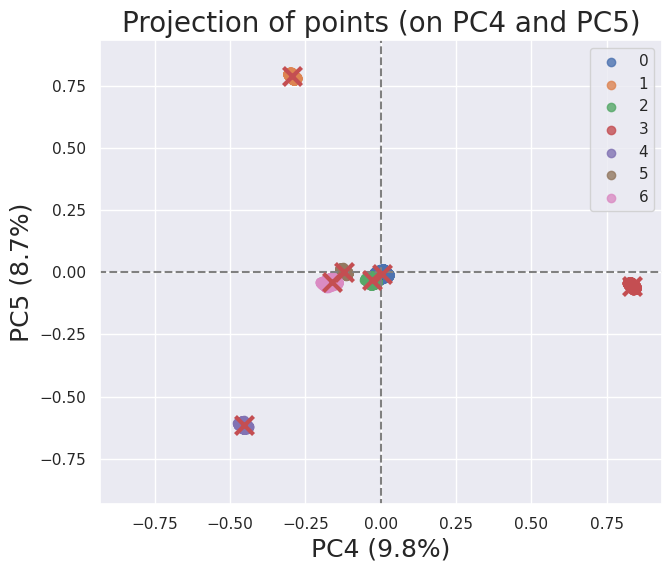

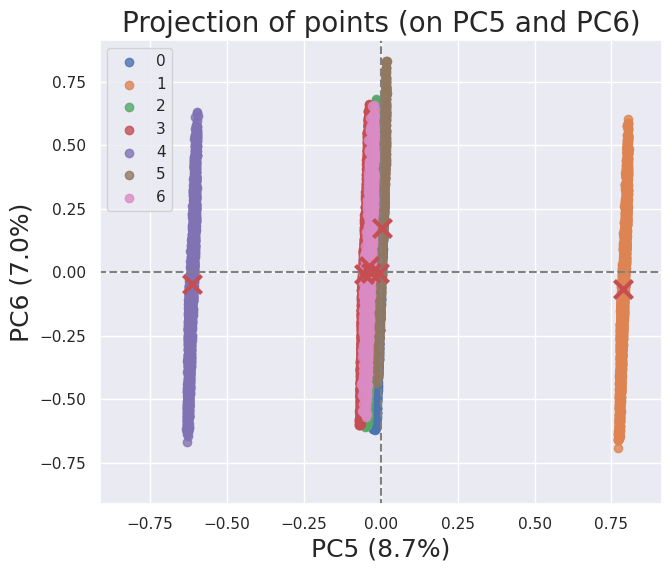

In [58]:
#Restricting to 6 components to have 90% of explained variance
n_components = 6
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components = n_components, n_oversamples=10)
pca.fit(X_train_tr)

# Transfor the scaled data to the new PCA space
X_train_red = pca.transform(X_train_tr)

centres_reduced = pca.transform(km.cluster_centers_)
for i in range(1,n_components):
    display_factorial_planes(X_train_red, n_components, pca, [(i-1,i)], illustrative_var = clusters, alpha = 0.8)
    plt.scatter(centres_reduced[:, i-1], centres_reduced[:, i],
                marker='x', s=169, linewidths=3,
                color='r', zorder=10)
    plt.tight_layout()
    plt.show()

### 3.4 DBSCAN

### 3.4.1 Hyperparameter tuning

To tune the hyperparameter of the DBSCAN algorithm, we will use a starting point the heuristics defined in the latest DBSCAN paper (https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf). 
For setting eps, it is advised to perform kdist plotting using the NearestNeighbors algorithm and to set :

k = 2*number of features -1

For min_samples, the starting point should generally be twice the number of features, or 66 in that case.

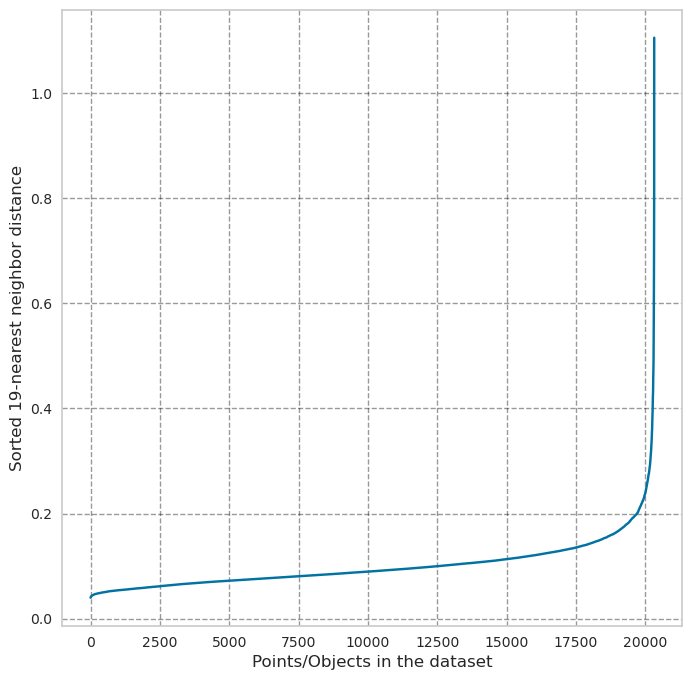

In [70]:
#Defining kdist plot
from sklearn.neighbors import NearestNeighbors

def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()

#Defining K as 
k = 2 * X_train_tr.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=X_train_tr, k=k)

We see in the kdist plot above that the elbow is at around 0.2, so we will look for an eps at around 0.2

In [73]:
#Specify parameters to sample from
param_grid = list(ParameterGrid(
    {
    'min_samples': [10,50,100,200,300,400,500,700],
    'eps' : [0.15,0.2,0.25,0.3,0.37,0.45,0.55,0.6, 0.65, 0.75],
    'metric': ['euclidean','manhattan']
}))

scores = []
kf = KFold(n_splits=3)
SIL = []
i = 0
#Performing manual gridsearch
for params in param_grid:

    labels = []
    indices = []
    scores_stab = []
    SIL = []

    for train_index, test_index in kf.split(X_train_tr):
        print(i)
        i+=1
        X_train = X_train_tr[train_index]
        X_test = X_train_tr[test_index]

        dbs = DBSCAN(n_jobs=-1,
                      min_samples=params['min_samples'],
                      eps=params['eps'],
                      metric=params['metric']).fit(X_train)
        clusters = dbs.labels_
        if len(np.unique(clusters)) > 1:
            sil = silhouette_score(X_train, clusters)
        else:
            sil = 0
        SIL.append(sil)

        #Calculating stability on the train set
        indices.append(train_index)
        relabel = -np.ones(X_train_tr.shape[0], dtype=np.int32)
        relabel[train_index] = clusters
        labels.append(relabel)

        min_samples_pct = params['min_samples'] / len(X_train)

        gc.enable()
        del X_train, X_test
        gc.collect()

    for l, i in zip(labels, indices):
        for m, j in zip(labels, indices):
        # we also compute the diagonal
            in_both = np.intersect1d(i, j)
            scores_stab.append(adjusted_rand_score(l[in_both], m[in_both]))
    print("min_samples: {}, eps: {}, metric: {} ==>  Silhouette: {}, Stability {}".format(
    params['min_samples'], params['eps'], params['metric'], np.mean(SIL), np.mean(scores_stab)))
    scores.append({'min_samples': params['min_samples'], 'min_samples_pct': min_samples_pct,'eps': params['eps'],
                   'metric': params['metric'],'Silhouette': np.mean(SIL), 'Stability': np.mean(scores_stab)})

scores_dbs = pd.DataFrame(scores)

0
1
2
min_samples: 10, eps: 0.15, metric: euclidean ==>  Silhouette: 0.2202471682766786, Stability 0.991895034641392
[    0     1     2 ... 13549 13550 13551]
[    1     2     3 ... 13550 13551 13552]
[    2     3     4 ... 13551 13552 13553]
min_samples: 50, eps: 0.15, metric: euclidean ==>  Silhouette: 0.20643599470378637, Stability 0.9701388934500952
[    0     1     2 ... 13549 13550 13551]
[    1     2     3 ... 13550 13551 13552]
[    2     3     4 ... 13551 13552 13553]
min_samples: 100, eps: 0.15, metric: euclidean ==>  Silhouette: 0.09956199227645689, Stability 0.9505946488408434
[    0     1     2 ... 13549 13550 13551]
[    1     2     3 ... 13550 13551 13552]
[    2     3     4 ... 13551 13552 13553]
min_samples: 200, eps: 0.15, metric: euclidean ==>  Silhouette: 0.04081366268388406, Stability 0.9502000035302073
[    0     1     2 ... 13549 13550 13551]
[    1     2     3 ... 13550 13551 13552]
[    2     3     4 ... 13551 13552 13553]
min_samples: 300, eps: 0.15, metric: e

In [72]:
scores_dbs = scores_dbs.sort_values(by="Silhouette", ascending=False)

with open('data/dbscan_scores_v2.pkl','wb') as file:
    dill.dump(scores_dbs, file)

scores_dbs


min_samples  min_samples_pct   eps     metric  Silhouette  Stability
98           100         0.007379  0.55  euclidean    0.441441   0.812547
103          700         0.051653  0.55  euclidean    0.440828   1.000000
102          500         0.036895  0.55  euclidean    0.440828   1.000000
97            50         0.003689  0.55  euclidean    0.440242   0.955514
99           200         0.014758  0.55  euclidean    0.439207   0.881367
..           ...              ...   ...        ...         ...        ...
31           700         0.051653  0.20  manhattan    0.000000   1.000000
10           100         0.007379  0.15  manhattan   -0.024846   0.780942
42           100         0.007379  0.25  manhattan   -0.031485   0.936145
25            50         0.003689  0.20  manhattan   -0.090241   0.920688
8             10         0.000738  0.15  manhattan   -0.198532   0.910728

[112 rows x 6 columns]

In [73]:
#Defining our final DBSCAN model with optimized hyperparameters
dbs_best = DBSCAN(n_jobs=-1,
                  min_samples=int(0.007379*len(X_train_tr)),
                  eps=0.55,
                  metric='euclidean').fit(X_train_tr)

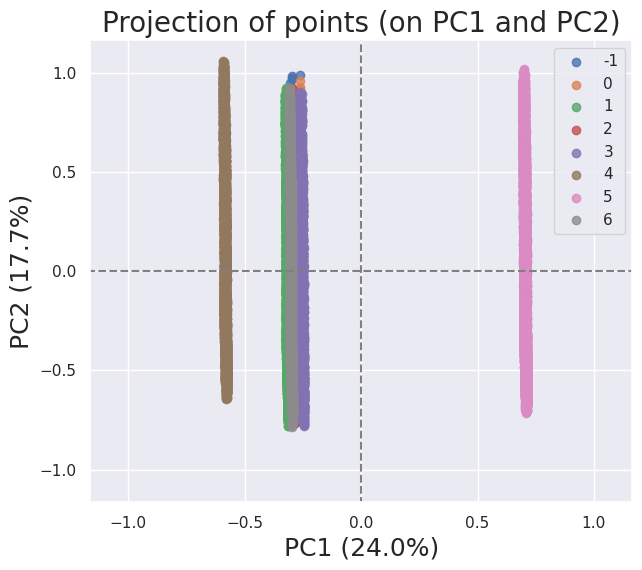

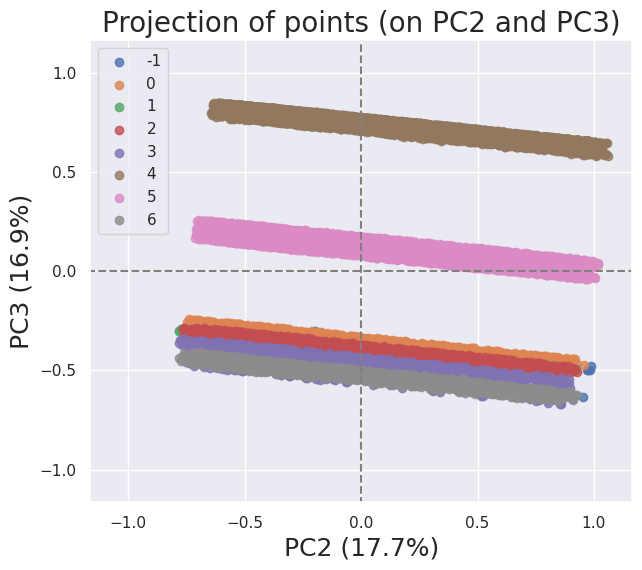

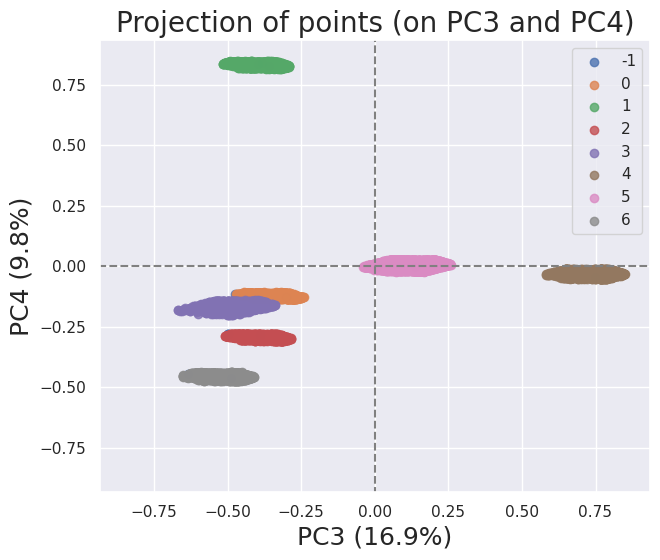

In [74]:
#Visualization with PCA
# Creating a PCA model to reduce our data for visualisation
n_components = 4
pca = PCA(n_components=n_components, n_oversamples=10)
pca.fit(X_train_tr)

#Transforming our initial dataset
X_train_red = pca.transform(X_train_tr)

clusters = dbs_best.labels_

for i in range(1,n_components):
    display_factorial_planes(X_train_red, 4, pca, [(i-1,i)], illustrative_var = clusters, alpha = 0.8)

plt.tight_layout()
plt.show()

In [76]:
scores_df = scores_df.sort_values(by="Silhouette", ascending=False)
scores_df

K           SSD  Silhouette  Stability
5   7   5374.911528    0.527558   0.925613
4   6   6498.314806    0.508032   0.977710
6   8   4419.574120    0.490049   0.998624
7   9   3911.373815    0.470907   0.998113
3   5   7841.039788    0.464030   1.000000
8  10   3609.064800    0.457984   0.997038
2   4   9415.063397    0.412747   1.000000
1   3  11252.149744    0.356650   1.000000
0   2  14492.350150    0.255919   1.000000

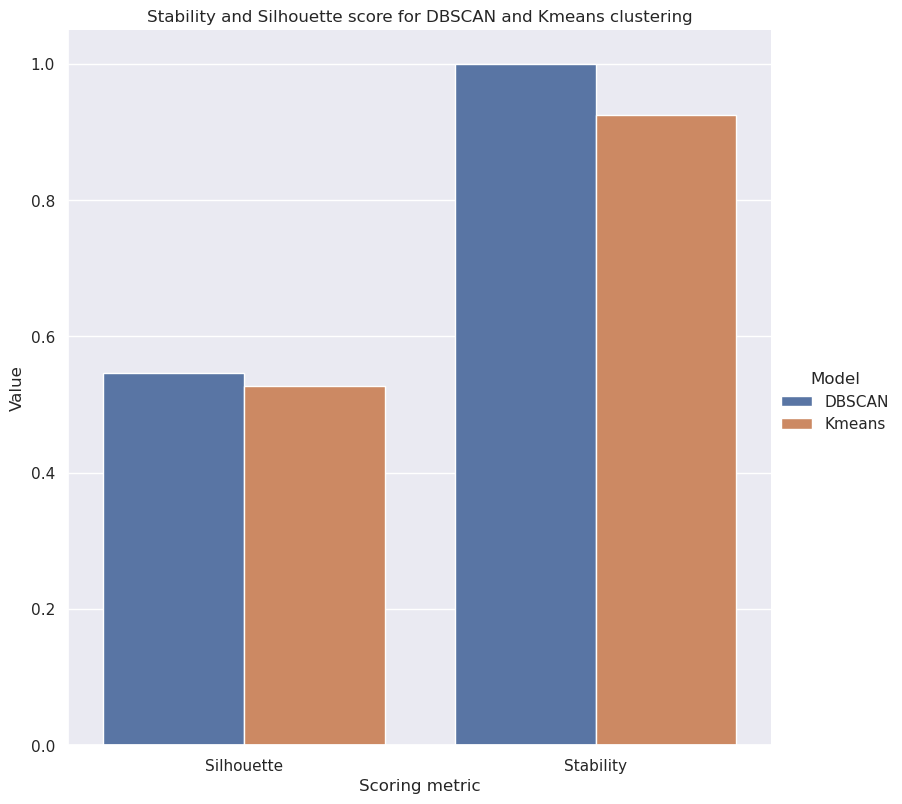

In [77]:
results = pd.DataFrame([{"Model" : "DBSCAN", "Silhouette": 0.545910, "Stability": 0.999906},
                      {"Model" : "Kmeans", "Silhouette": 0.527558, "Stability": 0.925613}])

results = pd.melt(results, id_vars='Model')

sns.set(rc={'figure.figsize':(20,15)})
sns.catplot(x='variable', y='value', hue='Model', data=results, kind='bar', height = 8)
plt.title("Stability and Silhouette score for DBSCAN and Kmeans clustering")
plt.xlabel("Scoring metric")
plt.ylabel("Value")
plt.show()

### 3.5 Final Model Performance

We will select DBSCAN as our model of choice since it has better performance than our Kmeans algorithm

In [45]:
X_tr = preprocess_pipe.transform(X)

dbs_best = DBSCAN(n_jobs=-1,
                  min_samples=int(0.007379*len(X_train_tr)),
                  eps=0.55,
                  metric='euclidean').fit(X_tr)
labels = dbs_best.labels_

silhouette = silhouette_score(X_tr, labels)
stability = cluster_stability(X_tr, dbs_best)
print("Silhouette score on dataset: {:.3f}, Stability index : {:.3f}".format(silhouette,stability))

cols = list(X.drop(X.columns[list(preprocess_pipe[-2].correlated_cols)], axis=1).columns)
X_tr = pd.DataFrame(X_tr, columns = cols)

X_tr["cluster"] = labels

X_tr.loc[X_tr["cluster"] > -1, "cluster"] = X_tr["cluster"] + 1 


Silhouette score on dataset: 0.546, Stability index : 1.000


In [46]:
#Studying the repartition of clusters

sub = X_tr.cluster.value_counts()

fig = go.Figure(data=[go.Pie(values=sub, labels=sub.index)])
fig.update_layout(
title={
    'text': "Pie chart of the repartition of clusters",
},
title_x = 0.5,
font=dict(
    size=18,
    color="Black"
))
fig.show()

print(len(X_tr[X_tr.cluster==-1]))
#Only 14 customers have not ben classified

14


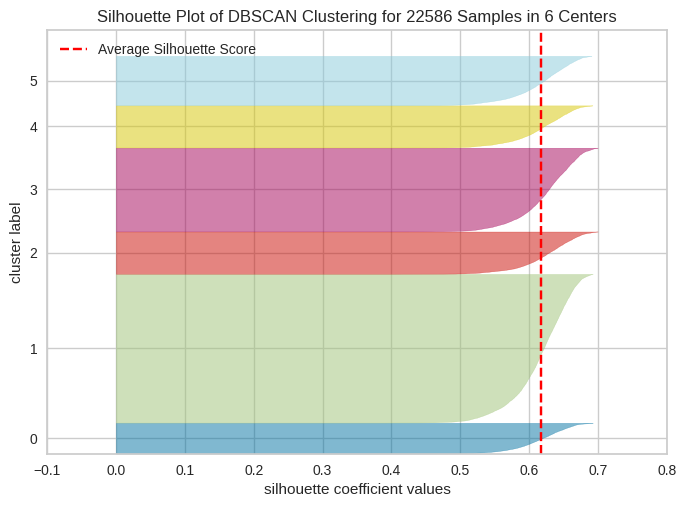

In [47]:
%%capture --no-display
#Extending yellowbrick silhouette visualizer with the capability to plot silhouette plots from clustering algorithms without
#n_clusters and predict functions
from silhouetteng import SilhouetteVisualizerNG

#This is necessary to prevent modifying the source silhouette visualizer code too much
dbs_best.n_clusters = 6
#Modified predict(X) to predict in the function
dbs_best.predict = dbs_best.labels_

visualizer = SilhouetteVisualizerNG(dbs_best, is_fitted=True,colors='yellowbrick')
visualizer.fit(X_tr)
visualizer.show()
plt.show()

### 3.5 Describing our customer segments

In [48]:
X_tr

AGE  num_orders  avg_diff_items  items_bought  avg_items  \
0      0.526316    0.061224        0.075630      0.025830   0.005265   
1      0.368421    0.020408        0.039216      0.004920   0.001638   
2      0.666667    0.142857        0.137255      0.076261   0.007862   
3      0.543860    0.091837        0.217647      0.084871   0.014742   
4      0.000000    0.010204        0.000000      0.001230   0.000000   
...         ...         ...             ...           ...        ...   
22581  0.245614    0.000000        0.000000      0.000000   0.000000   
22582  0.508772    0.000000        0.058824      0.001230   0.002457   
22583  0.280702    0.000000        0.117647      0.002460   0.004914   
22584  0.192982    0.000000        0.000000      0.000000   0.000000   
22585  0.614035    0.000000        0.000000      0.000000   0.000000   

       total_revenue  avg_order_value   recency  F_rank_norm  M_rank_norm  \
0           0.030693         0.031575  0.713499     0.110286     0.135621   
1           0.005130         0.012228  0.911846     0.346518     0.543879   
2           0.102623         0.049370  0.820937     0.026123     0.029444   
3           0.106492         0.076989  0.829201     0.059437     0.027540   
4           0.004525         0.016277  0.732782     0.533121     0.581182   
...              ...              ...       ...          ...          ...   
22581       0.006685         0.048471  0.495868     1.000000     0.468807   
22582       0.003228         0.023410  0.418733     1.000000     0.678968   
22583       0.015053         0.109153  0.495868     1.000000     0.261280   
22584       0.000266         0.001928  0.495868     1.000000     0.997277   
22585       0.001122         0.008134  0.495868     1.000000     0.924950   

       GEOGRAPHY_France  GEOGRAPHY_Germany  GEOGRAPHY_Greece  GEOGRAPHY_Italy  \
0                   0.0                0.0               0.0              0.0   
1                   0.0                1.0               0.0              0.0   
2                   0.0                0.0               1.0              0.0   
3                   0.0                0.0               0.0              0.0   
4                   0.0                0.0               0.0              1.0   
...                 ...                ...               ...              ...   
22581               0.0                1.0               0.0              0.0   
22582               0.0                0.0               0.0              0.0   
22583               0.0                1.0               0.0              0.0   
22584               0.0                1.0               0.0              0.0   
22585               0.0                0.0               1.0              0.0   

       GEOGRAPHY_Netherlands  GEOGRAPHY_Spain  GEOGRAPHY_UK  cluster  
0                        0.0              1.0           0.0        1  
1                        0.0              0.0           0.0        2  
2                        0.0              0.0           0.0        3  
3                        0.0              1.0           0.0        1  
4                        0.0              0.0           0.0        4  
...                      ...              ...           ...      ...  
22581                    0.0              0.0           0.0        2  
22582                    0.0              1.0           0.0        1  
22583                    0.0              0.0           0.0        2  
22584                    0.0              0.0           0.0        2  
22585                    0.0              0.0           0.0        3  

[22586 rows x 18 columns]

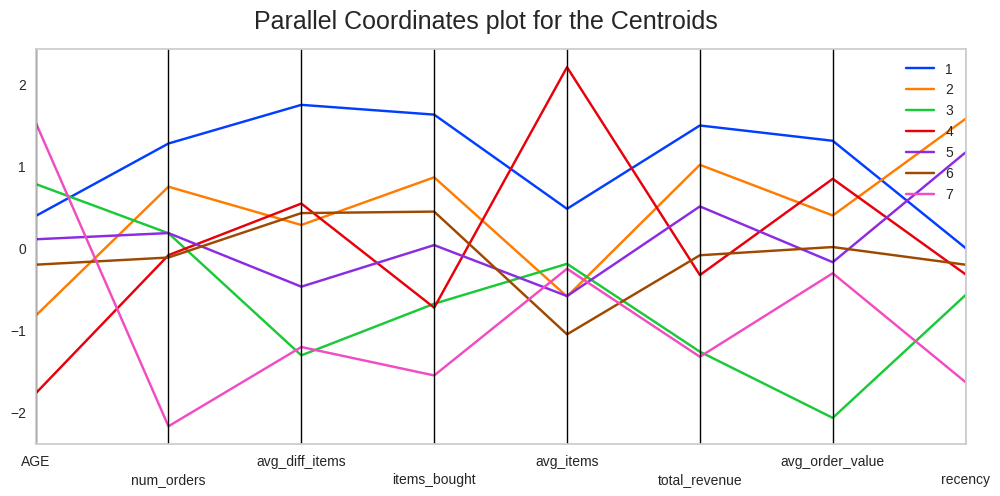

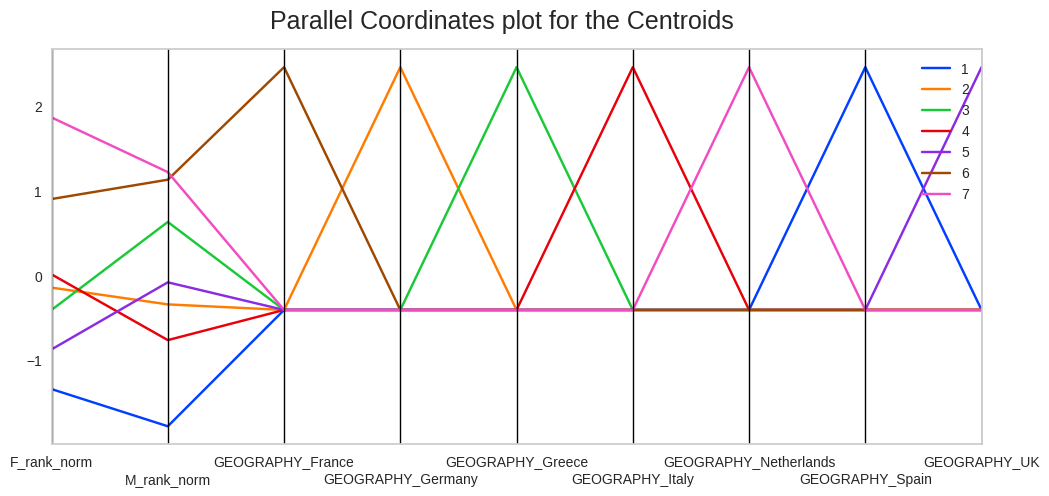

In [49]:
#Removing unclustered datapoints
df_mean = X_tr.drop(X_tr[X_tr.cluster == -1].index)
#Aggregating by cluster and calculating the means of each fields
df_mean = df_mean.groupby("cluster").mean()

#Rescaling data for better visualization
df_mean_scaled = StandardScaler().fit_transform(df_mean)

#Transforming our data back into a dataframe
df_mean = pd.DataFrame(df_mean_scaled, columns=df_mean.columns.to_list()).reset_index()
df_mean.rename(columns={"index": "cluster"}, inplace=True)

#Adding 1 to the number of cluster just to have numbers from 1 to 7
df_mean["cluster"] = df_mean["cluster"] + 1
clusters = df_mean["cluster"]
for k in range(1,3):
    i = k*9
    if i > len(X_tr):
        subset = df_mean.iloc[:, -9:]
        subset["cluster"] = clusters
    elif k==1:
        subset = df_mean.iloc[:,(i-9):i]
    else:
        subset = df_mean.iloc[:,(i-9):i]
        subset["cluster"] = clusters
    display_parallel_coordinates_centroids(subset, 6)
    plt.show()

In [165]:
# LaTeX setup
plt.rcParams['font.family'] = 'serif'  # use serif font as default
plt.rcParams['text.usetex'] = True  # enable LaTeX rendering globally


## 5 CLV calculation
### Churn rate

In [ ]:
num_customers = len(orders.Customer_ID.unique())
churn_df = orders.groupby("Customer_ID").nunique()[["Transaction_ID"]]
churn_rate = 1- len(churn_df[churn_df.Transaction_ID > 1])/num_customers
churn_rate

0.5101390241742673

### Average Purchase Frequency

In [ ]:
apf = len(orders.Transaction_ID.unique())/num_customers
apf

2.856017001682458

### Average Purchase Value

In [ ]:
apv = orders.Sales_Amount.sum()/num_customers
apv

69.59138094394757

### Customer Lifetime Value (CLV)

In [ ]:
clv = apv*apf/churn_rate
clv

389.60784752389185